# CIS 545 Final Project : Predicting the Success of Movies


# Introduction

Being at home for much of quarantine, both of us found ourselves watching FAR more movies than ever before. We were intrigued by what drives the success of movies, specifically how much income they make, and thus we decided to dive into an IMDB dataset. This annotated notebook will take you through our process of loading and cleaning the data, exploring the data, and then modeling the data.

We will use a [dataset from Kaggle](https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset) to train a model that will predict the success of movies. This dataset contains various features of movies, such as genre, published date, and more, and we will use the **worldwide gross income** of movies to determine if the movie is successful.

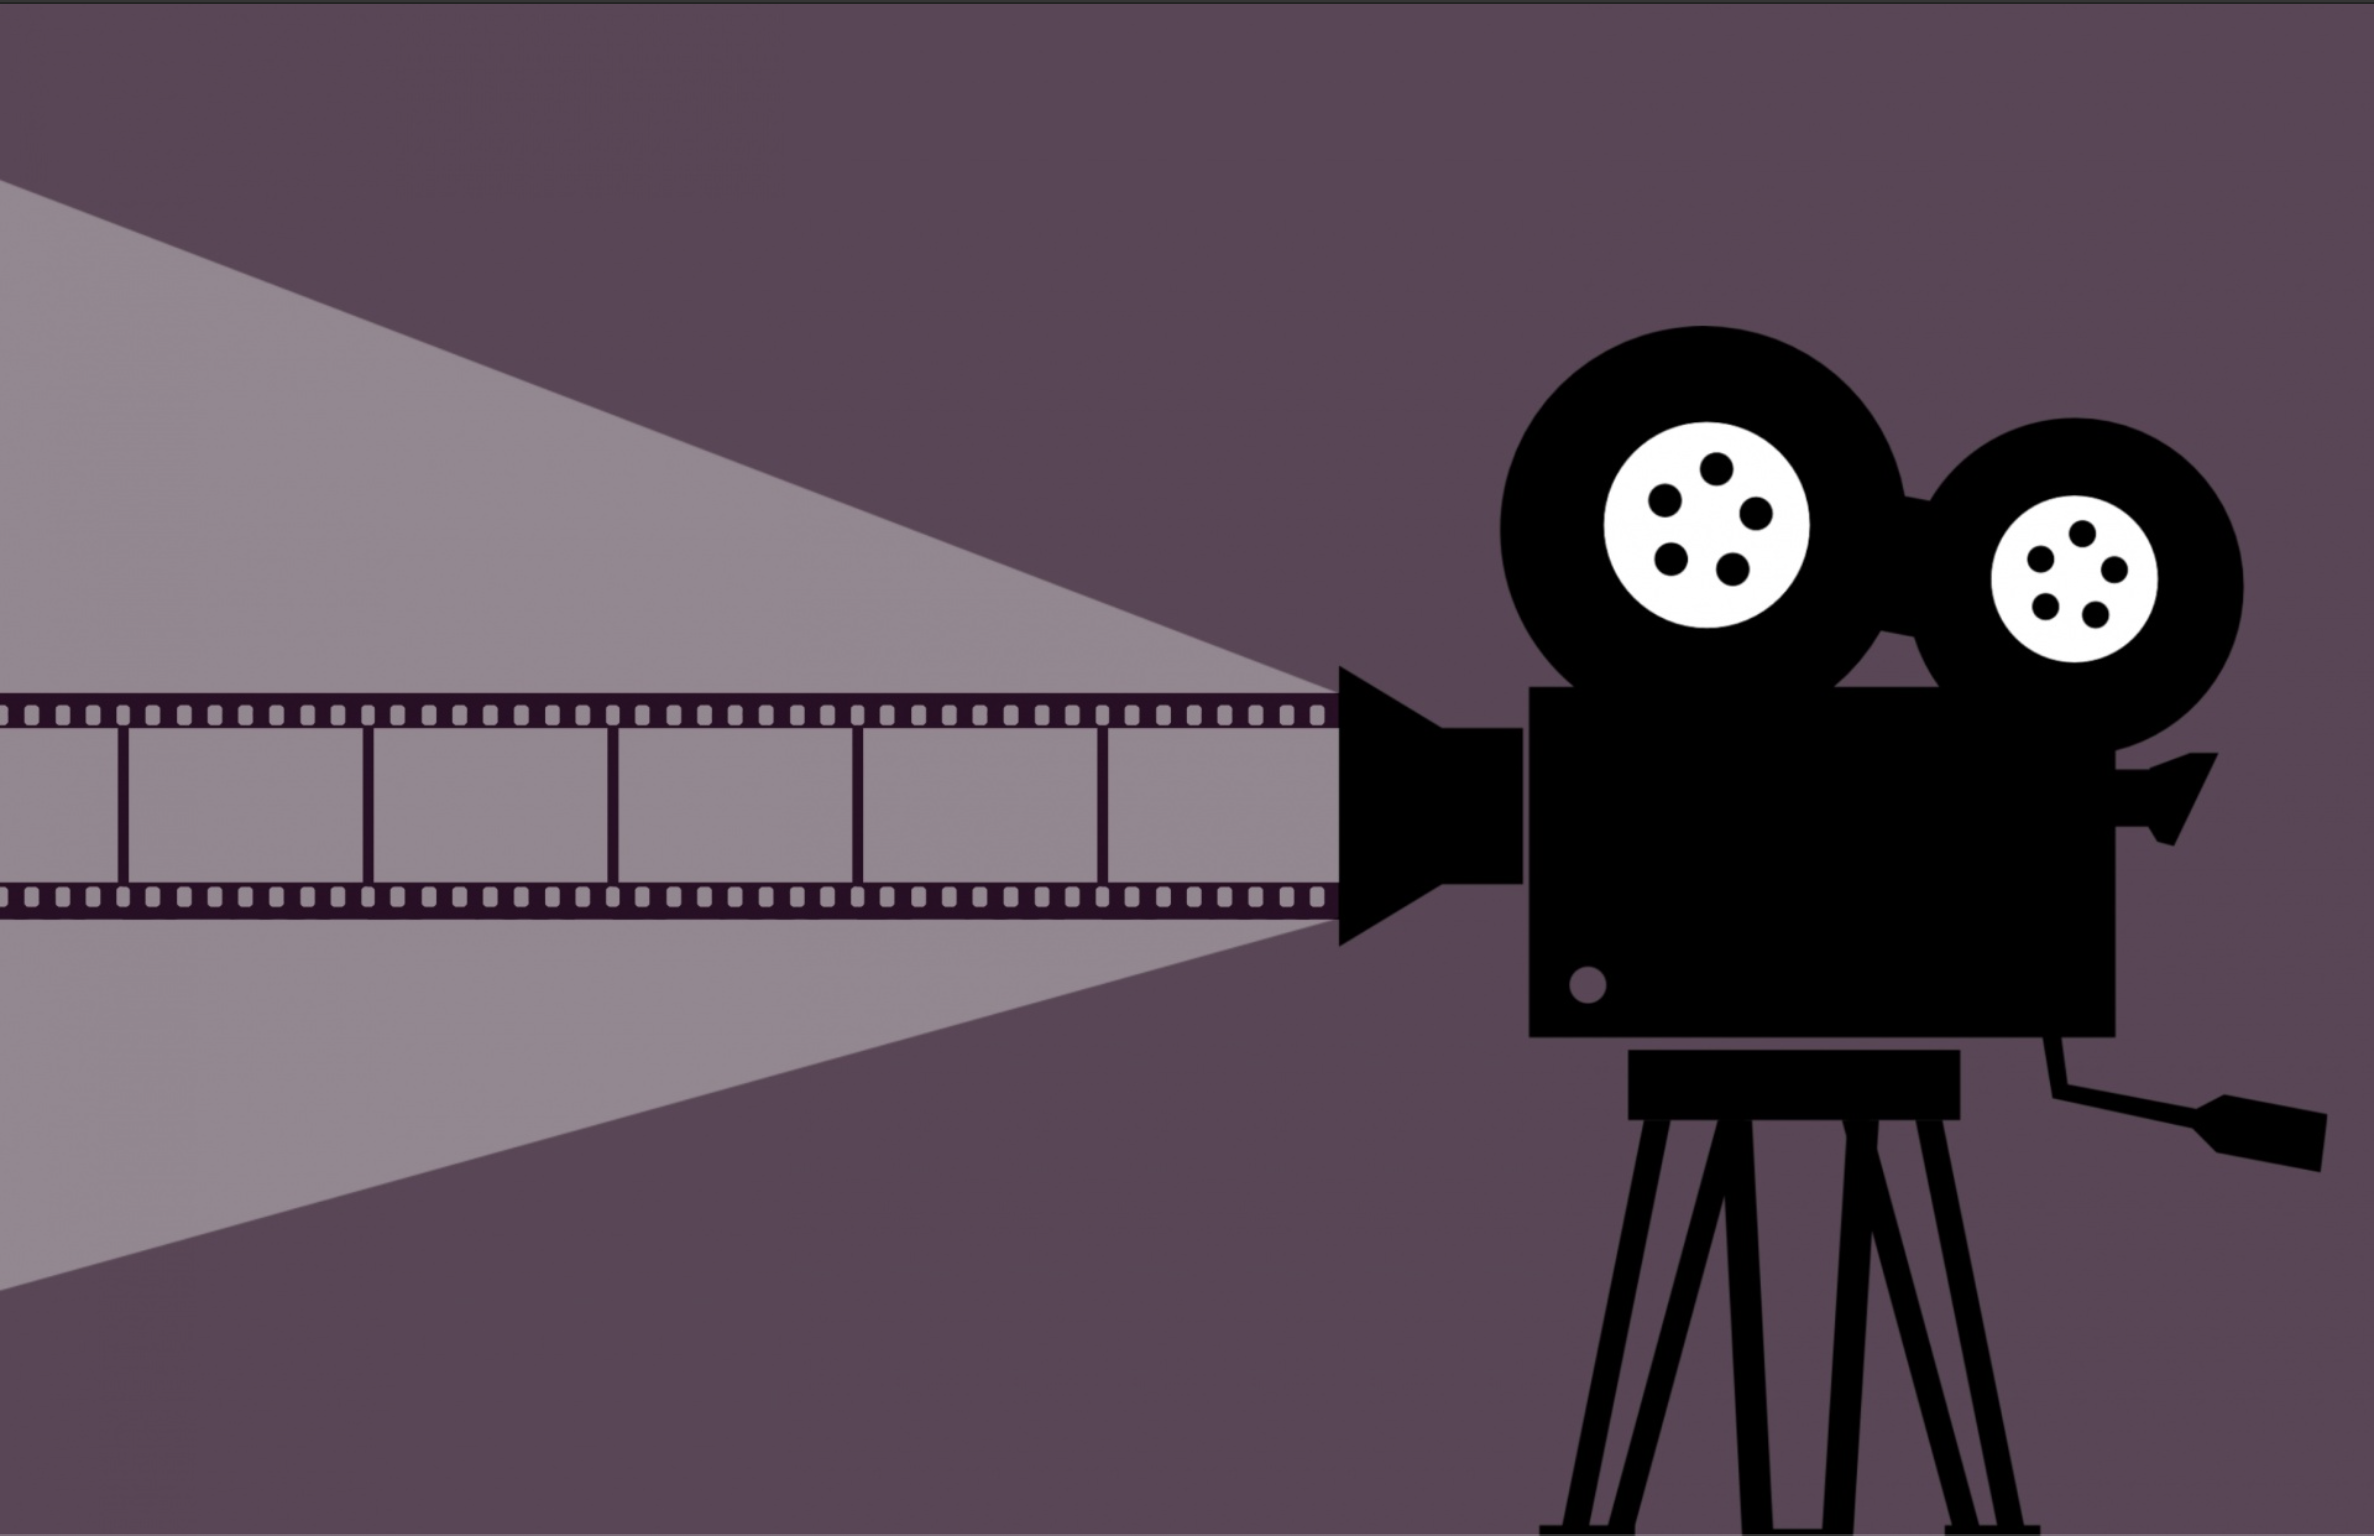

# Section 0: Initialization

## Libraries and Setup

In [ ]:
import random
import numpy as np 
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
np.random.seed(545)

# Section 1: Loading and Cleaning Dataset

In this section, we will download our dataset and clean it up.



First, we want to connect to Google Drive to store our data later.

*  This will create a 'CIS545_2021' folder in the drive, as well as a 'Final_Project' folder within it.


In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# Create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'MyDrive', 'CIS545_2021')
PROJECT_FOLDER=os.path.join(CIS545_FOLDER, 'Final_Project')
os.makedirs(PROJECT_FOLDER, exist_ok=True)

Mounted at /content/gdrive


## Download the dataset
Note: You only to run this part *once* (Skip to **[Retrieve loaded data](#set-retrieve)** after)

---


After connecting to the drive, we download the original dataset.


*   Path to the file should be as follows: /content/gdrive/MyDrive/CIS545_2021/Final_Project/data.zip


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

file_path = os.path.join(PROJECT_FOLDER, "data.zip")

# TODO: change the sharing setting for the file
#if not os.path.isfile(file_path):
gdd.download_file_from_google_drive(file_id='1syfYUbL55w2c-Z0WiF6zDaNiYb0t_TZw',
                                  dest_path=file_path)

## Load the data
Note: You only to run this part *once* (Skip to **[Retrieve loaded data](#set-retrieve)** after)

---



We need to unzip data.zip


*   This will create a 545_data folder in the root directory and have four files (IMDb movies.csv, IMDb names.csv, IMDb title_principals.csv, IMDb ratings.csv). 
*    We will only use **IMDb movies.csv**



In [ ]:
!unzip {file_path}

Archive:  /content/gdrive/MyDrive/CIS545_2021/Final_Project/data.zip
   creating: 545_data/
  inflating: __MACOSX/._545_data     
  inflating: 545_data/IMDb movies.csv  
  inflating: __MACOSX/545_data/._IMDb movies.csv  
  inflating: 545_data/IMDb names.csv  
  inflating: __MACOSX/545_data/._IMDb names.csv  
  inflating: 545_data/IMDb title_principals.csv  
  inflating: __MACOSX/545_data/._IMDb title_principals.csv  
  inflating: 545_data/IMDb ratings.csv  
  inflating: __MACOSX/545_data/._IMDb ratings.csv  


Now, we read the csv file and load to Pandas dataframe.



*   We need to reinitialize the datatypes for columns since each they have a default type of Object



In [ ]:
# Set datatypes for each column
csv_types = {"imdb_title_id": "string", "title": "string", "original_title": "string", "year": "string", "date_published": "string", "genre": "string", "duration": int, "country": "string", "language": "string", "director": "string", "writer": "string", "production_company": "string", "actors": "string", "description": "string", "avg_vote": float, "votes": int, "budget": "string", "usa_gross_income": "string", "worlwide_gross_income": "string", "metascore": float, "reviews_from_users": float, "reviews_from_critics": float}

movies_df = pd.read_csv('545_data/IMDb movies.csv', index_col=False, dtype=csv_types)
# Lowercase the titles to prepare for JOIN operation later with the data scraped from the web
movies_df["title"] = movies_df["title"].str.lower()
movies_df.dtypes

imdb_title_id             string
title                     string
original_title            string
year                      string
date_published            string
genre                     string
duration                   int64
country                   string
language                  string
director                  string
writer                    string
production_company        string
actors                    string
description               string
avg_vote                 float64
votes                      int64
budget                    string
usa_gross_income          string
worlwide_gross_income     string
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [ ]:
movies_df

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,miss jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,<NA>,<NA>,<NA>,NaN,1.0,2.0
1,tt0000574,the story of the kelly gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,<NA>,<NA>,NaN,7.0,7.0
2,tt0001892,den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",<NA>,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,<NA>,<NA>,<NA>,NaN,5.0,2.0
3,tt0002101,cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,<NA>,<NA>,NaN,25.0,3.0
4,tt0002130,l'inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,<NA>,<NA>,<NA>,NaN,31.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,<NA>,<NA>,$ 3507171,NaN,NaN,4.0
85851,tt9911196,de beentjes van sint-hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,<NA>,<NA>,$ 7299062,NaN,6.0,4.0
85852,tt9911774,padmavyuhathile abhimanyu,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,"Vineesh Aaradya, Vineesh Aaradya",RMCC Productions,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",<NA>,7.9,265,<NA>,<NA>,<NA>,NaN,NaN,NaN
85853,tt9914286,sokagin çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",<NA>,6.4,194,<NA>,<NA>,$ 2833,NaN,NaN,NaN


### Webscraping 
Note: You only to run this part *once* (Skip to **[Retrieve loaded data](#set-retrieve)** after)

---



After scanning the dataset, we see that *many* movies are missing world wide gross income.

To see how many were missing exactly, let's count the **number of rows with nulls in the world_wide_gross_income** column.

In [ ]:
movies_df.isnull().sum(axis = 0)

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     64
language                   833
director                    87
writer                    1572
production_company        4455
actors                      69
description               2115
avg_vote                     0
votes                        0
budget                   62145
usa_gross_income         70529
worlwide_gross_income    54839
metascore                72550
reviews_from_users        7597
reviews_from_critics     11797
dtype: int64

From counting the rows with null values each column, we can see that 54839 movies (!!) out of 85855 movies are missing world wide gross income. 

While ~30k movies of data is enough, let's look for ways to see if there is a good way of filling in the missing values. While we can look at methods like value imputation and k-Nearest neighbor, there must be other resources that have these missing values given that there must exist gross incomes for all movies. 

Take a look at this [website](https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time). This website contains worldwide gross income for ~30k movies.



In [ ]:
# Import requests and beautiful soup
!pip3 install requests
!pip3 install beautifulsoup4

To retrieve the gross incomes, we will webscrape the site using Beautiful Soup

*   The code refers to this [tutorial](https://realpython.com/beautiful-soup-web-scraper-python/) for Beautiful Soup

While attempting to load all pages, however, we may run into an issue with connecting to the server (max entries error), so we resolve it by taking a "sleep" and retrieving the data from the site periodically. We referred to this [solution](https://stackoverflow.com/questions/23013220/max-retries-exceeded-with-url-in-requests) to write such part of the code.

In [ ]:
# Running this cell may take about 20 minutes
import requests
from bs4 import BeautifulSoup
import time

# TODO: Save this dataframe as a csv file so that we don't need to run this all cell all the time - takes ~25 minutes to run

# list of dictionaries, where each dictionary represents each movie - this will make loading into the pandas dataframe easier
all_movies_list = []
for i in range(1, 31600, 100):
  # Get baseline URL and append the page number
  URL = 'https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time/' + str(i)
  page = ''
  while page == '':
    try:
        page = requests.get(URL)
        break
    except requests.exceptions.ConnectionError as e:
        print(e)
        print("Connection refused by the server..")
        print("Let me sleep for 5 seconds")
        print("ZZzzzz...")
        time.sleep(5)
        print("Was a nice sleep, now let me continue...")
        continue

  soup = BeautifulSoup(page.content, 'html.parser')
  all_movies = soup.find('tbody')
  movies = all_movies.find_all('tr')
  for movie in movies:
    movie_dict = {}
    results = movie.find_all("td")
    year = results[1].find('a').text
    movie_title = results[2].find('a').text
    worldwide = results[3].text
    domestic = results[4].text
    international = results[5].text
    movie_dict['year_bo'] = year
    # lowercase the titles
    movie_dict['title_bo'] = movie_title.lower()
    # get worldwide, domestic, and internatinoal gross incomes
    movie_dict['worldwide_bo'] = worldwide
    movie_dict['domestic_bo'] = domestic
    movie_dict['international_bo'] = international
    all_movies_list.append(movie_dict)
  print(len(all_movies_list))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [ ]:
# Create boxoffice dataframe
boxoffice_df = pd.DataFrame(all_movies_list)
# Change datatypes from Object to String for these columns
boxoffice_df = boxoffice_df[['year_bo', 'title_bo', 'worldwide_bo', 'domestic_bo', 'international_bo']].astype('string')
boxoffice_df.dtypes

year_bo             string
title_bo            string
worldwide_bo        string
domestic_bo         string
international_bo    string
dtype: object

In [ ]:
boxoffice_df

,year_bo,title_bo,worldwide_bo,domestic_bo,international_bo
0,2009,avatar,"$2,845,899,541","$760,507,625","$2,085,391,916"
1,2019,avengers: endgame,"$2,797,800,564","$858,373,000","$1,939,427,564"
2,1997,titanic,"$2,207,986,545","$659,363,944","$1,548,622,601"
3,2015,star wars ep. vii: the force awakens,"$2,065,478,084","$936,662,225","$1,128,815,859"
4,2018,avengers: infinity war,"$2,044,540,523","$678,815,482","$1,365,725,041"
...,...,...,...,...,...
31528,1962,eva,$10,,$10
31529,2020,before everest,$9,,$9
31530,2019,turbulencia zombi,$6,,$6
31531,2017,asya,$2,,$2


With the dataframe created from the webscraped data, we will now join this dataframe from the movies dataframe we obtained earlier from the data.zip file


*   Given that there may be movies with same titles, let's make sure to join on two columns: **title and year**




In [ ]:
# Join by movie and year. We left join since we want still want to keep movies that had gross incomes in the original movies dataframe.  
merged_movies_df = movies_df.merge(boxoffice_df, how='left', left_on=['title', 'year'], right_on=['title_bo', 'year_bo'])
# Drop movies that don't have worldwide gross incomes in both dataframes (movies_df and boxoffice_df)
merged_movies_drop_na = merged_movies_df.dropna(subset=['worlwide_gross_income', 'worldwide_bo'], how='all')
# Drop 'title_bo' and 'year_bo' since they are duplicates of 'title' and 'year'
merged_movies_drop_na.drop(columns=['title_bo', 'year_bo'], inplace=True)
merged_movies_drop_na

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,worldwide_bo,domestic_bo,international_bo
63,tt0006333,"20,000 leagues under the sea","20,000 Leagues Under the Sea",1916,1916-12-24,"Action, Adventure, Sci-Fi",105,USA,English,Stuart Paton,Jules Verne,Williamson Submarine Film Corporation,"Dan Hanlon, Edna Pendleton, Curtis Benton, All...",A French professor and his daughter accompany ...,6.2,1501,$ 200000,<NA>,<NA>,NaN,28.0,24.0,"$8,000,000","$8,000,000",
79,tt0007183,pikovaya dama,Pikovaya dama,1916,1916-04-01,"Drama, Fantasy, Horror",63,Russia,Russian,Yakov Protazanov,"Alexander Pushkin, Fyodor Otsep",<NA>,"Tamara Duvan, Ivan Mozzhukhin, Vera Orlova, Ni...","While hosting a game of cards one night, Narum...",7.0,610,<NA>,<NA>,$ 144968,NaN,7.0,5.0,"$262,102",,"$262,102"
165,tt0010323,il gabinetto del dottor caligari,Das Cabinet des Dr. Caligari,1920,1920-02-27,"Fantasy, Horror, Mystery",76,Germany,German,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...","Hypnotist Dr. Caligari uses a somnambulist, Ce...",8.1,55601,$ 18000,$ 8811,$ 8811,NaN,237.0,160.0,<NA>,<NA>,<NA>
210,tt0011440,markens grøde,Markens grøde,1921,1921-12-02,Drama,107,Norway,<NA>,Gunnar Sommerfeldt,"Knut Hamsun, Gunnar Sommerfeldt",Christiana Film,"Amund Rydland, Karen Poulsen, Ragna Wettergree...",After the Nobel prize winning Knut Hamsun-nove...,6.6,195,NOK 250000,<NA>,$ 4272,NaN,3.0,3.0,<NA>,<NA>,<NA>
222,tt0011741,suds,Suds,1920,1920-01-27,"Comedy, Drama, Romance",75,USA,English,John Francis Dillon,"Waldemar Young, Richard Bryce",Mary Pickford Company,"Mary Pickford, Albert Austin, Harold Goodwin, ...",A London laundress attempts to rise above her ...,6.3,210,<NA>,<NA>,$ 772155,NaN,9.0,1.0,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85860,tt9905412,ottam,Ottam,2019,2019-03-08,Drama,120,India,Malayalam,Zam,Rajesh k Narayan,Thomas Thiruvalla Films,"Nandu Anand, Roshan Ullas, Manikandan R. Achar...","Set in Trivandrum, the story of Ottam unfolds ...",7.4,494,INR 4000000,<NA>,$ 4791,NaN,1.0,NaN,<NA>,<NA>,<NA>
85863,tt9908390,le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,<NA>,<NA>,$ 3507171,NaN,NaN,4.0,"$3,474,474",,"$3,474,474"
85864,tt9911196,de beentjes van sint-hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,<NA>,<NA>,$ 7299062,NaN,6.0,4.0,"$7,723,484",,"$7,723,484"
85866,tt9914286,sokagin çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",<NA>,6.4,194,<NA>,<NA>,$ 2833,NaN,NaN,NaN,<NA>,<NA>,<NA>


Looking at the merged dataframe, we can that there are actually small inconsistencies between the worldwide gross income from the dataset we downloaded earlier and worldwide gross income from the webscraped data. For example, a movie called *Le lion* has \$3,507,171 from the downloaded data	*vs.* \$3,474,474 from the webscraped data. However, the difference is not too significant, so we will just stick with the value from the downloaded dataset if a movie has both values. 

That's it for loading the data! Before moving on, let's save the dataframe as a csv file to our drive so that we will not need to rerun the previous cells to load our data next time.

In [ ]:
# Saving to the drive
# TODO: Small inconsistencies between the dataset and website -> but negligible since they are within the same range?
loaded_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/loaded_data.csv'
merged_movies_drop_na.to_csv(loaded_data_path)

<a name="set-retrieve"></a>
### Retrieve loaded data


If you have already run the previous cells for downloading and webscraping the data, simply run this cell to retrieve loaded_data.csv file that was created previously.

In [ ]:
# Run this cell to reload the dataframe from the csv file
csv2_types = {"imdb_title_id": "string", "title": "string", "original_title": "string", "year": "string", "date_published": "string", "genre": "string", "duration": int, "country": "string", "language": "string", "director": "string", "writer": "string", "production_company": "string", "actors": "string", "description": "string", "avg_vote": float, "votes": int, "budget": "string", "usa_gross_income": "string", "worlwide_gross_income": "string", "metascore": float, "reviews_from_users": float, "reviews_from_critics": float, "worldwide_bo": "string"}
loaded_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/loaded_data.csv'
movies_df = pd.read_csv(loaded_data_path, dtype=csv2_types)

In [ ]:
# Checking 
movies_df[movies_df["title"] == "avatar"]
movies_df.dtypes

Unnamed: 0                 int64
imdb_title_id             string
title                     string
original_title            string
year                      string
date_published            string
genre                     string
duration                   int64
country                   string
language                  string
director                  string
writer                    string
production_company        string
actors                    string
description               string
avg_vote                 float64
votes                      int64
budget                    string
usa_gross_income          string
worlwide_gross_income     string
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
worldwide_bo              string
domestic_bo               object
international_bo          object
dtype: object

## Data Cleaning

Now we will clean the data. This includes fixing misspellings, changing some column dtypes to Datetime object, combining the worldwide income columns into one and dropping the other income columns, dropping commas and dollar signs, and more. We want to make the data as clean and consistent as possible so that we can proceed with exploring the data and modeling

In [ ]:
# Fix spelling of column name 'worlwide_gross_income'
movies_df.rename(columns={'worlwide_gross_income': 'worldwide_gross_income'}, inplace=True)

In [ ]:
# Change 'year' and 'date_published' columns to Date Time Objects. 
movies_df['year'] = pd.to_datetime(movies_df['year'], format='%Y-%m-%d', errors = 'coerce').dt.year
movies_df.dropna(subset=['year'], inplace=True)
movies_df['date_published'] = pd.to_datetime(movies_df['date_published'], errors = 'coerce')
movies_df.dropna(subset=['date_published'], inplace=True)
movies_df.dtypes

Unnamed: 0                         int64
imdb_title_id                     string
title                             string
original_title                    string
year                               int64
date_published            datetime64[ns]
genre                             string
duration                           int64
country                           string
language                          string
director                          string
writer                            string
production_company                string
actors                            string
description                       string
avg_vote                         float64
votes                              int64
budget                            string
usa_gross_income                  string
worldwide_gross_income            string
metascore                        float64
reviews_from_users               float64
reviews_from_critics             float64
worldwide_bo                      string
domestic_bo     

In [ ]:
# Combine 'worldwide_gross_income' column with 'worldwide_bo' (from webscraping)
def combine_ww_incomes(x):
  if pd.isna(x['worldwide_gross_income']):
    #x['worldwide_gross_income'].isnull():
    x['ww_gross_income'] = x['worldwide_bo']
  else:
    x['ww_gross_income'] = x['worldwide_gross_income']
  return x

movies_df = movies_df.apply(combine_ww_incomes, axis=1)
movies_df.dtypes

Unnamed: 0                         int64
imdb_title_id                     object
title                             object
original_title                    object
year                               int64
date_published            datetime64[ns]
genre                             object
duration                           int64
country                           object
language                          object
director                          object
writer                            object
production_company                object
actors                            object
description                       object
avg_vote                         float64
votes                              int64
budget                            object
usa_gross_income                  object
worldwide_gross_income            object
metascore                        float64
reviews_from_users               float64
reviews_from_critics             float64
worldwide_bo                      object
domestic_bo     

In [ ]:
# Drop extra budget/income columns such as the ones that are duplicates after combining and the ones that have too many NA values
movies_df.drop(columns=['budget', 'usa_gross_income', 'worldwide_gross_income', 'worldwide_bo', 'domestic_bo', 'international_bo'], inplace=True)

In [ ]:
# Get rid of '$' and ',' signs in 'ww_gross_income' and convert to float dtype. 
# We realized that not every value was in dollars some were in GBP/other currencies. 
# So we used a try catch to catch values that couldn't be converted to float and convered them to None so we could drop them.

def removeDollar(x):
  x = x.replace('$', "")
  x = x.replace(',', "")
  try:
    x = float(x)
  except ValueError:
    x = None
  return x

movies_df['ww_gross_income'] = movies_df['ww_gross_income'].apply(lambda x: removeDollar(x))
movies_df.dropna(subset=['ww_gross_income'], inplace=True)

In [ ]:
# Applying operations changed the String datatypes to Objects, so we change the datatypes back to String
movies_df[["imdb_title_id", "title", "original_title", "genre", "country", "language", "director", "writer", "production_company", "actors", "description"]] = movies_df[["imdb_title_id", "title", "original_title", "genre", "country", "language", "director", "writer", "production_company", "actors", "description"]].astype('string') 
movies_df.dtypes

Unnamed: 0                       int64
imdb_title_id                   string
title                           string
original_title                  string
year                             int64
date_published          datetime64[ns]
genre                           string
duration                         int64
country                         string
language                        string
director                        string
writer                          string
production_company              string
actors                          string
description                     string
avg_vote                       float64
votes                            int64
metascore                      float64
reviews_from_users             float64
reviews_from_critics           float64
ww_gross_income                float64
dtype: object

Now that we have cleaned our dataset, let's save it as a csv file so that we will not need to rerun these cells again next time. 

In [ ]:
cleaned_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/cleaned_data.csv'
movies_df.to_csv(cleaned_data_path)

# Section 2: Exploring Dataset and Feature Engineering

In this section, we will be doing exploratory data analysis and feature engineering to get a better understanding of our data and prepare for building our model later


## Pandas vs. Spark
We have ~30k rows of data, which is not too large. However, before we start analyzing the data, we will still experiment and see if using Spark to distribute our data will speed up the process significantly.
 
*   If Pandas operations take too long, we want to take advantage of Spark
*   At the same time, we don't want to unnecessarily use Spark and waste resources


 

### Spark Initialization



First, let's connect to Spark!

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
%load_ext sparkmagic.magics

As always, let's install all of the necessary packages.



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f
import os
os.environ['SPARK_HOME'] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
#misc
import gc
import warnings

# JSON parsing
import json

# SQLite RDBMS
import sqlite3

import os
os.environ['SPARK_HOME'] = "/content/spark-3.1.1-bin-hadoop3.2"
import pyspark
from pyspark.sql import SQLContext

Finally, let's start our Spark session!

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

<a name="set-partition"></a>
**Note: We added the cell below after seeing that SparkSQL was running slower than PandaSQL. We thought that by making the partitions smaller from 200 (default value) to 10, perhaps the process will get faster since there will be less overhead.

In [ ]:
spark.conf.set("spark.sql.shuffle.partitions", 10)

### Load data

Now that we have Spark session fully initialized, let's load the cleaned_data.csv file into the Spark dataframe

In [ ]:
spark_reader = spark.read.option("header", True).format("csv")
movies_sdf = spark_reader.load(cleaned_data_path)

In [ ]:
movies_sdf.createOrReplaceTempView('movies_view')
movies_sdf.show(10)
movies_sdf.dtypes

+---+----------+-------------+--------------------+--------------------+----+--------------+--------------------+--------+-------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+------+---------+------------------+--------------------+---------------+
|_c0|Unnamed: 0|imdb_title_id|               title|      original_title|year|date_published|               genre|duration|country|     language|            director|              writer|  production_company|              actors|         description|avg_vote| votes|metascore|reviews_from_users|reviews_from_critics|ww_gross_income|
+---+----------+-------------+--------------------+--------------------+----+--------------+--------------------+--------+-------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+------+---------+------------------+--------------------+---------------+
|  0

[('_c0', 'string'),
 ('Unnamed: 0', 'string'),
 ('imdb_title_id', 'string'),
 ('title', 'string'),
 ('original_title', 'string'),
 ('year', 'string'),
 ('date_published', 'string'),
 ('genre', 'string'),
 ('duration', 'string'),
 ('country', 'string'),
 ('language', 'string'),
 ('director', 'string'),
 ('writer', 'string'),
 ('production_company', 'string'),
 ('actors', 'string'),
 ('description', 'string'),
 ('avg_vote', 'string'),
 ('votes', 'string'),
 ('metascore', 'string'),
 ('reviews_from_users', 'string'),
 ('reviews_from_critics', 'string'),
 ('ww_gross_income', 'string')]

### Performance comparison

For comparison, we will look specifically at their performance on SQL queries. The sample query we will use involves querying for movies published after 1999 and grouping those movies based on country.

We will first start out by testing with Spark SQL

In [ ]:
import time
spark_sql = """
                SELECT movies_year.country, COUNT(*) AS count
                FROM 
                  (SELECT *
                   FROM movies_view
                   WHERE YEAR(TO_DATE(movies_view.year)) > 2000 
                  ) AS movies_year
                GROUP BY movies_year.country
                ORDER BY count DESC
             """
# start the timer
start_time = time.time()
sqlContext.sql(spark_sql).show()
# calculate the time difference
spark_time = time.time() - start_time

+---------------+-----+
|        country|count|
+---------------+-----+
|            USA| 4345|
|          India| 1791|
|         France| 1252|
|          Japan| 1073|
|    South Korea|  821|
|         Turkey|  711|
|          Italy|  703|
|             UK|  669|
|        Germany|  607|
|          Spain|  593|
|         Russia|  565|
|      Hong Kong|  343|
|          China|  339|
|         Brazil|  306|
|         Canada|  296|
|France, Belgium|  290|
|      Australia|  261|
|         Poland|  260|
|    Netherlands|  257|
|         Mexico|  231|
+---------------+-----+
only showing top 20 rows



Next, we will compute the same query with PandaSQL

In [ ]:
# download pandasql
!pip install pandasql
import pandasql as ps

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=94b862ce4743da644b2430b23e2e2de63842da08137e4746f06a3b3569823eec
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
pandas_sql = """
                SELECT movies_year.country, COUNT(*) AS count
                FROM 
                  (SELECT *
                   FROM movies_df
                   WHERE movies_df.year > 2000 
                  ) AS movies_year
                GROUP BY movies_year.country
                ORDER BY count DESC
             """
# start the timer
start_time = time.time()
movies_test_df = ps.sqldf(pandas_sql, locals())
# calculate the time difference
pandas_time = time.time() - start_time
movies_test_df

,country,count
0,USA,4345
1,India,1791
2,France,1252
3,Japan,1073
4,South Korea,821
...,...,...
2936,"Venezuela, Cuba, France",1
2937,"Venezuela, Uruguay, Peru",1
2938,"Vietnam, Canada",1
2939,"Vietnam, South Korea",1


In [ ]:
# Find the ratio between the time it took for pandas and spark
# If ratio > 1, spark is faster. If ratio < 1, pandas is faster. If ratio = 1, they took the same time.
time_ratio = pandas_time/spark_time
time_ratio

0.30841566228597855

Interestingly, we see that Pandas is actually *faster* than Spark. It takes almost half the time that Spark takes,  which may be due to our dataset being too small to fully take advantage of distributing the data

To further analyze, we try changing the [number of partitions](#set-partition) for Spark from 200 to 10, in an attempt to decrease the overhead work. However, this results in the similar ratio as before. Thus, we note that **Pandas is sufficient** for our dataset, as the significant overhead Spark adds for its functionalities, such as parallelism and fault tolerance, is not worth according to the ratio we obtain above.

## Exploratory Data Analysis

### Sentiment analysis

Looking at the description column, we see that its values are not very useful as a feature currently. 


*   Let's analyze the description column by doing a sentiment analysis. While sentiments can implicitly be revealed through other features like genre, we will use sentiment analysis to categorize the movies into three groups(positive, neutral, and negative) more clearly and easily. 

In [ ]:
# How the description column currently looks like
movies_df['description']

0        A French professor and his daughter accompany ...
1        While hosting a game of cards one night, Narum...
2        Hypnotist Dr. Caligari uses a somnambulist, Ce...
3        After the Nobel prize winning Knut Hamsun-nove...
4        A London laundress attempts to rise above her ...
                               ...                        
31663    Set in Trivandrum, the story of Ottam unfolds ...
31664    A psychiatric hospital patient pretends to be ...
31665    A middle-aged veterinary surgeon believes his ...
31666                                                 <NA>
31667    Pep, a 13-year-old boy, is in love with a girl...
Name: description, Length: 31607, dtype: string

In [ ]:
# installing Afinn package
!pip install afinn

     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp37-none-any.whl size=53451 sha256=a8e435ad14756df1ba413f5258d13f797d0cc11d1efc4db23d259328327bca4a
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [ ]:
# set up afinn 
from afinn import Afinn
afinn = Afinn(language='en')
movies_df.dtypes

Unnamed: 0                       int64
imdb_title_id                   string
title                           string
original_title                  string
year                             int64
date_published          datetime64[ns]
genre                           string
duration                         int64
country                         string
language                        string
director                        string
writer                          string
production_company              string
actors                          string
description                     string
avg_vote                       float64
votes                            int64
metascore                      float64
reviews_from_users             float64
reviews_from_critics           float64
ww_gross_income                float64
dtype: object

In [ ]:
# Give sentiment score for each description
def sentiment_analyze(x):
  # skip rows with <NA>
  if not pd.isna(x):
    return afinn.score(x)

movies_df['sentiment_score'] = movies_df['description'].apply(sentiment_analyze)

In [ ]:
# Based on the sentiment score, label each movie (positive, negative, or neutral)
def label_sentiment(x):
  if x > 0:
    return "positive"
  elif x < 0:
    return "negative"
  else:
    return "neutral"
movies_df['sentiment'] = movies_df['sentiment_score']. apply(label_sentiment).astype("string")

In [ ]:
movies_df.dtypes

Unnamed: 0                       int64
imdb_title_id                   string
title                           string
original_title                  string
year                             int64
date_published          datetime64[ns]
genre                           string
duration                         int64
country                         string
language                        string
director                        string
writer                          string
production_company              string
actors                          string
description                     string
avg_vote                       float64
votes                            int64
metascore                      float64
reviews_from_users             float64
reviews_from_critics           float64
ww_gross_income                float64
sentiment_score                float64
sentiment                       string
dtype: object

In [ ]:
movies_df

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,ww_gross_income,sentiment_score,sentiment
0,63,tt0006333,"20,000 leagues under the sea","20,000 Leagues Under the Sea",1916,1916-12-24,"Action, Adventure, Sci-Fi",105,USA,English,Stuart Paton,Jules Verne,Williamson Submarine Film Corporation,"Dan Hanlon, Edna Pendleton, Curtis Benton, All...",A French professor and his daughter accompany ...,6.2,1501,NaN,28.0,24.0,8000000.0,3.0,positive
1,79,tt0007183,pikovaya dama,Pikovaya dama,1916,1916-04-01,"Drama, Fantasy, Horror",63,Russia,Russian,Yakov Protazanov,"Alexander Pushkin, Fyodor Otsep",<NA>,"Tamara Duvan, Ivan Mozzhukhin, Vera Orlova, Ni...","While hosting a game of cards one night, Narum...",7.0,610,NaN,7.0,5.0,144968.0,-2.0,negative
2,165,tt0010323,il gabinetto del dottor caligari,Das Cabinet des Dr. Caligari,1920,1920-02-27,"Fantasy, Horror, Mystery",76,Germany,German,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...","Hypnotist Dr. Caligari uses a somnambulist, Ce...",8.1,55601,NaN,237.0,160.0,8811.0,-1.0,negative
3,210,tt0011440,markens grøde,Markens grøde,1921,1921-12-02,Drama,107,Norway,<NA>,Gunnar Sommerfeldt,"Knut Hamsun, Gunnar Sommerfeldt",Christiana Film,"Amund Rydland, Karen Poulsen, Ragna Wettergree...",After the Nobel prize winning Knut Hamsun-nove...,6.6,195,NaN,3.0,3.0,4272.0,-2.0,negative
4,222,tt0011741,suds,Suds,1920,1920-01-27,"Comedy, Drama, Romance",75,USA,English,John Francis Dillon,"Waldemar Young, Richard Bryce",Mary Pickford Company,"Mary Pickford, Albert Austin, Harold Goodwin, ...",A London laundress attempts to rise above her ...,6.3,210,NaN,9.0,1.0,772155.0,7.0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,85860,tt9905412,ottam,Ottam,2019,2019-03-08,Drama,120,India,Malayalam,Zam,Rajesh k Narayan,Thomas Thiruvalla Films,"Nandu Anand, Roshan Ullas, Manikandan R. Achar...","Set in Trivandrum, the story of Ottam unfolds ...",7.4,494,NaN,1.0,NaN,4791.0,0.0,neutral
31664,85863,tt9908390,le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,4.0,3507171.0,-2.0,negative
31665,85864,tt9911196,de beentjes van sint-hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,6.0,4.0,7299062.0,-3.0,negative
31666,85866,tt9914286,sokagin çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",<NA>,6.4,194,NaN,NaN,NaN,2833.0,NaN,neutral


### Plotting Graphs

First things first, let's install seaborn package to create figures later

In [ ]:
!pip install seaborn --user

In [ ]:
import seaborn as sns

Now we will display portions of the data in a series of graphs to gain a better understanding of some of the categorical data and visualize the spread before modeling. 

First, we will look at the distribution of worldwide gross incomes. We expect there to be a large spread with right skew as there will be many outliers (few of the *very* successful movies)

Text(0.5, 1.0, 'Worldwide Gross Income Distribution')

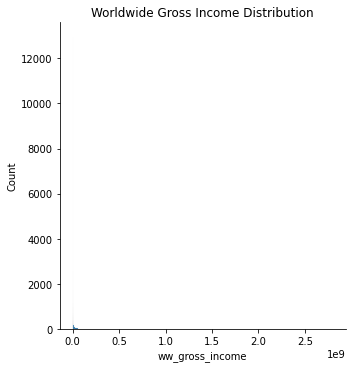

In [ ]:
sns.displot(data=movies_df['ww_gross_income'])
plt.title("Worldwide Gross Income Distribution")

We see that due to some outliers, the scaling is very off. 

*   Let's apply *log* to rescale our data better.

Text(0.5, 1.0, 'Worldwide Gross Income Distribution')

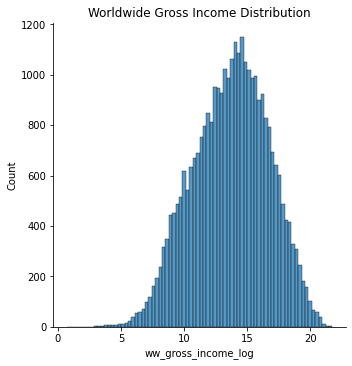

In [ ]:
# apply log(base e) to the worldwide gross income column
movies_df['ww_gross_income_log'] = np.log(movies_df['ww_gross_income']+1)
sns.displot(data=movies_df['ww_gross_income_log'])
plt.title("Worldwide Gross Income Distribution")

We see a normal distribution after log scaling our data. We also observe some very low values at the left tail.

Next, we will dive deeper into our sentiment analysis findings and see what observations we can make.

Text(0.5, 1.0, 'Spread of Sentiment Analysis')

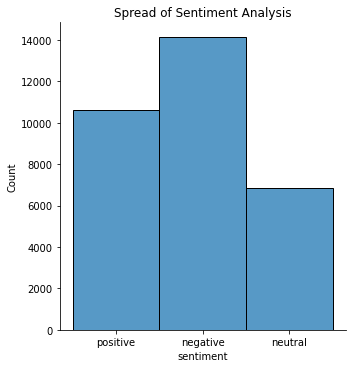

In [ ]:
# This plot displays how many film descriptions fit under each bucket of sentiment analysis - positive, negative, neutral.

sns.displot(data=movies_df, x='sentiment')
plt.title("Spread of Sentiment Analysis")

We see from the above plot that most movies (about 14000) seem to have a negative sentiment description. 

Next, it would be interesting to see if we can see any initial trends between worldwide income and sentiment analysis.


Text(0.5, 1.0, 'Worldwide Gross Income Based on Description Sentiment')

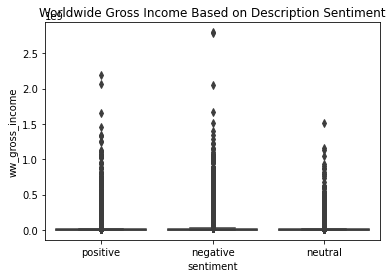

In [ ]:
# This graph will plot films based on their description sentiment and worldwide income.
sns.boxplot(data=movies_df, x='sentiment', y='ww_gross_income')
plt.title("Worldwide Gross Income Based on Description Sentiment")

The spread of the worldwide gross income appears to be quite large, so it is difficult to see what is happening in that graph.

We can apply a log transformation to the income data to help us better visualize the spread.

([<matplotlib.axis.YTick at 0x7f7c777af090>,
 <a list of 26 Text major ticklabel objects>)

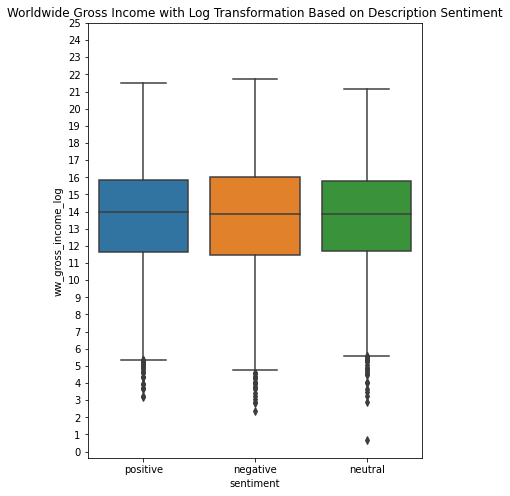

In [ ]:
# Make the boxplot again
plt.figure(figsize=(6, 8))
sns.boxplot(data=movies_df, x='sentiment', y='ww_gross_income_log')
plt.title("Worldwide Gross Income with Log Transformation Based on Description Sentiment")
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])


All three box plots align very closely to each other. They all have the log of income right around 14. There appear to be a lot of outliers on the lower bound, some especially far out for the neutral sentiment description movies.

Due to the large amount of outliers, we are curious to see what the standard deviations are for each of the three categories.

In [ ]:
# This finds the standard deviation of all incomes
x = np.std(movies_df['ww_gross_income'])
print("The standard deviation of all incomes is ")
print(x)


# This is to separate the worldwide gross incomes into 3 separate lists based on sentiment to then find their respective standard deviations.
positive_list = []
negative_list = []
neutral_list = []

def build_lists(x):
  if x['sentiment'] == 'positive':
    positive_list.append(x['ww_gross_income'])
  elif x['sentiment'] == 'negative':
    negative_list.append(x['ww_gross_income'])
  elif x['sentiment'] == 'neutral':
    neutral_list.append(x['ww_gross_income'])
  return x

movies_df.apply(lambda x: build_lists(x), axis=1)

x1 = np.std(positive_list)
print("The standard deviation of positive sentiment incomes is ")
print(x1)
x2 = np.std(negative_list)
print("The standard deviation of negative sentiment incomes is ")
print(x2)
x3 = np.std(neutral_list)
print("The standard deviation of neutral sentiment incomes is ")
print(x3)


The standard deviation of all incomes is 
87952662.52788459
The standard deviation of positive sentiment incomes is 
87144904.6285516
The standard deviation of negative sentiment incomes is 
96919444.58848648
The standard deviation of neutral sentiment incomes is 
67056061.71770279


We find that the standard deviations vary greatly for neutral sentiment compared to positive/negative. Neutral sentiment seems to have a much smaller standard deviation so perhaps it is more stable. We also see from the box plots that neutral sentiment has the lowest max and the lowest min (including outliers). It is important to note that the sentiment analysis is just one feature that we are analyzing, and these are simply observations but we cannot make any final judgements based on just one variable.



We will now see if there is any correlation between the worldwide gross income and genre. We will first see which genres are most popular. Since there are too many genres to fit all of them, we will look at *top 15 genres* that frequents our data the most. 

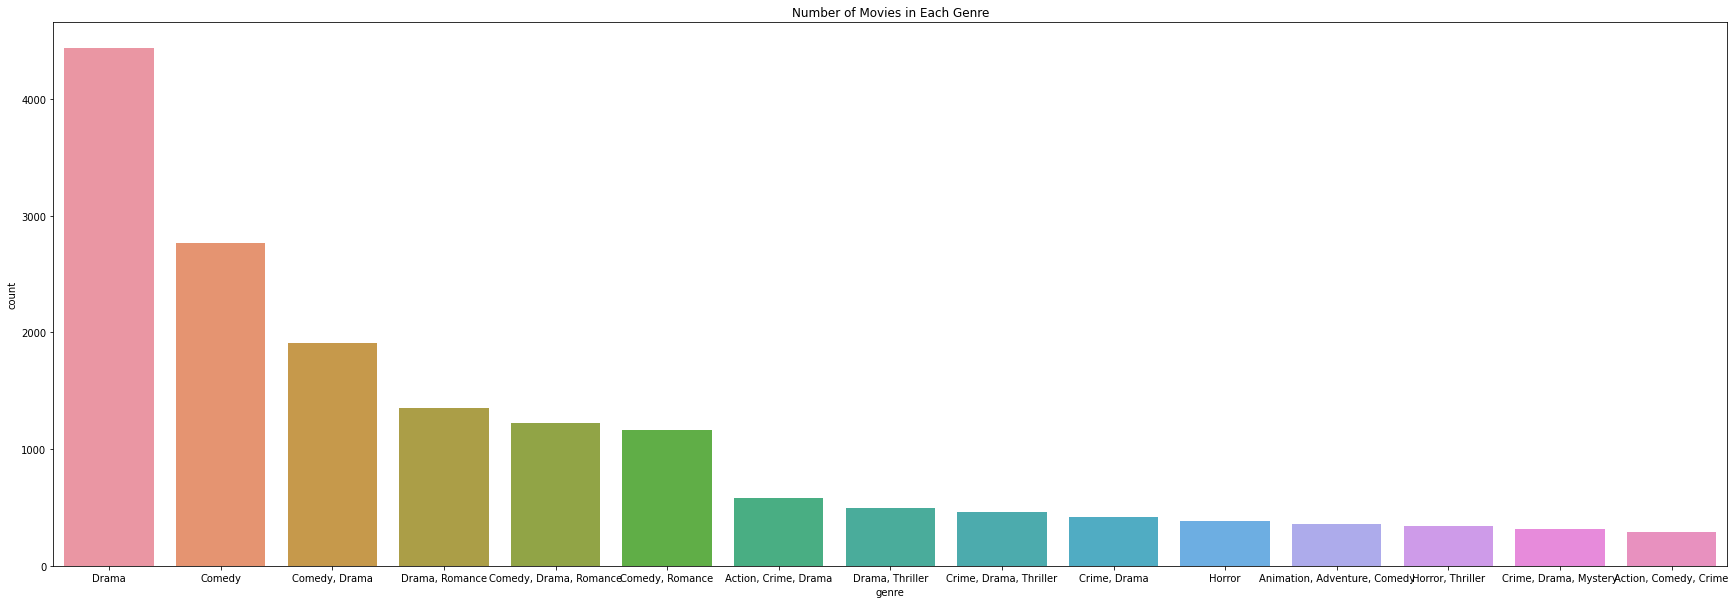

In [ ]:
plt.figure(figsize=(30, 10))
movies_df_genre = movies_df.value_counts(['genre']).reset_index(name='count')
# since movies_df_genre now only has two colums (genre & count), we do inner join to get all columns for movies with top 15 genres
movies_df_genre_top = movies_df_genre.sort_values(['count'], ascending=False).head(15).merge(movies_df, left_on='genre', right_on='genre')
sns.barplot(x="genre", y="count" , data=movies_df_genre_top)
plt.title("Number of Movies in Each Genre")
plt.show()

According to our plot above, it seems to be that there are many movies in Drama and Comedy genres. Let's see if there is any notable relatinoship between these top 15 genres and worldwide gross income

In [ ]:
movies_df_genre_top

,genre,count,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,ww_gross_income,sentiment_score,sentiment,ww_gross_income_log
0,Drama,4437,210,tt0011440,markens grøde,Markens grøde,1921,1921-12-02,107,Norway,<NA>,Gunnar Sommerfeldt,"Knut Hamsun, Gunnar Sommerfeldt",Christiana Film,"Amund Rydland, Karen Poulsen, Ragna Wettergree...",After the Nobel prize winning Knut Hamsun-nove...,6.6,195,NaN,3.0,3.0,4272.0,-2.0,negative,8.360071
1,Drama,4437,254,tt0012397,little lord fauntleroy,Little Lord Fauntleroy,1921,1921-09-15,112,USA,English,"Alfred E. Green, Jack Pickford","Frances Hodgson Burnett, Bernard McConville",Mary Pickford Company,"Mary Pickford, Claude Gillingwater, Joseph J. ...",An American boy turns out to be the long-lost ...,6.7,276,NaN,7.0,4.0,1108882.0,0.0,neutral,13.918864
2,Drama,4437,2361,tt0027489,césar,César,1936,1936-11-11,168,France,French,Marcel Pagnol,Marcel Pagnol,Les Films Marcel Pagnol,"Raimu, Pierre Fresnay, Fernand Charpin, Orane ...","Honoré Panisse is dying, cheerfully, with frie...",7.6,1268,NaN,11.0,22.0,8262.0,-1.0,negative,9.019543
3,Drama,4437,2394,tt0027672,le sorelle del gion,Gion no shimai,1936,1936-10-15,69,Japan,Japanese,Kenji Mizoguchi,"Aleksandr Kuprin, Kenji Mizoguchi",Daiichi Eiga,"Isuzu Yamada, Yôko Umemura, Benkei Shiganoya, ...",Two geisha sisters lead a hard life in the Gio...,7.5,2358,NaN,18.0,29.0,17807.0,-2.0,negative,9.787403
4,Drama,4437,3531,tt0032384,da mayerling a sarajevo,De Mayerling à Sarajevo,1940,1940-05-01,95,France,French,Max Ophüls,"Carl Zuckmayer, Marcelle Maurette",B.U.P. Française,"Edwige Feuillère, John Lodge, Aimé Clariond, J...","In the late 1800's, Franz Ferdinand, heir to t...",6.7,221,NaN,4.0,5.0,5247.0,-2.0,negative,8.565602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16504,"Action, Comedy, Crime",292,83661,tt8043306,teefa in trouble,Teefa in Trouble,2018,2018-07-20,155,Pakistan,Urdu,Ahsan Rahim,"Ahsan Rahim, Ahsan Rahim",Benetone Films,"Ali Zafar, Maya Ali, Mehmood Aslam, Nayyar Eja...",Teefa goes to Poland to get Anya to Pakistan t...,7.3,3157,NaN,106.0,5.0,324633.0,-2.0,negative,12.690454
16505,"Action, Comedy, Crime",292,84168,tt8367814,the gentlemen,The Gentlemen,2019,2020-01-01,113,"UK, USA",English,Guy Ritchie,"Guy Ritchie, Ivan Atkinson",STX Films,"Matthew McConaughey, Charlie Hunnam, Michelle ...",An American expat tries to sell off his highly...,7.9,179054,51.0,1167.0,260.0,115171795.0,-3.0,negative,18.561935
16506,"Action, Comedy, Crime",292,84392,tt8523334,nicky larson et le parfum de cupidon,Nicky Larson et le parfum de Cupidon,2018,2019-02-06,91,France,"French, English, Spanish",Philippe Lacheau,"Julien Arruti, Julien Arruti",Axel Films,"Philippe Lacheau, Élodie Fontan, Tarek Boudali...","Nicky Larson, the best private investigator in...",6.5,3124,NaN,19.0,7.0,14702744.0,3.0,positive,16.503545
16507,"Action, Comedy, Crime",292,84476,tt8591986,uma quase dupla,Uma Quase Dupla,2018,2018-07-19,90,Brazil,Portuguese,Marcus Baldini,"Daniel Furlan, Fernando Fraiha",Biônica Filmes,"Tatá Werneck, Ilana Kaplan, Cauã Reymond, Loui...",Keyla the police officer and the unprepared de...,5.2,422,NaN,3.0,3.0,1971739.0,-2.0,negative,14.494427


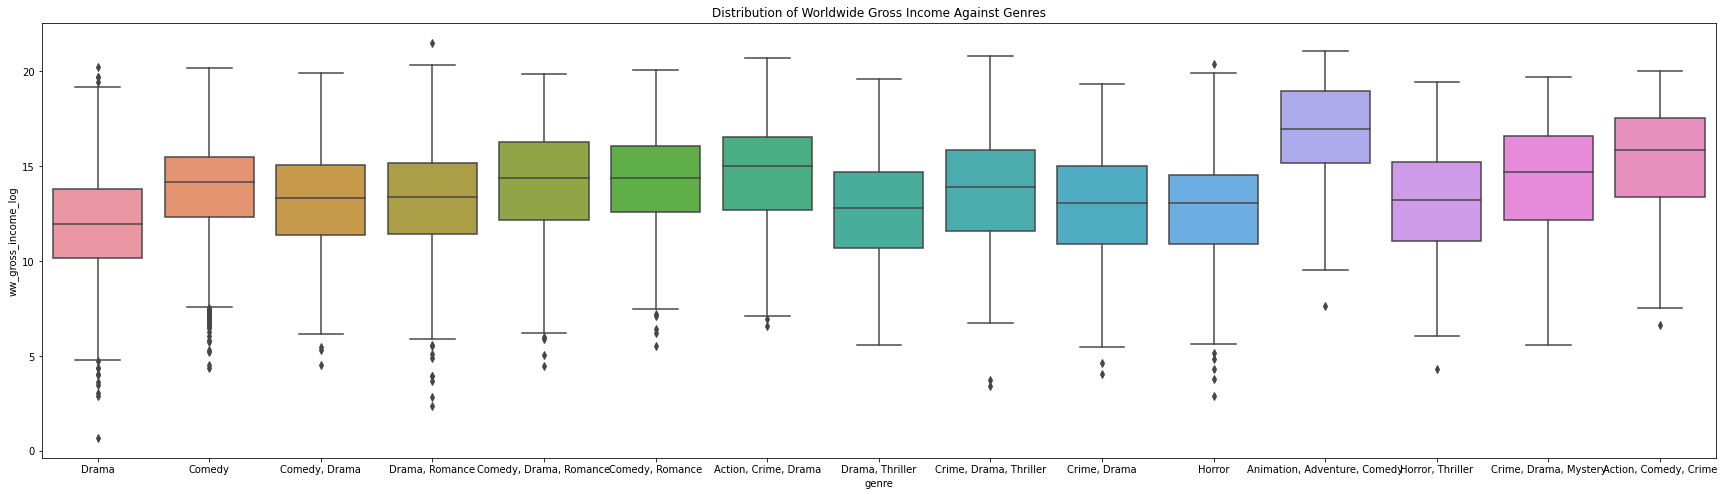

In [ ]:
plt.figure(figsize=(30,8))
sns.boxplot(x="genre", y="ww_gross_income_log", data=movies_df_genre_top)
plt.title("Distribution of Worldwide Gross Income Against Genres")
plt.show()

As can see above, drama and comedy, though they were most popular in the dataset, their medians are not the highest. Even if we look the outliers, it is not the highest. The highest median is in fact animation, adventure, and comedy genre, followed by action, comedy, and crime. This is not so surprising, as we can easily think of very successful animations like Toy Story and Frozen. This is also the same for action movies, such as Marvel movies.

In [ ]:
movies_df

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,ww_gross_income,sentiment_score,sentiment,ww_gross_income_log
0,63,tt0006333,"20,000 leagues under the sea","20,000 Leagues Under the Sea",1916,1916-12-24,"Action, Adventure, Sci-Fi",105,USA,English,Stuart Paton,Jules Verne,Williamson Submarine Film Corporation,"Dan Hanlon, Edna Pendleton, Curtis Benton, All...",A French professor and his daughter accompany ...,6.2,1501,NaN,28.0,24.0,8000000.0,3.0,positive,15.894952
1,79,tt0007183,pikovaya dama,Pikovaya dama,1916,1916-04-01,"Drama, Fantasy, Horror",63,Russia,Russian,Yakov Protazanov,"Alexander Pushkin, Fyodor Otsep",<NA>,"Tamara Duvan, Ivan Mozzhukhin, Vera Orlova, Ni...","While hosting a game of cards one night, Narum...",7.0,610,NaN,7.0,5.0,144968.0,-2.0,negative,11.884275
2,165,tt0010323,il gabinetto del dottor caligari,Das Cabinet des Dr. Caligari,1920,1920-02-27,"Fantasy, Horror, Mystery",76,Germany,German,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...","Hypnotist Dr. Caligari uses a somnambulist, Ce...",8.1,55601,NaN,237.0,160.0,8811.0,-1.0,negative,9.083870
3,210,tt0011440,markens grøde,Markens grøde,1921,1921-12-02,Drama,107,Norway,<NA>,Gunnar Sommerfeldt,"Knut Hamsun, Gunnar Sommerfeldt",Christiana Film,"Amund Rydland, Karen Poulsen, Ragna Wettergree...",After the Nobel prize winning Knut Hamsun-nove...,6.6,195,NaN,3.0,3.0,4272.0,-2.0,negative,8.360071
4,222,tt0011741,suds,Suds,1920,1920-01-27,"Comedy, Drama, Romance",75,USA,English,John Francis Dillon,"Waldemar Young, Richard Bryce",Mary Pickford Company,"Mary Pickford, Albert Austin, Harold Goodwin, ...",A London laundress attempts to rise above her ...,6.3,210,NaN,9.0,1.0,772155.0,7.0,positive,13.556942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,85860,tt9905412,ottam,Ottam,2019,2019-03-08,Drama,120,India,Malayalam,Zam,Rajesh k Narayan,Thomas Thiruvalla Films,"Nandu Anand, Roshan Ullas, Manikandan R. Achar...","Set in Trivandrum, the story of Ottam unfolds ...",7.4,494,NaN,1.0,NaN,4791.0,0.0,neutral,8.474703
31664,85863,tt9908390,le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,"Alexandre Coquelle, Matthieu Le Naour",Monkey Pack Films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,4.0,3507171.0,-2.0,negative,15.070321
31665,85864,tt9911196,de beentjes van sint-hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,"Radek Bajgar, Herman Finkers",Johan Nijenhuis & Co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,6.0,4.0,7299062.0,-3.0,negative,15.803257
31666,85866,tt9914286,sokagin çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,"Ahmet Faik Akinci, Kasim Uçkan",Gizem Ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",<NA>,6.4,194,NaN,NaN,NaN,2833.0,NaN,neutral,7.949444


Next, it would be interesting to visualize if there seems to be a trend between reviews from users/critics and worldwide gross income.

Text(0.5, 1.0, 'Reviews from Users vs. Worldwide Gross Income')

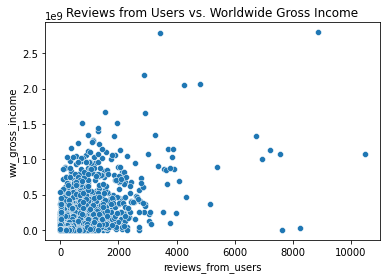

In [ ]:
# This plot is for reviews_from_users compared to ww gross income.
sns.scatterplot(data=movies_df, x='reviews_from_users', y='ww_gross_income')
plt.title("Reviews from Users vs. Worldwide Gross Income")


Text(0.5, 1.0, 'Reviews from Critics vs. Worldwide Gross Income')

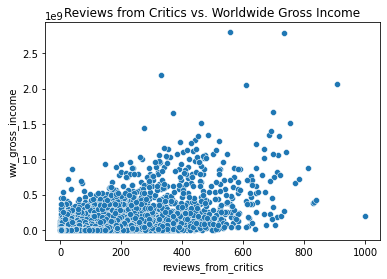

In [ ]:
# This plot is for reviews_from_critics compared to ww gross income.
sns.scatterplot(data=movies_df, x='reviews_from_critics', y='ww_gross_income')
plt.title("Reviews from Critics vs. Worldwide Gross Income")


For the first graph, the income does generally seem to increase with reviews, which would make sense. It is difficult to pick out an extremely clear trend since most movies are bunched in the bottom left corner with few reviews and low income.

For the second graph, there appears to be slightly less correlation comparitively between income and critic reviews.

Finally, we will look at the relationship between avg_vote and ww_gross_income.

Text(0.5, 1.0, 'Average Vote vs. Worldwide Gross Income')

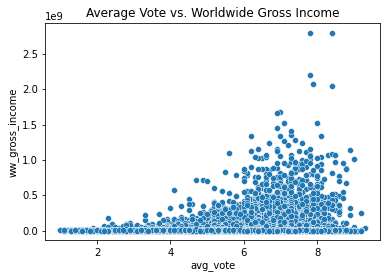

In [ ]:
sns.scatterplot(data=movies_df, x='avg_vote', y='ww_gross_income')
plt.title("Average Vote vs. Worldwide Gross Income")

It appears that a higher vote does correlate with a higher ww gross income.


### Check non-numeric columns

To get a better understanding of some categorical columns that have many levels (categories), we will analyze them in more detail to figure out how to deal with them


First, let's look at the **director** column


*   Given that the movies are from everywhere around the world, there will likely be *many* different directors. Because of this, we will first see how many different directors there are. 


In [ ]:
# make sure we downloaded pandasql
!pip install pandasql
import pandasql as ps

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=e9acd48b532515b5efdbc22c22ec148f2f96030ca98eea9a983605a726225ae3
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
# Let's lowercase the directors so othat capitalization do not make same directors different from one another
movies_df['director'] = movies_df['director'].str.lower()
director_sql = """
                SELECT movies_df.director, COUNT(*) AS count
                FROM movies_df
                GROUP BY movies_df.director
                ORDER BY count DESC
               """
director_check_df = ps.sqldf(director_sql, locals())
director_check_df

,director,count
0,woody allen,46
1,clint eastwood,38
2,takashi miike,32
3,steven spielberg,31
4,steven soderbergh,26
...,...,...
15414,øystein karlsen,1
15415,øystein stene,1
15416,ümit köreken,1
15417,þorsteinn gunnar bjarnason,1


Wow, there are *15419 different directors*! Even though we could make it such that we pick top 10~20 directors that appear the most and categorize the rest into "other," the director that appears the most appears 46 times. This means that even if we take top 20, that only covers ~5% of the directors. **Thus, we will use this column to produce another appropriate column.**

Next, we will look at the **writer** column


*   We expect this to be very similar to the director column


In [ ]:
movies_df['writer'] = movies_df['writer'].str.lower()
writer_sql = """
                SELECT movies_df.writer, COUNT(*) AS count
                FROM movies_df
                GROUP BY movies_df.writer
                ORDER BY count DESC
               """
writer_check_df = ps.sqldf(writer_sql, locals())
writer_check_df

,writer,count
0,None,435
1,woody allen,39
2,jing wong,37
3,sang-soo hong,21
4,john hughes,20
...,...,...
25756,"øystein dolmen, thomas moldestad",1
25757,øystein karlsen,1
25758,"ümit köreken, nursen çetin köreken",1
25759,þorsteinn gunnar bjarnason,1


This time, there are even more different writers! There are in fact *25760 different writers*. **We will drop this column.**

We will now look at the **production_company** column 

In [ ]:
movies_df['production_company'] = movies_df['production_company'].str.lower()
production_sql = """
                SELECT movies_df.production_company, COUNT(*) AS count
                FROM movies_df
                GROUP BY movies_df.production_company
                ORDER BY count DESC
               """
production_check_df = ps.sqldf(production_sql, locals())
production_check_df

,production_company,count
0,None,938
1,universal pictures,425
2,warner bros.,418
3,columbia pictures,396
4,paramount pictures,393
...,...,...
12713,öger productions,1
12714,österreichisches filminstitut,1
12715,öykü film,1
12716,özminimalist film,1


In [ ]:
production_check_df.head(20)

,production_company,count
0,None,938
1,universal pictures,425
2,warner bros.,418
3,columbia pictures,396
4,paramount pictures,393
5,twentieth century fox,292
6,metro-goldwyn-mayer (mgm),209
7,new line cinema,187
8,touchstone pictures,138
9,walt disney pictures,126


Looking at the top 20 most "popular" production companies, they take about ~27% of the entire movies. Given this, we could attempt to still use this feature by categorizing the rest as "other." However, we also see that there are 938 movies missing this value. We could mitigate this value imputation, but we would likely need to use mode (Universal Pictures) to replace nulls. Otherwise we would create a separate null category, which wouldn't provide our model much meaning. 

One concern with imputing by mode is that we could mess up the trends if most of the movies that don't have the production company name aren't successful. It's a well known fact that Universal Pictures is one of the most successful production companies. Thus, we will look a closer look at the movies that do not have production company in the dataset. 

In [ ]:
# all movies who doesn't have production company
movies_df[movies_df['production_company'].isnull()]

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,ww_gross_income,sentiment_score,sentiment,ww_gross_income_log
1,79,tt0007183,pikovaya dama,Pikovaya dama,1916,1916-04-01,"Drama, Fantasy, Horror",63,Russia,Russian,yakov protazanov,"alexander pushkin, fyodor otsep",<NA>,"Tamara Duvan, Ivan Mozzhukhin, Vera Orlova, Ni...","While hosting a game of cards one night, Narum...",7.0,610,NaN,7.0,5.0,144968.0,-2.0,negative,11.884275
477,10682,tt0054861,the exiles,The Exiles,1961,1961-07-13,Drama,72,USA,English,kent mackenzie,kent mackenzie,<NA>,"Yvonne Williams, Homer Nish, Tom Reynolds, Ric...",Follows a family of Native Americans living in...,6.7,988,NaN,13.0,53.0,30945.0,0.0,neutral,10.339999
1016,18051,tt0076263,killer of sheep,Killer of Sheep,1978,1978-11-14,Drama,80,USA,English,charles burnett,charles burnett,<NA>,"Henry G. Sanders, Kaycee Moore, Charles Bracy,...","Set in the Watts area of Los Angeles, a slaugh...",7.3,5929,96.0,40.0,93.0,468460.0,0.0,neutral,13.057208
1034,18192,tt0076706,esecuzione al braccio 3,Short Eyes,1977,1979-07-20,Drama,100,USA,English,robert m. young,miguel pinero,<NA>,"Bruce Davison, José Pérez, Nathan George, Don ...",A child molester sent to prison finds that cri...,7.0,1074,53.0,19.0,24.0,3456.0,-5.0,negative,8.148156
1095,18583,tt0078008,northern lights,Northern Lights,1978,1978-11-17,"Drama, History",95,USA,English,"john hanson, rob nilsson","john hanson, rob nilsson",<NA>,"Robert Behling, Susan Lynch, Joe Spano, Ray Ne...",NORTHERN LIGHTS has the feel of an old black a...,7.0,162,NaN,9.0,3.0,9453.0,-2.0,negative,9.154193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31604,85734,tt9759978,the dude in me,The Dude in Me,2019,2019-01-09,"Comedy, Fantasy",122,South Korea,Korean,hyo-jin kang,<NA>,<NA>,"Sung-woong Park, Jinyoung Jung, Mi-ran Ra, Soo...",A weak high school student and a mighty gangst...,6.9,924,NaN,12.0,8.0,14569310.0,-4.0,negative,16.494428
31616,85756,tt9780140,qissat hubb,Qissat Hubb,2019,2019-02-14,"Comedy, Romance",110,"Egypt, United Arab Emirates","Arabic, English",othman abo labn,"amani el-tunsi, yasser salah",<NA>,"Ahmed Hatem, Hana El Zahed, Yasser El Tobgy, M...",The movie is about a love story between a youn...,7.3,346,NaN,10.0,NaN,44755.0,4.0,positive,10.708981
31641,85816,tt9845398,fin de siglo,Fin de siglo,2019,2020-02-06,Drama,84,Argentina,"Spanish, Catalan",lucio castro,lucio castro,<NA>,"Juan Barberini, Ramon Pujol, Mía Maestro, Mari...",Two men meet in Barcelona and after spending a...,6.9,1873,80.0,23.0,31.0,79607.0,0.0,neutral,11.284870
31648,85833,tt9875852,domovoy,Domovoy,2019,2019-04-11,"Comedy, Family, Fantasy",90,Russia,Russian,evgeniy bedarev,"dmitriy bedarev, evgeniy bedarev",<NA>,"Anastasiya Abadzhidi, Dmitriy Bedarev, Dmitriy...",A single mother buys a flat in the Soviet high...,5.1,168,NaN,NaN,NaN,1842316.0,1.0,positive,14.426535


In [ ]:
# mean, max, and min worldwide gross income for movies without production company
null_mean = movies_df[movies_df['production_company'].isnull()]['ww_gross_income'].mean()
null_max = movies_df[movies_df['production_company'].isnull()]['ww_gross_income'].max()
null_min = movies_df[movies_df['production_company'].isnull()]['ww_gross_income'].min()

print("The mean is " + str(null_mean))
print("The max is " + str(null_max))
print("The min is " + str(null_min))

The mean is 3537904.619402985
The max is 209221380.0
The min is 72.0


In [ ]:
# mean, max, and min worldwide gross income for movies produced by Universal Pictures
universal_mean = movies_df[movies_df['production_company'] == 'universal pictures']['ww_gross_income'].mean()
universal_max = movies_df[movies_df['production_company'] == 'universal pictures']['ww_gross_income'].max()
universal_min = movies_df[movies_df['production_company'] == 'universal pictures']['ww_gross_income'].min()

print("The mean is " + str(universal_mean))
print("The max is " + str(universal_max))
print("The min is " + str(universal_min))

The mean is 125712184.91529411
The max is 1670401444.0
The min is 420.0


As we can see above, there is a significant difference for mean, max, and min worldwide gross incomes for movies with production company and those without.

For mean, movies without production company is about 1/40, 1/8 for max, and 1/6 for min compared to those produced by Universal Pictures. Due to such notable difference, imputing by mode may not be the best choice. Furthermore, since about 70% of the movies will have its production company as "other," this method doesn't seem most ideal overall. **Hence, we will use this column to produce another appropriate column later** instead of taking most popular production companies and categorizing the rest as "other".

In [ ]:
movies_df.dtypes

Unnamed: 0                       int64
imdb_title_id                   string
title                           string
original_title                  string
year                             int64
date_published          datetime64[ns]
genre                           string
duration                         int64
country                         string
language                        string
director                        string
writer                          string
production_company              string
actors                          string
description                     string
avg_vote                       float64
votes                            int64
metascore                      float64
reviews_from_users             float64
reviews_from_critics           float64
ww_gross_income                float64
sentiment_score                float64
sentiment                       string
ww_gross_income_log            float64
dtype: object

Lastly, we will look at **country** and **language** columns

In [ ]:
movies_df['country'] = movies_df['country'].str.lower()
country_sql = """
                SELECT movies_df.country, COUNT(*) AS count
                FROM movies_df
                GROUP BY movies_df.country
                ORDER BY count DESC
               """
country_check_df = ps.sqldf(country_sql, locals())
country_check_df

,country,count
0,usa,7956
1,india,1864
2,france,1453
3,japan,1220
4,uk,986
...,...,...
3235,"west germany, usa, uk",1
3236,yugoslavia,1
3237,"yugoslavia, france, usa",1
3238,"yugoslavia, hungary, austria, west germany",1


As shown above, we can see that some movies belong to more than one country. Because of this, we will do one hot encoding to see how many different countries are there.

In [ ]:
movies_df['country'].str.get_dummies(sep=',')

,afghanistan,albania,algeria,andorra,angola,argentina,armenia,australia,austria,azerbaijan,bahamas,bahrain,bangladesh,belarus,belgium,bhutan,bolivia,bosnia and herzegovina,botswana,brazil,british virgin islands,brunei,bulgaria,burkina faso,cambodia,cameroon,canada,cape verde,cayman islands,chad,chile,china,colombia,cook islands,costa rica,croatia,cuba,cyprus,czech republic,czechoslovakia,...,philippines,poland,portugal,puerto rico,qatar,republic of north macedonia,romania,russia,rwanda,saudi arabia,senegal,serbia,singapore,slovakia,slovenia,somalia,south africa,south korea,soviet union,spain,sri lanka,sweden,switzerland,taiwan,tajikistan,tanzania,thailand,the democratic republic of congo,tunisia,turkey,uk,ukraine,united arab emirates,uruguay,usa,venezuela,vietnam,west germany,yemen,yugoslavia
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31664,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31665,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


As shown above, there are *287* columns, which is quite a lot. Let's look and see if we can use **pycountry** library to map individual countries to continents instead, which would reduce the number of categories from 287 to 7. 

As always, let's first install pycountry package

In [ ]:
!pip install pycountry-convert

     |████████████████████████████████| 10.1MB 22.3MB/s 
     |████████████████████████████████| 245kB 45.0MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=e75da7ecd1abe2db125a8a3f6345b0d4dd2fb92c1e1e943314508c03650eba1b
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.5 which is incompatible.
ERROR: pytest-mock 3.6.1 has requirement pytest>=5.0, but you'll have pytest 3.6.4 which is incompatible.
ERROR: pytest-cov 2.12.0 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
  Found existing installation: coverage 3.7.

In [ ]:
movies_df['country']

0                    usa
1                 russia
2                germany
3                 norway
4                    usa
              ...       
31663              india
31664    france, belgium
31665        netherlands
31666             turkey
31667              spain
Name: country, Length: 31607, dtype: string

We see that some movies have more than one country in the country column. We will deal with this by taking the first country listed as the "main country" for us consider

When running the code below without try-catch, we will run into errors because some countries in the dataset have names that are different from how they are named in the pycountry library.
*   We will use try-catch and look into which countries are named differently.  


In [ ]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
movies_df['country_upper'] = movies_df['country'].str.title()
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe',
}

countries_list = []
multiple_list = []
def country_to_continent(x):
  if not pd.isna(x):
    if len(x.split(',')) > 1:
      multiple_list.append(x)
      x = x.split(',')[0]
    else:
      x = x
    if x =="Usa" or x =="russia" or x=="Soviet union":
      if "Usa":
        return "North America"
      elif "Uk":
        return "Europe"
      elif "Soviet Union":
        return "Europe"
      else: 
        return "other"
    else: 
      try:
          return continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(x))]
      except:
          countries_list.append(x)
          return "other"

movies_df['continent'] = movies_df['country_upper'].apply(lambda x: country_to_continent(x))
print(len(multiple_list))

8461


We will convert the countries list we obtained from the previous cell, which includes countries that caused error when using pycountry, to a dataframe. Then, we will use SQL to group the dataframe by country to see how many different countries are there.


In [ ]:
countries_df = pd.DataFrame(countries_list)
countries_df = countries_df.rename(columns={0: "country"})
country_sql = """
                SELECT countries_df.country, COUNT(*) AS count
                FROM countries_df
                GROUP BY countries_df.country
                ORDER BY count DESC
               """
country_check_df = ps.sqldf(country_sql, locals())
country_check_df

,country,count
0,Uk,2095
1,West Germany,60
2,Soviet Union,23
3,Bosnia And Herzegovina,12
4,Republic Of North Macedonia,10
5,Czechoslovakia,5
6,Federal Republic Of Yugoslavia,4
7,Yugoslavia,4
8,Isle Of Man,1
9,Netherlands Antilles,1


Fortunately, there are only about 10 countries with different names! We will hardcode correct names for these countries by creating a dictionary.  
*   For some countries, like Czechoslovakia, we will hardcode its continent as it is not in the pycountry library.
*   For countries that are not very clear, we will put them into "other."
*   For movies with null, we will put them into "other" as well



In [ ]:
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe',
}

continent_manual = {"Uk": "United Kingdom", "West Germany": 'Germany', "Soviet Union": 'Russian Federation', "Usa": "United States"}
def country_to_continent(x):
  # print(x.split(','))
  # print(x)
  if not pd.isna(x):
    if len(x.split(',')) > 1:
      x = x.split(',')[0]
    else:
      x = x
    if x == "Czechoslovakia" or x =="Republic Of North Macedonia" or x == "Federal Republic Of Yugoslavia" or x == "Yugoslavia" or x == "Bosnia And Herzegovina" or x == "Isle Of Man" or x == "Netherlands Antilles" or x == "The Democratic Republic Of Congo":
      if x == "Czechoslovakia" or x == "Republic Of North Macedonia":
        return "Europe"
      else:
        return "other"
    else: 
      try:
          return continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(x))]
      except:
          return continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(continent_manual[x]))]
  else: 
    return "other"

movies_df['continent'] = movies_df['country_upper'].apply(lambda x: country_to_continent(x))

In [ ]:
continent_sql = """
                SELECT movies_df.continent, COUNT(*) AS count
                FROM movies_df
                GROUP BY movies_df.continent
                ORDER BY count DESC
               """
continent_check_df = ps.sqldf(continent_sql, locals())
continent_check_df

,continent,count
0,Europe,12062
1,North America,10707
2,Asia,6972
3,South America,981
4,Australia,533
5,Africa,314
6,other,38


In [ ]:
movies_df

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,ww_gross_income,sentiment_score,sentiment,ww_gross_income_log,country_upper,continent
0,63,tt0006333,"20,000 leagues under the sea","20,000 Leagues Under the Sea",1916,1916-12-24,"Action, Adventure, Sci-Fi",105,usa,English,stuart paton,jules verne,williamson submarine film corporation,"Dan Hanlon, Edna Pendleton, Curtis Benton, All...",A French professor and his daughter accompany ...,6.2,1501,NaN,28.0,24.0,8000000.0,3.0,positive,15.894952,Usa,North America
1,79,tt0007183,pikovaya dama,Pikovaya dama,1916,1916-04-01,"Drama, Fantasy, Horror",63,russia,Russian,yakov protazanov,"alexander pushkin, fyodor otsep",<NA>,"Tamara Duvan, Ivan Mozzhukhin, Vera Orlova, Ni...","While hosting a game of cards one night, Narum...",7.0,610,NaN,7.0,5.0,144968.0,-2.0,negative,11.884275,Russia,Europe
2,165,tt0010323,il gabinetto del dottor caligari,Das Cabinet des Dr. Caligari,1920,1920-02-27,"Fantasy, Horror, Mystery",76,germany,German,robert wiene,"carl mayer, hans janowitz",decla-bioscop ag,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...","Hypnotist Dr. Caligari uses a somnambulist, Ce...",8.1,55601,NaN,237.0,160.0,8811.0,-1.0,negative,9.083870,Germany,Europe
3,210,tt0011440,markens grøde,Markens grøde,1921,1921-12-02,Drama,107,norway,<NA>,gunnar sommerfeldt,"knut hamsun, gunnar sommerfeldt",christiana film,"Amund Rydland, Karen Poulsen, Ragna Wettergree...",After the Nobel prize winning Knut Hamsun-nove...,6.6,195,NaN,3.0,3.0,4272.0,-2.0,negative,8.360071,Norway,Europe
4,222,tt0011741,suds,Suds,1920,1920-01-27,"Comedy, Drama, Romance",75,usa,English,john francis dillon,"waldemar young, richard bryce",mary pickford company,"Mary Pickford, Albert Austin, Harold Goodwin, ...",A London laundress attempts to rise above her ...,6.3,210,NaN,9.0,1.0,772155.0,7.0,positive,13.556942,Usa,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,85860,tt9905412,ottam,Ottam,2019,2019-03-08,Drama,120,india,Malayalam,zam,rajesh k narayan,thomas thiruvalla films,"Nandu Anand, Roshan Ullas, Manikandan R. Achar...","Set in Trivandrum, the story of Ottam unfolds ...",7.4,494,NaN,1.0,NaN,4791.0,0.0,neutral,8.474703,India,Asia
31664,85863,tt9908390,le lion,Le lion,2020,2020-01-29,Comedy,95,"france, belgium",French,ludovic colbeau-justin,"alexandre coquelle, matthieu le naour",monkey pack films,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,4.0,3507171.0,-2.0,negative,15.070321,"France, Belgium",Europe
31665,85864,tt9911196,de beentjes van sint-hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,netherlands,"German, Dutch",johan nijenhuis,"radek bajgar, herman finkers",johan nijenhuis & co,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,6.0,4.0,7299062.0,-3.0,negative,15.803257,Netherlands,Europe
31666,85866,tt9914286,sokagin çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,turkey,Turkish,ahmet faik akinci,"ahmet faik akinci, kasim uçkan",gizem ajans,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",<NA>,6.4,194,NaN,NaN,NaN,2833.0,NaN,neutral,7.949444,Turkey,Asia


We will take a similar approach with language and see how many distinct languages are there. 

In [ ]:
movies_df['language'] = movies_df['language'].str.lower()
language_sql = """
                SELECT movies_df.language, COUNT(*) AS count
                FROM movies_df
                GROUP BY movies_df.language
                ORDER BY count DESC
               """
language_check_df = ps.sqldf(language_sql, locals())
language_check_df

,language,count
0,english,10402
1,french,1691
2,spanish,1302
3,japanese,1109
4,italian,754
...,...,...
3049,"yoruba, english, ibo, hausa",1
3050,zulu,1
3051,"zulu, afrikaans, xhosa, english",1
3052,"zulu, english, afrikaans",1


As with **country**, some movies have more than one language. We will also do one-hot-encoding and see how many distinct languages there are. 

In [ ]:
movies_df['language'].str.get_dummies(sep=',')

,abkhazian,aboriginal,acholi,afrikaans,akan,albanian,algonquin,american sign language,amharic,ancient (to 1453),apache languages,arabic,aragonese,aramaic,arapaho,armenian,assamese,assyrian neo-aramaic,athapascan languages,australian sign language,awadhi,aymara,azerbaijani,bable,bambara,basque,belarusian,bemba,bengali,berber languages,bhojpuri,bosnian,brazilian sign language,british sign language,bulgarian,burmese,cantonese,catalan,central american indian languages,chechen,...,romanian,romany,russian,saami,samoan,sardinian,serbian,serbo-croatian,sicilian,sign languages,sinhalese,slovak,slovenian,southern sotho,spanish,swahili,swedish,swiss german,tagalog,tajik,tamil,telugu,thai,tibetan,tigrigna,tswana,turkish,ukrainian,ukrainian sign language,urdu,uzbek,vietnamese,wayuu,welsh,wolof,xhosa,yakut,yiddish,yoruba,zulu
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31664,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31665,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


It seems to be that there are even more distinct languages than countries! Since there will be some correlation between country and language, we will consider the number of languages a movie has instead. 

## Feature Engineering


### Webscrape Top 100 

From previous section, we saw that **production company** and **director** columns have too many levels to use their data as they are. In fact, **actors** column will undoubtedly have many levels as well. While we will use PCA for dimensionality reduction later, we think that having too many columns in first place may rather spread out the trend even more and may be hard to reduce as many columns as we want later with PCA. 

So, we will create a column called production_company_top that has 1 if the production company is one of top 100 production companies and 0 otherwise. We will also do the same the director and actor as well, where we will create director_top and actor_top columns respectively. 

Retaining information about these three columns is important because the popularity and success of actors, production companies and directors play an important role in a movie's predicted success. 

We will webscrape three pages below to get top 100 production companies, actors, and directors:


1.   https://www.the-numbers.com/movies/production-companies/
2.   https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-acting/top-grossing-leading-stars
3. https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-specific-technical-role/director




In [ ]:
# Make sure to install requests and beautiful soup
!pip3 install requests
!pip3 install beautifulsoup4

We will first obtain a list of top 100 production companies

In [ ]:
import requests
from bs4 import BeautifulSoup
import time

top_company_list = []
URL = 'https://www.the-numbers.com/movies/production-companies/'
page = ''
while page == '':
  try:
      page = requests.get(URL)
      break
  except requests.exceptions.ConnectionError as e:
      print(e)
      print("Connection refused by the server..")
      print("Let me sleep for 5 seconds")
      print("ZZzzzz...")
      time.sleep(5)
      print("Was a nice sleep, now let me continue...")
      continue

soup = BeautifulSoup(page.content, 'html.parser')
companies = soup.find_all('tr')
companies.pop(0)
for company in companies:
  company_dict = {}
  results = company.find_all("td")
  company_name = results[0].find('a').text
  # make sure to store lowercased
  top_company_list.append(company_name.lower())
print(top_company_list[:100])

['warner bros.', 'universal pictures', 'columbia pictures', 'walt disney pictures', 'paramount pictures', 'marvel studios', '20th century fox', 'relativity media', 'new line cinema', 'dreamworks pictures', 'legendary pictures', 'dune entertainment', 'disney-pixar', 'amblin entertainment', 'regency enterprises', 'village roadshow productions', 'dreamworks animation', 'lucasfilm', 'lionsgate', 'metro-goldwyn-mayer pictures', 'touchstone pictures', 'ratpac entertainment', 'walt disney animation studios', 'heyday films', 'summit entertainment', 'jerry bruckheimer', 'bad robot', 'twentieth century fox', 'imagine entertainment', 'di bonaventura pictures', 'fox 2000 pictures', 'illumination entertainment', 'tsg entertainment', 'original film', '1492 pictures', 'blumhouse', 'the kennedy/marshall company', 'working title films', 'wingnut films', 'happy madison', 'perfect world pictures', 'spyglass entertainment', 'tri-star pictures', 'scott rudin productions', 'silver pictures', 'temple hill en

Next, we will obtain top 100 actors 

In [ ]:
top_stars_list = []
URL = 'https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-acting/top-grossing-leading-stars'
page = ''
while page == '':
  try:
      page = requests.get(URL)
      break
  except requests.exceptions.ConnectionError as e:
      print(e)
      print("Connection refused by the server..")
      print("Let me sleep for 5 seconds")
      print("ZZzzzz...")
      time.sleep(5)
      print("Was a nice sleep, now let me continue...")
      continue

soup = BeautifulSoup(page.content, 'html.parser')
all_stars = soup.find('tbody')
stars = all_stars.find_all('tr')
for star in stars:
  results = star.find_all("td")
  star_title = results[1].find('a').text
  top_stars_list.append(star_title.lower())
print(top_stars_list)

['robert downey, jr.', 'samuel l. jackson', 'scarlett johansson', 'chris hemsworth', 'chris evans', 'zoe saldana', 'chris pratt', 'tom hanks', 'bradley cooper', 'johnny depp', 'tom cruise', 'vin diesel', 'mark ruffalo', 'emma watson', 'dwayne johnson', 'don cheadle', 'jeremy renner', 'will smith', 'daniel radcliffe', 'harrison ford', 'rupert grint', 'tom holland', 'karen gillan', 'chadwick boseman', 'elizabeth olsen', 'benedict cumberbatch', 'josh brolin', 'sebastian stan', 'leonardo dicaprio', 'matt damon', 'tom hiddleston', 'paul bettany', 'dave bautista', 'eddie murphy', 'brad pitt', 'liam neeson', 'bruce willis', 'ben stiller', 'hugh jackman', 'ian mckellen', 'steve carell', 'letitia wright', 'danai gurira', 'gwyneth paltrow', 'jennifer lawrence', 'nicolas cage', 'cameron diaz', 'pom klementieff', 'ewan mcgregor', 'benedict wong', 'josh gad', 'adam sandler', 'julia roberts', 'jim carrey', 'sandra bullock', 'jack black', 'ben affleck', 'robert de niro', 'idris elba', 'daisy ridley',

Lastly, we will get top 100 directors

In [ ]:
top_directors_list = []
# Get baseline URL and append the page number
URL = 'https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-specific-technical-role/director'
page = ''
while page == '':
  try:
      page = requests.get(URL)
      break
  except requests.exceptions.ConnectionError as e:
      print(e)
      print("Connection refused by the server..")
      print("Let me sleep for 5 seconds")
      print("ZZzzzz...")
      time.sleep(5)
      print("Was a nice sleep, now let me continue...")
      continue

soup = BeautifulSoup(page.content, 'html.parser')
all_directors = soup.find('tbody')
directors = all_directors.find_all('tr')
for director in directors:
  results = director.find_all("td")
  director_title = results[1].find('a').text
  top_directors_list.append(director_title.lower())
print(top_directors_list)

['steven spielberg', 'anthony russo', 'joe russo', 'peter jackson', 'michael bay', 'james cameron', 'david yates', 'christopher nolan', 'j.j. abrams', 'tim burton', 'robert zemeckis', 'jon favreau', 'ron howard', 'ridley scott', 'chris columbus', 'roland emmerich', 'bryan singer', 'pierre coffin', 'gore verbinski', 'james wan', 'george lucas', 'brad bird', 'francis lawrence', 'clint eastwood', 'sam raimi', 'chris renaud', 'todd phillips', 'zack snyder', 'sam mendes', 'carlos saldanha', 'bill condon', 'm. night shyamalan', 'joss whedon', 'andrew stanton', 'tom mcgrath', 'jennifer lee', 'chris buck', 'guy ritchie', 'andrew adamson', 'justin lin', 'john lasseter', 'eric darnell', 'barry sonnenfeld', 'conrad vernon', 'shawn levy', 'steven soderbergh', 'jon turteltaub', 'pete docter', 'f. gary gray', 'kyle balda', 'jake kasdan', 'brett ratner', 'martin scorsese', 'rob marshall', 'tony scott', 'david fincher', 'andy wachowski', 'james mangold', 'rich moore', 'martin campbell', 'jon watts', '

Now that we have webscraped these three websites, we will create new respective columns. 

For actors, a movie will have 0 for the **top_actor** column if none of the actors are in top 100 actors list that we obtained from webscraping. It will have 1 otherwise.

In [ ]:
movies_df['actors'] = movies_df['actors'].str.lower()
def check_top_actor(x):
  # 0 if null
  if pd.isna(x):
    return 0
  else: 
    actors = x.split(',')
    # when there are multiple actors, check each 
    for actor in actors:
      actor = actor.strip()
      if actor in top_stars_list:
        return 1
      else:
        return 0

movies_df['top_actor'] = movies_df['actors'].apply(lambda x: check_top_actor(x))
movies_df[movies_df['top_actor']==1].shape[0]

1448

As with directors, we will check if any of the director(s) for a movie is in top 100. It will have 1 for the **top_director** column if so and 1 otherwise. 

In [ ]:
def check_top_directors(x):
  # 0 if null
  if pd.isna(x):
    return 0
  else: 
    directors = x.split(',')
    # if there are multiple directors, check each 
    for director in directors:
      director = director.strip()
      if director in top_directors_list:
        return 1
      else:
        return 0

movies_df['top_director'] = movies_df['director'].apply(lambda x: check_top_directors(x))
movies_df[movies_df['top_director']==1].shape[0]

922

Same thing here as well. If the production company is part of top 100 production company list, **top_company** column will have 1 and 0 otherwise.  

In [ ]:
def check_top_production(x):
  # 0 if null
  if pd.isna(x):
    return 0
  else: 
    # if there are multiple companies, check each 
    companies = x.split(',')
    for company in companies:
      company = company.strip()
      if company in top_company_list:
        return 1
      else:
        return 0

movies_df['top_company'] = movies_df['production_company'].apply(lambda x: check_top_production(x))
movies_df[movies_df['top_company']==1].shape[0]

11709

### Process title, actor, and genre columns

We will create three new columns. One for title based on its length, one for genre based on how many genres a movie is in, and one for actors based on number of actors in the movie.

In [ ]:
# Create a column called 'title_length' with the number of characters in the title.

movies_df['title_length'] = movies_df['title'].apply(lambda x: len(x))

In [ ]:
# Create a column called 'genre_count' with the number of genres the movie is listed in.
# Will do this by counting number of commas and adding 1

movies_df['genre_count'] = movies_df['genre'].apply(lambda x: x.count(',') + 1)

In [ ]:
# Create a column called 'actor_count' with the number of main actors listed for the movie
# Will do this by counting nuber of commas and adding 1

def count_actors(x):
  if not pd.isna(x):
    return x.count(',') + 1

movies_df['actor_count'] = movies_df['actors'].apply(lambda x: count_actors(x))

### Process Date Published Column


We will extract the month, day, weekday, and quarter from the date published column and put those in their own columns.

In [ ]:
# Extract the month
movies_df['published_month'] = movies_df['date_published'].apply(lambda x: x.month)

# Extract the weekday
movies_df['published_weekday'] = movies_df['date_published'].apply(lambda x: x.dayofweek)

# Extract the quarter
# Months 1-3 in quarter 1, 4-6 in quarter 2, 7-9 in quarter 3, 10-12 in quarter 4

def find_quarter(x):
  if x >= 1 and x <= 3:
    return 1
  elif x >= 4 and x <= 6:
    return 2
  elif x >= 7 and x <= 9:
    return 3
  else:
    return 4
    
movies_df['published_quarter'] = movies_df['published_month'].apply(lambda x: find_quarter(x))



In [ ]:
movies_df

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,metascore,reviews_from_users,reviews_from_critics,ww_gross_income,sentiment_score,sentiment,ww_gross_income_log,country_upper,continent,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter
0,63,tt0006333,"20,000 leagues under the sea","20,000 Leagues Under the Sea",1916,1916-12-24,"Action, Adventure, Sci-Fi",105,usa,english,stuart paton,jules verne,williamson submarine film corporation,"dan hanlon, edna pendleton, curtis benton, all...",A French professor and his daughter accompany ...,6.2,1501,NaN,28.0,24.0,8000000.0,3.0,positive,15.894952,Usa,North America,0,0,0,28,3,10.0,12,6,4
1,79,tt0007183,pikovaya dama,Pikovaya dama,1916,1916-04-01,"Drama, Fantasy, Horror",63,russia,russian,yakov protazanov,"alexander pushkin, fyodor otsep",<NA>,"tamara duvan, ivan mozzhukhin, vera orlova, ni...","While hosting a game of cards one night, Narum...",7.0,610,NaN,7.0,5.0,144968.0,-2.0,negative,11.884275,Russia,Europe,0,0,0,13,3,6.0,4,5,2
2,165,tt0010323,il gabinetto del dottor caligari,Das Cabinet des Dr. Caligari,1920,1920-02-27,"Fantasy, Horror, Mystery",76,germany,german,robert wiene,"carl mayer, hans janowitz",decla-bioscop ag,"werner krauss, conrad veidt, friedrich feher, ...","Hypnotist Dr. Caligari uses a somnambulist, Ce...",8.1,55601,NaN,237.0,160.0,8811.0,-1.0,negative,9.083870,Germany,Europe,0,0,0,32,3,6.0,2,4,1
3,210,tt0011440,markens grøde,Markens grøde,1921,1921-12-02,Drama,107,norway,<NA>,gunnar sommerfeldt,"knut hamsun, gunnar sommerfeldt",christiana film,"amund rydland, karen poulsen, ragna wettergree...",After the Nobel prize winning Knut Hamsun-nove...,6.6,195,NaN,3.0,3.0,4272.0,-2.0,negative,8.360071,Norway,Europe,0,0,0,13,1,15.0,12,4,4
4,222,tt0011741,suds,Suds,1920,1920-01-27,"Comedy, Drama, Romance",75,usa,english,john francis dillon,"waldemar young, richard bryce",mary pickford company,"mary pickford, albert austin, harold goodwin, ...",A London laundress attempts to rise above her ...,6.3,210,NaN,9.0,1.0,772155.0,7.0,positive,13.556942,Usa,North America,0,0,0,4,3,6.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,85860,tt9905412,ottam,Ottam,2019,2019-03-08,Drama,120,india,malayalam,zam,rajesh k narayan,thomas thiruvalla films,"nandu anand, roshan ullas, manikandan r. achar...","Set in Trivandrum, the story of Ottam unfolds ...",7.4,494,NaN,1.0,NaN,4791.0,0.0,neutral,8.474703,India,Asia,0,0,0,5,1,11.0,3,4,1
31664,85863,tt9908390,le lion,Le lion,2020,2020-01-29,Comedy,95,"france, belgium",french,ludovic colbeau-justin,"alexandre coquelle, matthieu le naour",monkey pack films,"dany boon, philippe katerine, anne serra, samu...",A psychiatric hospital patient pretends to be ...,5.3,398,NaN,NaN,4.0,3507171.0,-2.0,negative,15.070321,"France, Belgium",Europe,0,0,1,7,1,15.0,1,2,1
31665,85864,tt9911196,de beentjes van sint-hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,netherlands,"german, dutch",johan nijenhuis,"radek bajgar, herman finkers",johan nijenhuis & co,"herman finkers, johanna ter steege, leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,NaN,6.0,4.0,7299062.0,-3.0,negative,15.803257,Netherlands,Europe,0,0,0,30,2,15.0,2,3,1
31666,85866,tt9914286,sokagin çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,turkey,turkish,ahmet faik akinci,"ahmet faik akinci, kasim uçkan",gizem ajans,"ahmet faik akinci, belma mamati, metin keçeci,...",<NA>,6.4,194,NaN,NaN,NaN,2833.0,NaN,neutral,7.949444,Turkey,Asia,0,0,0,17,2,15.0,3,4,1


### Drop irrelevant columns

Looking at the columns, we see that some columns, such as year, aren't very meaningful. 


*   With year, for example, since we will be predicting success of movies that *will* be released in the future, it doesn't make sense to consider year as one of the features.
*   Following is a list of columns we will drop:

      1.   imdb_title_id
      2.   title
      3.   original_title
      4.   year
      5.   language
      6.   director
      7. writer
      8. production_company
      9. actors
      10. description
      11. avg_vote 
      12. votes
      13. metascore
      14. reviews_from_users
      15. reviews_from_critics
      16. country
      17. country_upper
      18. sentiment_score
      19. ww_gross_income_log

We remove votes and reviews as well since these are features that we do not have access to until the movie is released. Since we are predicting the success of movies before it's released, it does not make sense to include these.





In [ ]:
movies_df.columns

Index(['Unnamed: 0', 'imdb_title_id', 'title', 'original_title', 'year',
       'date_published', 'genre', 'duration', 'country', 'language',
       'director', 'writer', 'production_company', 'actors', 'description',
       'avg_vote', 'votes', 'metascore', 'reviews_from_users',
       'reviews_from_critics', 'ww_gross_income', 'sentiment_score',
       'sentiment', 'ww_gross_income_log', 'country_upper', 'continent',
       'top_actor', 'top_director', 'top_company', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter'],
      dtype='object')

In [ ]:
movies_df.drop(columns=['Unnamed: 0','imdb_title_id', 'title', 'original_title', 'year', 'language', 'director', 'writer', 'production_company', 'actors', 'description', 'avg_vote', 'votes', 'metascore', 'reviews_from_users', 'reviews_from_critics', 'country', 'date_published', 'country', 'country_upper', 'sentiment_score', 'ww_gross_income_log'], inplace=True)
movies_df.columns

Index(['genre', 'duration', 'ww_gross_income', 'sentiment', 'continent',
       'top_actor', 'top_director', 'top_company', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter'],
      dtype='object')

### Convert categorical features to one hot vectors 

Currently, categorical features have values as strings, which is not suitable for when we train our model later. We will one-hot encode this as a result. 


*   List of columns to encode: genre, sentiment, continent

In [ ]:
# Genre - since some have more than one, add sep=','
movies_df_check = movies_df
genre_dummies = movies_df_check['genre'].str.get_dummies(sep=', ')
movies_df_final = pd.concat([movies_df_check, genre_dummies], axis=1)
movies_df_final

,genre,duration,ww_gross_income,sentiment,continent,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,"Action, Adventure, Sci-Fi",105,8000000.0,positive,North America,0,0,0,28,3,10.0,12,6,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,"Drama, Fantasy, Horror",63,144968.0,negative,Europe,0,0,0,13,3,6.0,4,5,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,"Fantasy, Horror, Mystery",76,8811.0,negative,Europe,0,0,0,32,3,6.0,2,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
3,Drama,107,4272.0,negative,Europe,0,0,0,13,1,15.0,12,4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Comedy, Drama, Romance",75,772155.0,positive,North America,0,0,0,4,3,6.0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,Drama,120,4791.0,neutral,Asia,0,0,0,5,1,11.0,3,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31664,Comedy,95,3507171.0,negative,Europe,0,0,1,7,1,15.0,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31665,"Comedy, Drama",103,7299062.0,negative,Europe,0,0,0,30,2,15.0,2,3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31666,"Drama, Family",98,2833.0,neutral,Asia,0,0,0,17,2,15.0,3,4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sentiment_dummies = movies_df_check['sentiment'].str.get_dummies(sep=', ')
movies_df_final = pd.concat([movies_df_final, sentiment_dummies], axis=1)
movies_df_final

,genre,duration,ww_gross_income,sentiment,continent,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive
0,"Action, Adventure, Sci-Fi",105,8000000.0,positive,North America,0,0,0,28,3,10.0,12,6,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,"Drama, Fantasy, Horror",63,144968.0,negative,Europe,0,0,0,13,3,6.0,4,5,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,"Fantasy, Horror, Mystery",76,8811.0,negative,Europe,0,0,0,32,3,6.0,2,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,Drama,107,4272.0,negative,Europe,0,0,0,13,1,15.0,12,4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,"Comedy, Drama, Romance",75,772155.0,positive,North America,0,0,0,4,3,6.0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,Drama,120,4791.0,neutral,Asia,0,0,0,5,1,11.0,3,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
31664,Comedy,95,3507171.0,negative,Europe,0,0,1,7,1,15.0,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
31665,"Comedy, Drama",103,7299062.0,negative,Europe,0,0,0,30,2,15.0,2,3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
31666,"Drama, Family",98,2833.0,neutral,Asia,0,0,0,17,2,15.0,3,4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
continent_dummies = movies_df_check['continent'].str.get_dummies(sep=', ')
movies_df_final = pd.concat([movies_df_final, continent_dummies], axis=1)

,genre,duration,ww_gross_income,sentiment,continent,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,"Action, Adventure, Sci-Fi",105,8000000.0,positive,North America,0,0,0,28,3,10.0,12,6,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,"Drama, Fantasy, Horror",63,144968.0,negative,Europe,0,0,0,13,3,6.0,4,5,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,"Fantasy, Horror, Mystery",76,8811.0,negative,Europe,0,0,0,32,3,6.0,2,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,Drama,107,4272.0,negative,Europe,0,0,0,13,1,15.0,12,4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,"Comedy, Drama, Romance",75,772155.0,positive,North America,0,0,0,4,3,6.0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,Drama,120,4791.0,neutral,Asia,0,0,0,5,1,11.0,3,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
31664,Comedy,95,3507171.0,negative,Europe,0,0,1,7,1,15.0,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
31665,"Comedy, Drama",103,7299062.0,negative,Europe,0,0,0,30,2,15.0,2,3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
31666,"Drama, Family",98,2833.0,neutral,Asia,0,0,0,17,2,15.0,3,4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [ ]:
movies_df_final.columns

Index(['genre', 'duration', 'ww_gross_income', 'sentiment', 'continent',
       'top_actor', 'top_director', 'top_company', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'negative',
       'neutral', 'positive', 'Africa', 'Asia', 'Australia', 'Europe',
       'North America', 'South America', 'other'],
      dtype='object')

Now, since we have processed the three categorical features, let's drop them from the dataframe

In [ ]:
movies_df_final.drop(columns=['genre', 'sentiment', 'continent'], inplace=True)

In [ ]:
movies_df_final

,duration,ww_gross_income,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,105,8000000.0,0,0,0,28,3,10.0,12,6,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,63,144968.0,0,0,0,13,3,6.0,4,5,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,76,8811.0,0,0,0,32,3,6.0,2,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,107,4272.0,0,0,0,13,1,15.0,12,4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,75,772155.0,0,0,0,4,3,6.0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,120,4791.0,0,0,0,5,1,11.0,3,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
31664,95,3507171.0,0,0,1,7,1,15.0,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
31665,103,7299062.0,0,0,0,30,2,15.0,2,3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
31666,98,2833.0,0,0,0,17,2,15.0,3,4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


Awesome, values in the dataframe are all numerical now!

## Prepare for training

### Labeling the data

 

Before splitting up the data into train and test datasets, let's create a column for labels. We will classify a movie as successful and unsuccessful based the worldwide gross income. If a movie has made more than $50 million dollars, we will classfiy it as "successful" and not otherwise. 

In [ ]:
def classify_success(x):
  if x > 5*1e7:
    return 1
  else:
    return 0

movies_df_final['label_1'] = movies_df_final['ww_gross_income'].apply(lambda x: classify_success(x))
movies_df_final

,duration,ww_gross_income,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other,label_1
0,105,8000000.0,0,0,0,28,3,10.0,12,6,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,63,144968.0,0,0,0,13,3,6.0,4,5,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,76,8811.0,0,0,0,32,3,6.0,2,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,107,4272.0,0,0,0,13,1,15.0,12,4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,75,772155.0,0,0,0,4,3,6.0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,120,4791.0,0,0,0,5,1,11.0,3,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
31664,95,3507171.0,0,0,1,7,1,15.0,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
31665,103,7299062.0,0,0,0,30,2,15.0,2,3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
31666,98,2833.0,0,0,0,17,2,15.0,3,4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


### Split data into train, validation, and test
Finally, we will split the data into train, validation, and test sets

In [ ]:
label = movies_df_final['label_1']
movies_df_final = movies_df_final.drop(['label_1', 'ww_gross_income'], axis=1)
features = movies_df_final
features

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,105,0,0,0,28,3,10.0,12,6,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,63,0,0,0,13,3,6.0,4,5,2,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,76,0,0,0,32,3,6.0,2,4,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,107,0,0,0,13,1,15.0,12,4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,75,0,0,0,4,3,6.0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,120,0,0,0,5,1,11.0,3,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
31664,95,0,0,1,7,1,15.0,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
31665,103,0,0,0,30,2,15.0,2,3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
31666,98,0,0,0,17,2,15.0,3,4,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


Since we will be doing hyperparameter tuning later with different models and parameters, we want to have a validation dataset as well.

*    We will first designate 0.75 of the data for training and split up the rest of the data for so that test set has 0.1 of the original dataset and validation set has 0.15. 



In [ ]:
from sklearn.model_selection import train_test_split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=1 - train_ratio)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(23705, 42)
(4741, 42)
(3161, 42)


### Value Imputation

We can see that by running the code below, we still have nulls in the **actor_count** column. While we could fill in these missing values with 1, 0 doesn't make sense for there to be 0 actors and 0 will like be an outlier as a result. While 20 is also small enough to drop instead, we will try K-Nearest Neighbor imputation to see if how model would perform. 


*   We will use KNN because unlike simple impuation based on mean and mode, it will impute different values for each row based on k instances to which it is closest to in terms of non-null dimensions. 


In [ ]:
pd.set_option('max_rows', 100)
x_train.isnull().sum(axis = 0)

duration              0
top_actor             0
top_director          0
top_company           0
title_length          0
genre_count           0
actor_count          14
published_month       0
published_weekday     0
published_quarter     0
Action                0
Adventure             0
Animation             0
Biography             0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Family                0
Fantasy               0
Film-Noir             0
History               0
Horror                0
Music                 0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Sport                 0
Thriller              0
War                   0
Western               0
negative              0
neutral               0
positive              0
Africa                0
Asia                  0
Australia             0
Europe                0
North America         0
South America         0
other           

Let's scan rows that have null in **actor_count**

In [ ]:
x_train[pd.isna(x_train['actor_count'])]

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
13818,63,0,0,0,30,1,NaN,8,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
14660,75,0,0,0,12,3,NaN,11,3,4,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
31475,105,0,0,0,12,1,NaN,8,4,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
8722,75,0,0,0,5,2,NaN,4,4,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
30661,75,0,0,1,4,3,NaN,2,5,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
9045,94,0,0,0,18,2,NaN,7,4,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
29807,75,0,0,0,36,3,NaN,10,3,4,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
13849,70,0,0,1,30,3,NaN,3,5,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
31377,148,0,0,0,20,2,NaN,11,5,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
22702,115,0,0,1,49,1,NaN,2,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
from sklearn.impute import KNNImputer

# Initializing imputer
imp = KNNImputer()
imp.fit(x_train)
x_train[:] = imp.transform(x_train)
x_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
2166,105.0,0.0,0.0,1.0,20.0,3.0,15.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24386,102.0,0.0,0.0,0.0,6.0,1.0,15.0,11.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12816,91.0,0.0,0.0,1.0,8.0,2.0,15.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28832,122.0,0.0,0.0,0.0,18.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
912,107.0,0.0,0.0,1.0,12.0,2.0,15.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9182,144.0,0.0,0.0,0.0,7.0,1.0,14.0,8.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
27938,100.0,0.0,0.0,1.0,12.0,3.0,15.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19417,96.0,0.0,0.0,0.0,20.0,2.0,15.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11446,90.0,0.0,0.0,1.0,17.0,3.0,12.0,9.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Let's take a look at a couple of rows that had its value imputed for actor_count

In [ ]:
# NOTE: if you are running this notebook for the first time, you may need to change the indices based on your own train dataset
# x_train.loc[[16903, 20267, 6524]]

In [ ]:
x_train.isnull().sum(axis = 0)

duration             0
top_actor            0
top_director         0
top_company          0
title_length         0
genre_count          0
actor_count          0
published_month      0
published_weekday    0
published_quarter    0
 Action              0
 Adventure           0
 Animation           0
 Biography           0
 Comedy              0
 Crime               0
 Drama               0
 Family              0
 Fantasy             0
 Film-Noir           0
 History             0
 Horror              0
 Music               0
 Musical             0
 Mystery             0
 Romance             0
 Sci-Fi              0
 Sport               0
 Thriller            0
 War                 0
 Western             0
Action               0
Adventure            0
Animation            0
Biography            0
Comedy               0
Crime                0
Documentary          0
Drama                0
Family               0
Fantasy              0
Film-Noir            0
History              0
Horror     

In [ ]:
x_val[:] = imp.transform(x_val)
x_test[:] = imp.transform(x_test)

### Resampling

Now, let's make sure that the train dataset is **balanced**, where the number of successful movies and unsuccessful movies are somewhat equal. Otherwise, our model may become too biased towards one class. 

In [ ]:
print(y_train.value_counts())

0    21637
1     2068
Name: label_1, dtype: int64


There is a clear unbalance between the two classes. Let's create a bar plot to better visualize how much more data we have for unsuccessful movies compared to successful movies

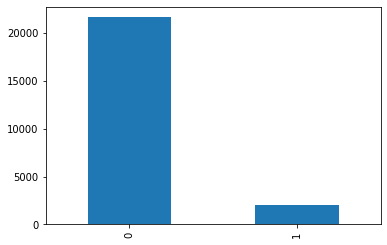

In [ ]:
y_train.value_counts().plot(kind='bar');

Wow, there is only about 1/10 of unsuccessful movies for successful movies! Let's use resampling to mitigate this issue. Given that there are not many successful movies, we will use **oversampling** to add more data for successful movies. 

Let's download the imblearn package first

In [ ]:
!pip install imblearn

We will now do resampling of the train dataset

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_train, columns=features.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_train, columns=features.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Let's check how balanced our train dataset is now!

In [ ]:
y_train = pd.DataFrame(y_train)
print(y_train.value_counts())

1    2077
0    2077
dtype: int64


Yay!! The trainset is now balanced and we are finally ready to move onto machine learning 🥳 🎉

# Section 3: Machine Learning - Unsupervised and Supervised Learning

In this section, we will perform unsupervised and supervised learning for our model. To refresh our minds with what our model will do, our model will do a binary classification where it will *classify* a movie as *successful* and *unsuccessful* based on features, such as genre, duration, actors, director, production company and more. This model will be for the purpose of predicting movies that has *yet* to be released, rather than making guesses on movies that have already been released. 

First, we will start out with unsupervised learning. We will look at dimensionality reduction using PCA to eliminate any collinearities that could cause bias. 

In [ ]:
x_train.columns

Index(['duration', 'top_actor', 'top_director', 'top_company', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter', ' Action', ' Adventure', ' Animation',
       ' Biography', ' Comedy', ' Crime', ' Drama', ' Family', ' Fantasy',
       ' Film-Noir', ' History', ' Horror', ' Music', ' Musical', ' Mystery',
       ' Romance', ' Sci-Fi', ' Sport', ' Thriller', ' War', ' Western',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western', 'negative', 'neutral', 'positive',
       'Africa', 'Asia', 'Australia', 'Europe', 'North America',
       'South America', 'other'],
      dtype='object')

### Check for multicollinearity

To first see how correlated the features are with one another, we will make a correlation matrix between continuous variables. We will not consider one-hot encoding columns for now. 

In [ ]:
x_train_copy = x_train[['duration', 'title_length', 'genre_count', 'actor_count', 'published_month', 'published_weekday', 'published_quarter']]
x_train_copy

,duration,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter
0,134.0,8.0,2.0,13.0,11.0,3.0,4.0
1,118.0,28.0,3.0,15.0,10.0,3.0,4.0
2,100.0,12.0,1.0,15.0,12.0,3.0,4.0
3,116.0,8.0,3.0,15.0,1.0,4.0,1.0
4,79.0,16.0,2.0,15.0,11.0,4.0,4.0
...,...,...,...,...,...,...,...
43251,113.0,9.0,3.0,15.0,4.0,4.0,2.0
43252,130.0,15.0,3.0,15.0,9.0,3.0,3.0
43253,100.0,24.0,3.0,15.0,4.0,4.0,2.0
43254,118.0,13.0,3.0,15.0,10.0,4.0,4.0


In [ ]:
corr_matrix = x_train_copy.corr()
corr_matrix

,duration,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter
duration,1.000000,-0.023602,0.136372,0.115375,-0.012145,0.026144,-0.009012
title_length,-0.023602,1.000000,0.093004,0.072265,0.002810,0.019906,0.002491
genre_count,0.136372,0.093004,1.000000,0.159780,0.022546,0.015625,0.021846
actor_count,0.115375,0.072265,0.159780,1.000000,0.001605,0.024565,0.000643
published_month,-0.012145,0.002810,0.022546,0.001605,1.000000,-0.015840,0.972361
published_weekday,0.026144,0.019906,0.015625,0.024565,-0.015840,1.000000,-0.019550
published_quarter,-0.009012,0.002491,0.021846,0.000643,0.972361,-0.019550,1.000000


To better visualize this matrix, let's create a heatmap!

<a name="set-correlation"></a>

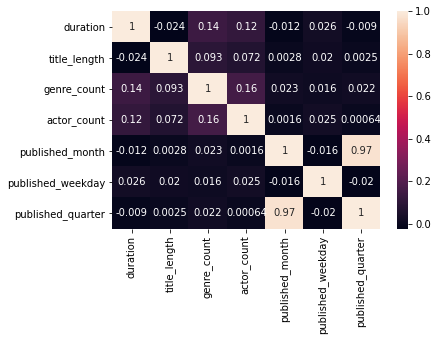

In [ ]:
corr_matrix = x_train_copy.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

As we can see above, for the most part, many of the features are not correlated with one another. However, we see a very high correlation between published_month and published_quarter of 0.97. This is rather expected, given that we obtained quarter based on month. Instead of dropping these columns, let's see if PCA will help out.  

### Scaling and dimensionality reduction

Since PCA is not scale-invariant, we need to make sure we scale our data before we apply PCA. Let's use StandardScaler library for this, which will result the data to have standard deviation and variance of 1.

In [ ]:
x_train.columns

Index(['duration', 'top_actor', 'top_director', 'top_company', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter', ' Action', ' Adventure', ' Animation',
       ' Biography', ' Comedy', ' Crime', ' Drama', ' Family', ' Fantasy',
       ' Film-Noir', ' History', ' Horror', ' Music', ' Musical', ' Mystery',
       ' Romance', ' Sci-Fi', ' Sport', ' Thriller', ' War', ' Western',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western', 'negative', 'neutral', 'positive',
       'Africa', 'Asia', 'Australia', 'Europe', 'North America',
       'South America', 'other'],
      dtype='object')

In [ ]:
x_train.isnull().sum(axis = 0)

duration             0
top_actor            0
top_director         0
top_company          0
title_length         0
genre_count          0
actor_count          0
published_month      0
published_weekday    0
published_quarter    0
 Action              0
 Adventure           0
 Animation           0
 Biography           0
 Comedy              0
 Crime               0
 Drama               0
 Family              0
 Fantasy             0
 Film-Noir           0
 History             0
 Horror              0
 Music               0
 Musical             0
 Mystery             0
 Romance             0
 Sci-Fi              0
 Sport               0
 Thriller            0
 War                 0
 Western             0
Action               0
Adventure            0
Animation            0
Biography            0
Comedy               0
Crime                0
Documentary          0
Drama                0
Family               0
Fantasy              0
Film-Noir            0
History              0
Horror     

In [ ]:
from sklearn.preprocessing import StandardScaler

# Make sure to scale val and test datasets as well
columns = ['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']
x_train_scaled = StandardScaler().fit_transform(x_train[['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']])
x_val_scaled = StandardScaler().fit_transform(x_val[['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']])
x_test_scaled = StandardScaler().fit_transform(x_test[['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']])
x_train_scaled = pd.DataFrame(x_train_scaled, columns=columns)
x_val_scaled = pd.DataFrame(x_val_scaled, columns=columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=columns)
columns_2 = [' Action', ' Adventure', ' Animation',
       ' Biography', ' Comedy', ' Crime', ' Drama', ' Family', ' Fantasy',
       ' Film-Noir', ' History', ' Horror', ' Music', ' Musical', ' Mystery',
       ' Romance', ' Sci-Fi', ' Sport', ' Thriller', ' War', ' Western',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western', 'negative', 'neutral', 'positive',
       'Africa', 'Asia', 'Australia', 'Europe', 'North America',
       'South America', 'other']
x_train_scaled = pd.concat([x_train_scaled.reset_index(), x_train[columns_2].reset_index()], axis=1)
x_val_scaled = pd.concat([x_val_scaled.reset_index(), x_val[columns_2].reset_index()], axis=1)
x_test_scaled = pd.concat([x_test_scaled.reset_index(), x_test[columns_2].reset_index()], axis=1)

In [ ]:
x_train_scaled.shape

(23705, 62)

In [ ]:
x_train.shape

(23705, 63)

In [ ]:
x_train[columns_2].shape

(23705, 53)

In [ ]:
x_train[columns_2]

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
16903,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20267,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31472,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5126,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x_train_scaled = pd.DataFrame(x_train_scaled, columns=columns)
x_train_scaled_1 = pd.concat([x_train_scaled.reset_index(), x_train[columns_2].reset_index()], axis=1)

In [ ]:
x_train_scaled_1

,index,duration,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,index,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,0,1.390433,-0.951674,-0.175671,-0.393033,1.275123,-0.387223,1.301055,16903,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.616813,1.149653,1.046602,0.407658,0.989280,-0.387223,1.301055,20267,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,-0.253509,-0.531408,-1.397944,0.407658,1.560966,-0.387223,1.301055,6524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,0.520111,-0.951674,1.046602,0.407658,-1.583311,0.589383,-1.323233,31472,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,-1.268885,-0.111143,-0.175671,0.407658,1.275123,0.589383,1.301055,25024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23700,23700,1.197028,-0.531408,-0.175671,0.407658,0.989280,0.589383,1.301055,9267,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23701,23701,-0.930426,0.309123,-1.397944,0.407658,1.275123,-0.387223,1.301055,3511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23702,23702,-0.060104,0.834454,1.046602,0.407658,-0.725780,0.589383,-0.448470,5126,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23703,23703,0.471759,-0.531408,1.046602,0.407658,-0.154094,0.589383,-0.448470,5421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x_train_scaled.isnull().sum(axis = 0)

index                0
duration             0
title_length         0
genre_count          0
actor_count          0
published_month      0
published_weekday    0
published_quarter    0
index                0
 Action              0
 Adventure           0
 Animation           0
 Biography           0
 Comedy              0
 Crime               0
 Drama               0
 Family              0
 Fantasy             0
 Film-Noir           0
 History             0
 Horror              0
 Music               0
 Musical             0
 Mystery             0
 Romance             0
 Sci-Fi              0
 Sport               0
 Thriller            0
 War                 0
 Western             0
Action               0
Adventure            0
Animation            0
Biography            0
Comedy               0
Crime                0
Documentary          0
Drama                0
Family               0
Fantasy              0
Film-Noir            0
History              0
Horror               0
Music      

In [ ]:
x_train_scaled

,duration,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,1.390433,-0.951674,-0.175671,-0.393033,1.275123,-0.387223,1.301055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.616813,1.149653,1.046602,0.407658,0.989280,-0.387223,1.301055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.253509,-0.531408,-1.397944,0.407658,1.560966,-0.387223,1.301055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.520111,-0.951674,1.046602,0.407658,-1.583311,0.589383,-1.323233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.268885,-0.111143,-0.175671,0.407658,1.275123,0.589383,1.301055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Let's first plot cumulative explained variance ratio, where the number of components at which the line tips off is from which most of the variance is maintained

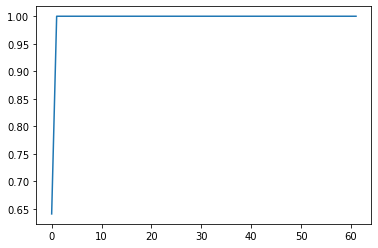

[0.64064856 0.35935137 0.00000002 0.00000001 0.00000001 0.00000001
 0.00000001 0.00000001 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=x_train_scaled.shape[1])
x_train_scaled[:] = pca.fit_transform(x_train_scaled)
np.set_printoptions(suppress=True)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()
print(pca.explained_variance_ratio_)

As we see above, most of the features are necessary to maintain as much variance as possible. This is expected since we saw earlier from the [heatmap](#set-correlation) that most of the features are not correlated. 

Seeing that the line tips off halfway between 50 and 60 components, we will set n = 56.

In [ ]:
pca = PCA(n_components=56)
x_train_scaled = pca.fit_transform(x_train_scaled)
x_val_scaled = pca.transform(x_val_scaled)
x_test_scaled = pca.transform(x_test_scaled)
x_train_scaled = pd.DataFrame(x_train_scaled)
x_val_scaled = pd.DataFrame(x_val_scaled)
x_test_scaled = pd.DataFrame(x_test_scaled)
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,2.252439,1.592221,3.266583,2.478812,-0.109117,-1.002919,-0.838734,0.429527,1.007596,-0.187727,2.097447,-0.365710,-0.179873,-0.120873,-0.062976,-0.677642,0.075809,-0.692347,0.578437,-0.529408,-0.509946,0.489493,-0.246062,0.267961,0.460962,-0.930261,-0.697033,0.397575,-0.353340,-0.290122,0.299802,-0.177525,0.947472,-0.822393,0.511515,-0.195416,0.183415,0.868865,0.837616,1.036895,-0.696700,0.845567,-0.564581,0.324412,1.871170,0.504935,-1.356052,0.875515,-0.008261,-1.143270,0.738025,0.315220,-3.726341,-1.306127,0.499367,-0.258240
1,-1.245638,1.399463,-1.650941,0.461893,0.375447,-0.919468,-0.620096,-0.533181,0.470553,-0.767092,-0.954292,0.640080,-0.330653,-0.167898,-0.462948,0.023100,0.014172,-0.105638,-0.342418,0.232573,-0.030857,-0.092716,-0.128017,0.020036,0.048722,0.004665,-0.129083,0.074337,-0.056191,-0.039213,0.126726,-0.004653,-0.160662,-0.108335,0.013821,0.192000,0.228206,-0.329739,0.172116,-0.677140,0.611815,0.275948,-0.386848,-0.288255,0.406107,0.131710,-0.507135,0.707763,-0.192183,-0.025511,0.127323,-0.069932,0.616235,-0.219268,0.368972,0.343490
2,0.848143,-2.595266,1.029383,-1.699188,-1.754869,0.718148,-0.730845,1.119838,0.724909,-0.059174,1.504918,1.562916,1.565091,-0.146945,0.032100,0.048319,-0.813426,-0.156169,0.298774,-0.052529,1.117992,0.456518,-0.326775,-0.644043,0.577368,-0.703969,0.029760,-0.267420,-0.127204,-0.150119,0.051726,0.208503,0.348573,-0.254296,-0.126058,-0.124775,-0.340687,0.080056,0.002351,-0.257624,-0.381551,0.921669,-0.006035,0.089357,-0.535070,-0.215906,-0.943752,-1.580232,1.196425,1.524567,-2.119958,-2.396058,0.522294,-0.554236,0.048280,-0.397626
3,2.255958,2.724148,0.645944,-0.667416,-2.245653,-0.183299,1.113462,1.135914,4.797869,1.541308,-0.073931,-3.415179,0.039396,0.013599,0.981000,-0.446632,-1.552341,0.170369,-0.255023,-0.437597,0.383676,0.608574,0.220365,0.300081,0.204170,0.713117,-0.174633,-0.425401,0.012325,-0.072034,-0.075893,0.085630,0.072632,0.213429,0.177189,-0.809615,-0.704795,-0.829374,0.266521,0.071310,0.987147,0.245325,-0.117997,0.160649,-1.099254,0.236354,0.706292,1.053665,0.120097,0.509836,0.069083,-0.439313,0.097549,-0.060080,-0.613707,0.415582
4,3.623382,-0.712419,0.297153,0.668693,0.102675,-0.038233,1.509784,-2.752679,0.953161,-0.377996,-0.217094,0.034749,1.483034,0.551889,1.775910,-0.439100,-1.715672,0.530044,0.367426,-1.039992,-0.104868,0.434378,-0.065785,0.111953,0.313838,0.055510,0.055596,-0.281713,0.176014,-0.141787,-0.001442,0.111444,0.251367,-0.105200,-0.083254,-0.652994,-0.251254,0.388864,0.252689,0.703790,-0.267927,0.398643,0.531607,-0.178848,-0.264115,-0.239109,0.010580,0.592853,-0.279877,0.088058,0.099903,0.754573,-1.435082,0.055203,0.132564,1.083564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23700,0.553075,0.815079,-1.519908,0.757398,-0.870083,1.449739,-0.090180,-1.923477,0.275528,-0.632961,-0.741394,0.159412,0.879382,-0.279007,0.737573,0.118867,-1.156607,0.243500,-0.126506,-0.556835,-0.008224,0.062232,-0.363658,-0.407603,0.806669,-0.056646,0.191032,-0.163479,0.122858,-0.079118,0.077748,0.092401,-0.015319,-0.647405,-0.629823,-0.736314,-0.124849,0.650303,-0.291774,-1.044439,-0.173329,0.307782,0.770522,-0.813909,-0.896906,-0.194063,0.145104,0.928887,-0.396200,0.186877,-0.086114,0.926351,-0.646715,-0.004447,1.250492,-0.813993
23701,0.021963,1.762628,-1.677859,-0.646578,2.140583,1.821609,-1.554080,0.414665,0.308052,-0.845116,0.040590,0.272051,-0.982940,-0.131518,0.114386,0.146835,-0.379322,-0.173442,-0.158708,0.099876,-0.185576,-0.121066,0.090620,-0.319640,-0.335792,0.538956,-0.200745,0.158865,-0.065451,0.365273,0.088906,-0.379137,-0.157553,-0.073763,0.287598,-0.117458,0.114410,-0.124435,-0.010990,0.742455,-0.215723,-0.256038,0.

In [ ]:
# for undersample
pca = PCA(n_components=6)
x_train_scaled = pca.fit_transform(x_train_scaled)
x_val_scaled = pca.transform(x_val_scaled)
x_test_scaled = pca.transform(x_test_scaled)
x_train_scaled = pd.DataFrame(x_train_scaled)
x_val_scaled = pd.DataFrame(x_val_scaled)
x_test_scaled = pd.DataFrame(x_test_scaled)
x_train_scaled

,0,1,2,3,4,5
0,-808.276119,11871.951789,1.855811,0.429582,1.593099,0.651593
1,-4171.531336,11942.738681,1.596952,1.603343,-0.925543,0.057290
2,9568.317725,11648.467773,2.047692,-1.409005,0.286391,0.592076
3,-15374.022473,12179.850180,-2.066404,1.545570,0.648238,0.251102
4,-8927.512123,12041.252194,1.763126,-0.191303,-0.847356,-0.674165
...,...,...,...,...,...,...
23700,6320.234797,-11985.601073,1.649614,0.598427,1.148464,0.157684
23701,12074.902697,-12109.432004,1.823581,-1.574550,-0.681447,0.116522
23702,10460.249201,-12075.968207,-0.857750,1.103870,-0.668964,-0.488755
23703,10165.295021,-12070.672774,-0.434264,1.084727,0.519090,0.113059


In [ ]:
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,2.345902,-2.095219,-0.955163,1.740183,0.335155,-0.342197,-0.830863,0.139825,0.427278,-0.055089,0.339796,0.224206,0.382090,0.357261,-0.504393,0.494566,-0.161846,0.295888,-0.660960,-0.829690,0.472893,-0.030512,-0.249995,0.087077,-0.097418,-0.020208,-0.123240,-0.156122,-0.112333,0.034618,0.059225,0.153039,-0.071985,-0.565209,0.108547,-0.122476,0.293600,-0.474116,-0.118439,0.302090,0.482561,-0.031385,0.030903,0.540678,0.668311,-0.581129,-0.163110,2.780489,-0.381210,-0.368819,0.660603,1.842373,-0.576676,-1.472128,1.264415,-0.744879
1,-2.159837,1.160427,-0.658545,1.600809,-0.459277,-0.559474,-0.066758,-0.925436,0.629490,-0.997781,-0.657331,0.617547,-0.208452,-0.269370,0.523955,-0.353464,-0.204775,0.254118,-0.032710,-0.047193,0.065299,-0.036477,-0.034367,0.275333,-0.022667,0.067309,-0.030781,-0.025911,-0.007290,0.074399,-0.063816,-0.091138,-0.025982,-0.045871,0.047797,-0.224221,-0.115510,0.023836,0.459324,0.698808,-0.566816,-0.072635,-0.139411,0.385908,-0.053861,-0.645523,0.525377,0.291215,0.215988,-0.136133,-0.010860,0.032563,-0.343514,0.276525,0.108297,0.628024
2,-1.141047,1.084349,-0.579155,-0.606998,-1.186899,1.285190,-0.911539,-0.955965,0.110235,-0.751196,-0.377116,-0.439910,0.558438,-0.153328,0.186621,0.115633,-0.163313,0.627671,0.215352,-0.033536,0.026272,-0.232277,-0.065670,0.269601,0.044361,0.101989,-0.000156,0.064526,0.140236,-0.013216,-0.022726,-0.239152,-0.129095,-0.086855,-0.243545,-0.475047,0.192427,-0.071532,0.521000,0.376145,-0.754450,-0.298146,-0.048929,-0.587659,0.079278,-1.208225,0.095873,0.406794,-0.078202,-0.024659,0.149429,0.189347,-0.532650,0.142173,0.071034,0.607023
3,-1.988157,0.649831,-0.342028,0.670317,-0.670505,0.367156,1.385950,0.914132,0.722593,-1.538310,-0.676283,1.236500,-0.676195,0.868159,-0.671448,0.088884,-0.039673,-0.206547,-0.229111,-0.207619,0.052918,0.125945,-0.225850,-0.064962,0.399453,0.005477,0.232055,0.145313,-0.072533,0.037433,0.014852,-0.084306,0.283860,-0.202354,-0.091072,0.398667,-0.342395,0.355817,-0.410547,-0.890710,0.444266,0.167412,0.439225,-0.483715,-0.869257,0.834038,0.417898,-0.019910,-0.164626,0.132340,-0.040787,-0.248990,0.663971,-0.447859,-0.243005,-0.123501
4,-1.566164,1.121666,-0.002307,2.133599,1.027891,1.085336,-1.216947,-0.782525,0.498326,-0.389027,-0.061748,-0.205354,-0.120152,-0.599658,0.720062,-0.211318,-0.487774,0.148230,-0.041801,-0.009641,0.163953,-0.040973,-0.077183,0.345883,0.232292,0.032568,-0.074169,0.003564,0.016537,0.029074,0.078634,-0.114597,-0.120053,-0.042143,-0.328526,-0.222733,0.073945,0.116573,0.418148,1.067164,-0.713892,-0.370322,-0.141991,0.062231,0.143710,-0.472606,0.587734,0.272297,0.261316,-0.223147,-0.284435,-0.530759,-0.430934,-0.363811,-0.685300,0.462373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23700,-1.199623,1.895089,0.327954,-1.986528,-0.441383,0.273161,0.775047,1.784581,2.006092,-0.422093,0.500883,-0.064735,-1.425765,-0.147501,-0.997037,-0.055505,-0.389166,-0.599946,0.026378,-0.040823,0.452583,-0.631322,-0.209651,-0.245290,0.414719,-0.155133,-0.102518,0.093945,-0.028416,-0.289843,-0.185959,0.047344,0.517769,-0.088794,0.069614,0.321801,-0.136439,-0.520648,0.556441,0.641348,0.441869,0.861025,-0.492256,0.190497,-1.566292,1.307467,-2.477757,0.930311,-0.400326,0.563293,-1.220161,0.008207,1.032248,-0.239932,0.968327,0.312144
23701,-0.698195,0.522905,-0.800404,-0.473017,-1.786680,1.134372,-0.451402,-1.252862,-1.658147,1.738261,-0.175057,-0.211207,0.140991,0.004556,-0.033717,0.253728,-0.624320,0.454540,0.300276,-0.090552,0.124039,-0.212430,0.006605,0.134010,0.159206,0.009747,0.061514,-0.029311,0.011038,0.086809,-0.007715,0.006631,-0.030586,0.026010,-0.398335,-0.547062,0.246413,-0.124826,0.114494,-0.028665,-0.8

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
x_train_scaled, y_train = ros.fit_resample(x_train_scaled, y_train)
x_train_scaled = pd.DataFrame(x_train_scaled)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,11711.0,0.548975,-1.155053,-0.179395,0.407383,-1.013813,0.588664,-1.329976,28877.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,17738.0,-0.106028,-1.259200,-0.179395,0.407383,-1.298416,0.588664,-1.329976,8600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,13361.0,-1.063341,-1.050906,1.043661,0.407383,-0.160004,-0.387023,-0.456504,19039.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,15320.0,-0.106028,-0.217731,-0.179395,0.407383,0.978407,-0.387023,1.290438,12812.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,13170.0,-0.408338,-0.217731,-1.402452,-3.614698,0.978407,-0.387023,1.290438,16507.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4103,23673.0,0.498590,-0.009437,1.043661,0.407383,0.124599,0.588664,0.416967,5861.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4104,23684.0,0.095511,0.407150,1.043661,0.407383,-1.013813,0.588664,-1.329976,21538.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4105,23686.0,1.153594,0.511297,-1.402452,0.407383,-1.583019,-0.387023,-1.329976,3569.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4106,23689.0,0.649745,0.198857,1.043661,0.407383,0.978407,0.588664,1.290438,9540.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
y_train = pd.DataFrame(y_train)
print(y_train.value_counts())

1    2054
0    2054
dtype: int64


In [ ]:
x_train

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
28661,84.0,0.0,0.0,0.0,15.0,3.0,15.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16632,111.0,0.0,0.0,0.0,7.0,2.0,15.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14278,82.0,0.0,0.0,0.0,29.0,3.0,15.0,10.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12199,86.0,0.0,0.0,1.0,18.0,3.0,15.0,8.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1296,94.0,0.0,0.0,1.0,13.0,3.0,15.0,5.0,4.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,95.0,0.0,0.0,1.0,13.0,2.0,15.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30676,134.0,0.0,0.0,1.0,15.0,3.0,15.0,9.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7701,100.0,0.0,0.0,1.0,6.0,2.0,15.0,10.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13234,89.0,0.0,0.0,0.0,5.0,3.0,15.0,9.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
x_train_scaled

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
22575,103.0,0.0,0.0,0.0,12.0,3.0,15.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30275,102.0,0.0,0.0,0.0,10.0,1.0,15.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
23850,95.0,0.0,0.0,0.0,18.0,1.0,15.0,9.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24528,96.0,0.0,0.0,1.0,11.0,2.0,15.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16936,107.0,0.0,0.0,0.0,14.0,1.0,15.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8598,108.0,0.0,0.0,0.0,20.0,3.0,15.0,11.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2089,87.0,0.0,0.0,1.0,18.0,1.0,15.0,8.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23743,94.0,0.0,0.0,1.0,15.0,3.0,15.0,7.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12774,110.0,0.0,0.0,1.0,18.0,3.0,15.0,12.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now the dataset is reduced in dimensionality from 63 features to 56 features!

**IMPORTANT** Before we move on, let's make sure to save all of the train, dev, and test data to our drive so that we will *not* work with different dataset each time we restart runtime.

In [ ]:
x_train_scaled_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/x_train.csv'
x_train_scaled.to_csv(x_train_scaled_data_path)

In [ ]:
y_train_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/y_train.csv'
y_train.to_csv(y_train_data_path)

In [ ]:
x_val_scaled_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/x_val.csv'
x_val_scaled.to_csv(x_val_scaled_data_path)

In [ ]:
y_val_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/y_val.csv'
y_val.to_csv(y_val_data_path)

In [ ]:
x_test_scaled_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/x_test.csv'
x_test_scaled.to_csv(x_test_scaled_data_path)

In [ ]:
y_test_data_path = 'gdrive/MyDrive/CIS545_2021/Final_Project/y_test.csv'
y_test.to_csv(y_test_data_path)

## Modeling

As always, make sure to install all necessary libraries

In [ ]:
import random
import numpy as np 
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
np.random.seed(545)

Let's also make sure to connect to the Drive if we haven't yet

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# Create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'MyDrive', 'CIS545_2021')
PROJECT_FOLDER=os.path.join(CIS545_FOLDER, 'Final_Project')
os.makedirs(PROJECT_FOLDER, exist_ok=True)

Before we start modeling, we need to retrieve all of the train, dev, and test dataset we saved to our drive earlier

Skip to [this cell](#set-name) if you have already downloaded the dataset before. Otherwise, run the cells below. 

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "x_train.csv")

gdd.download_file_from_google_drive(file_id='1-FM9-dWXIow8TBsMfOQI-QksKEHc9raH',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "x_val.csv")

gdd.download_file_from_google_drive(file_id='1-WBa15YjxJzAXcGbchz97tPngGbiNx9Y',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "x_test.csv")

gdd.download_file_from_google_drive(file_id='1-LxfYet0zBeus5_sh1K0WVz4xiRVcYQA',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "y_train.csv")

gdd.download_file_from_google_drive(file_id='1-HoAYmwadhYF8p9Vrhd684Qe-fByHSxN',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "y_val.csv")

gdd.download_file_from_google_drive(file_id='1-OmLqgqTW2bzJ10kzCfM5AZp0HL_zbMz',
                                  dest_path=file_path)

In [ ]:
file_path = os.path.join(PROJECT_FOLDER, "y_test.csv")

gdd.download_file_from_google_drive(file_id='1-LMyOx3uPRiCrKgo2rL-bkDbWAj3ZG8C',
                                  dest_path=file_path)

If all of the dataset are already downloaded in the drive, just run the cell below. 

<a name="set-name"></a>

In [ ]:
x_train = pd.read_csv('/content/gdrive/My Drive/CIS545_2021/Final_Project/x_train.csv')
x_val = pd.read_csv('/content/gdrive/My Drive/CIS545_2021/Final_Project/x_val.csv')
x_test = pd.read_csv('/content/gdrive/My Drive/CIS545_2021/Final_Project/x_test.csv')
y_train = pd.read_csv('/content/gdrive/My Drive/CIS545_2021/Final_Project/y_train.csv')
y_val = pd.read_csv('/content/gdrive/My Drive/CIS545_2021/Final_Project/y_val.csv')
y_test = pd.read_csv('/content/gdrive/My Drive/CIS545_2021/Final_Project/y_test.csv')

Let's make sure they are in the right format

In [ ]:
x_train

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,0,-0.358953,-0.934218,1.326000,-0.925524,3.326150,0.699647,-0.932084,-0.622747,1.340556,-0.222925,-0.375469,-0.260904,0.206610,0.518672,0.158594,0.073855,-0.396741,-0.264886,-0.015061,-0.134812,0.186348,-0.371441,-0.161857,-0.270387,0.463385,-0.189028,0.069138,-0.069383,0.001304,-0.104410,-0.024421,-0.052052,-0.071193,-0.318767,0.434917,0.100867,-0.221632,0.050510,0.543178,-0.845538,-0.444092,-0.076788,0.301541,-0.256598,0.359657,-0.030685,0.096764,0.337339,0.362852,0.089911,-0.267106,-0.148895,0.904351,0.041948,-0.683785,-0.265026
1,1,2.867437,-0.031428,0.796047,-1.073862,0.838079,0.358275,-0.247323,-2.346360,0.156023,0.311451,-0.338080,-0.698062,-2.213008,-1.428763,0.438277,0.261745,0.577705,-0.144554,-0.284578,-0.717269,-0.141680,0.273648,-0.143580,0.443490,-0.205883,0.150850,0.147633,0.110023,0.033942,0.019426,0.184518,-0.031534,-0.184856,0.378028,-0.281912,-0.188304,0.415167,-0.160466,0.220195,0.368158,-0.574861,-0.505568,-0.744059,-0.502345,-0.577087,-0.234612,0.555834,0.271067,-0.106064,0.005161,0.574343,0.536677,-0.506309,0.505053,0.716755,0.455937
2,2,-2.885235,0.482736,1.891762,-1.681703,0.461922,0.233126,0.464411,-2.288847,-2.334933,2.043408,-0.845688,-0.032632,0.251043,4.137115,0.529628,-2.480768,0.562126,1.036999,1.025226,-1.192790,1.777759,-1.720499,-2.987664,-5.993288,1.458914,-0.961664,0.885542,-0.412006,-0.291580,0.928873,-0.933609,-3.060104,-0.797868,-1.683368,-4.597426,-4.345182,-1.190559,1.244296,-1.845931,3.547647,1.588511,-3.315735,-1.586610,0.506467,-0.939387,1.596925,0.586084,-0.550361,-0.153082,-0.683373,0.246691,-0.702244,-0.031710,0.139562,0.035718,-0.471549
3,3,-0.761696,-0.473771,-1.769906,2.041245,1.887621,-0.456706,0.481108,-0.249965,-1.081875,1.003380,-0.003725,0.978390,-1.049320,0.604891,-2.064280,-0.888574,0.354071,-1.177523,0.348462,-0.585927,1.220901,-0.582429,4.170140,-0.746343,0.633307,1.433650,-0.608065,0.113782,-0.021620,0.297039,-0.017191,0.020626,0.216671,0.594335,2.560001,-0.857333,-2.674236,0.442046,-0.227129,-0.481001,1.975577,-1.800018,-0.700610,0.201835,0.810862,0.991542,0.017000,-1.253178,-0.576122,0.614147,1.342103,0.645246,1.182052,0.462980,-0.563388,-0.614059
4,4,-0.900479,2.145952,-0.630566,-2.256797,-1.542863,-0.634970,-0.267697,-0.332598,1.313048,0.514033,0.004659,-0.717015,-0.367673,0.306848,-0.643457,-0.171641,-0.374540,-0.297301,-0.284491,0.408504,0.467616,0.050450,-0.179089,-0.108340,0.381394,-0.022613,-0.348468,-0.298233,-0.009787,-0.203927,-0.104153,-0.019676,-0.019925,-0.069690,0.267699,0.031503,-0.336688,0.870405,-0.478318,-0.389448,-0.077800,0.367078,1.660742,-0.753195,-0.646993,0.150229,-0.923692,0.716114,-1.227239,-1.379582,-0.040078,-1.127782,0.391487,-0.068147,-0.036530,1.084817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43251,43251,0.335858,0.922508,-0.232917,0.120786,-0.856780,-2.183271,4.672908,-1.315611,2.699035,-0.803433,-1.244310,-0.617693,1.627755,-0.373357,-0.736769,0.094027,-0.630647,-1.266815,0.637580,0.144656,0.842449,-0.408690,-0.317534,-0.203479,0.730176,-0.219665,-0.148613,0.061641,-0.040051,-0.473609,-0.142082,-0.042668,0.367927,0.047784,0.257455,-0.005615,-0.490074,-0.004507,-0.567893,0.054700,0.410857,0.416757,0.712166,0.725462,0.060397,1.857943,-0.073135,1.009569,0.494396,0.904043,-0.071744,1.165154,0.017603,0.174422,0.357439,0.445590
43252,43252,0.751073,-0.148986,-0.716696,-0.400135,4.449583,0.795830,0.158926,0.023201,1.889976,2.750528,-1.485242,1.885414,1.840643,0.159122,3.250005,0.243896,-0.815454,4.537463,4.345121,0.665855,2.186308,0.852966,2.373837,1.063125,-1.399838,-0.310509,0.292110,0.136492,-0.035887,0.555911,-0.123423,0.405837,-0.011096,-0.670723,0.170008,-1.443797,0.336159,-3.8

In [ ]:
y_train

,Unnamed: 0,0
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
43251,43251,1
43252,43252,1
43253,43253,1
43254,43254,1


Ah, we see that a new column "Unnamed: 0" was added when converting the csv file. Let's make sure to drop that column for all dataframes.

In [ ]:
x_train.drop(columns=['Unnamed: 0'], inplace=True)
x_val.drop(columns=['Unnamed: 0'], inplace=True)
x_test.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_val.drop(columns=['Unnamed: 0'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,-0.358953,-0.934218,1.326000,-0.925524,3.326150,0.699647,-0.932084,-0.622747,1.340556,-0.222925,-0.375469,-0.260904,0.206610,0.518672,0.158594,0.073855,-0.396741,-0.264886,-0.015061,-0.134812,0.186348,-0.371441,-0.161857,-0.270387,0.463385,-0.189028,0.069138,-0.069383,0.001304,-0.104410,-0.024421,-0.052052,-0.071193,-0.318767,0.434917,0.100867,-0.221632,0.050510,0.543178,-0.845538,-0.444092,-0.076788,0.301541,-0.256598,0.359657,-0.030685,0.096764,0.337339,0.362852,0.089911,-0.267106,-0.148895,0.904351,0.041948,-0.683785,-0.265026
1,2.867437,-0.031428,0.796047,-1.073862,0.838079,0.358275,-0.247323,-2.346360,0.156023,0.311451,-0.338080,-0.698062,-2.213008,-1.428763,0.438277,0.261745,0.577705,-0.144554,-0.284578,-0.717269,-0.141680,0.273648,-0.143580,0.443490,-0.205883,0.150850,0.147633,0.110023,0.033942,0.019426,0.184518,-0.031534,-0.184856,0.378028,-0.281912,-0.188304,0.415167,-0.160466,0.220195,0.368158,-0.574861,-0.505568,-0.744059,-0.502345,-0.577087,-0.234612,0.555834,0.271067,-0.106064,0.005161,0.574343,0.536677,-0.506309,0.505053,0.716755,0.455937
2,-2.885235,0.482736,1.891762,-1.681703,0.461922,0.233126,0.464411,-2.288847,-2.334933,2.043408,-0.845688,-0.032632,0.251043,4.137115,0.529628,-2.480768,0.562126,1.036999,1.025226,-1.192790,1.777759,-1.720499,-2.987664,-5.993288,1.458914,-0.961664,0.885542,-0.412006,-0.291580,0.928873,-0.933609,-3.060104,-0.797868,-1.683368,-4.597426,-4.345182,-1.190559,1.244296,-1.845931,3.547647,1.588511,-3.315735,-1.586610,0.506467,-0.939387,1.596925,0.586084,-0.550361,-0.153082,-0.683373,0.246691,-0.702244,-0.031710,0.139562,0.035718,-0.471549
3,-0.761696,-0.473771,-1.769906,2.041245,1.887621,-0.456706,0.481108,-0.249965,-1.081875,1.003380,-0.003725,0.978390,-1.049320,0.604891,-2.064280,-0.888574,0.354071,-1.177523,0.348462,-0.585927,1.220901,-0.582429,4.170140,-0.746343,0.633307,1.433650,-0.608065,0.113782,-0.021620,0.297039,-0.017191,0.020626,0.216671,0.594335,2.560001,-0.857333,-2.674236,0.442046,-0.227129,-0.481001,1.975577,-1.800018,-0.700610,0.201835,0.810862,0.991542,0.017000,-1.253178,-0.576122,0.614147,1.342103,0.645246,1.182052,0.462980,-0.563388,-0.614059
4,-0.900479,2.145952,-0.630566,-2.256797,-1.542863,-0.634970,-0.267697,-0.332598,1.313048,0.514033,0.004659,-0.717015,-0.367673,0.306848,-0.643457,-0.171641,-0.374540,-0.297301,-0.284491,0.408504,0.467616,0.050450,-0.179089,-0.108340,0.381394,-0.022613,-0.348468,-0.298233,-0.009787,-0.203927,-0.104153,-0.019676,-0.019925,-0.069690,0.267699,0.031503,-0.336688,0.870405,-0.478318,-0.389448,-0.077800,0.367078,1.660742,-0.753195,-0.646993,0.150229,-0.923692,0.716114,-1.227239,-1.379582,-0.040078,-1.127782,0.391487,-0.068147,-0.036530,1.084817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43251,0.335858,0.922508,-0.232917,0.120786,-0.856780,-2.183271,4.672908,-1.315611,2.699035,-0.803433,-1.244310,-0.617693,1.627755,-0.373357,-0.736769,0.094027,-0.630647,-1.266815,0.637580,0.144656,0.842449,-0.408690,-0.317534,-0.203479,0.730176,-0.219665,-0.148613,0.061641,-0.040051,-0.473609,-0.142082,-0.042668,0.367927,0.047784,0.257455,-0.005615,-0.490074,-0.004507,-0.567893,0.054700,0.410857,0.416757,0.712166,0.725462,0.060397,1.857943,-0.073135,1.009569,0.494396,0.904043,-0.071744,1.165154,0.017603,0.174422,0.357439,0.445590
43252,0.751073,-0.148986,-0.716696,-0.400135,4.449583,0.795830,0.158926,0.023201,1.889976,2.750528,-1.485242,1.885414,1.840643,0.159122,3.250005,0.243896,-0.815454,4.537463,4.345121,0.665855,2.186308,0.852966,2.373837,1.063125,-1.399838,-0.310509,0.292110,0.136492,-0.035887,0.555911,-0.123423,0.405837,-0.011096,-0.670723,0.170008,-1.443797,0.336159,-3.815001,-4.167004,-3.383697,2.410842,0.

Now, we will start experimenting with various models and do hyperparameter tuning to find the most optimal model for our purpose. We will use the validation dataset to compare results among these models and choose the best one. Then, we will run our best model on our test set.

We will use following models: bagged decision tree classifier, random forest classifier, logistic regression, and support vector machine. 

### Bagged Decision Tree Classifier

First model we will explore is bagged decision tree classifier. Decision trees are known to be very thorough with training by considering all possible outcomes at each split in the tree and it is also robust to outliers. 


*   However, since decision trees are susceptible to overfitting, we will explore *bagged* decision tree, which mitigates overfitting by randomly sampling subsets of training data and using them to train an ensemble of decision trees. 

To find the optimal values for hyperparameters of bagging classifier, we will use Grid Search.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [200], 
    'base_estimator__max_depth' : [50, 60, 70], # max depth for decision tree, which the bagging classifier takes as default base estimator
}

dt = BaggingClassifier(DecisionTreeClassifier())
gs_clf = GridSearchCV(estimator = dt, param_grid = param_grid, cv=5)
gs_clf.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                         

Wow, that actually took about 2 hours to run.. Now that we have fit the model with our train data, let's see what the best parameters were.

In [ ]:
gs_clf.best_params_

{'base_estimator__max_depth': 50, 'n_estimators': 200}

As we can see above, the best parameters were max_depth of 50 for the decision tree and 200 for the number of estimators.

Next, we will evaluate the performance of this model. We will look at the following: 

* accuracy
* precision, recall, f1 score 
* confusion matrix
* ROC curve

In [ ]:
from sklearn.metrics import accuracy_score
y_pred_dt = gs_clf.predict(x_val)
accuracy_score(y_val, y_pred_rf)

0.8664838641636785

As we can see above, accuracy is about 0.866. However, this doesn't tell us too much about how it performed on each of the data. So we will calculate precision, recall, and f1 score.

In [ ]:
from sklearn import metrics
print(metrics.precision_recall_fscore_support(y_val, y_pred_dt))

(array([0.9093743, 0.096    ]), array([0.94756381, 0.05568445]), array([0.92807635, 0.07048458]), array([4310,  431]))


As we can see, the precision and recall, as well as the f1 score are actually very *low*. 

*   Low precision means that of the movies that are being labeled as successful by our model, very small fraction of them are truly successful. 
*   Low recall means that the movies that are truly successful are being labeled as unsuccessful much more than they are being correctly classified. 

Let's see how it performs for *unsuccessful* movies in more detail this time.

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4310
           1       0.10      0.06      0.07       431

    accuracy                           0.87      4741
   macro avg       0.50      0.50      0.50      4741
weighted avg       0.84      0.87      0.85      4741



With the result above, look at the values for row labeled as '0.' This is the row that contains precision, recall, and f1-score for truly *unsuccessful* movies since we have labeled *unsuccessful* movies as 0 earlier. Looking at the precision and recall values, the scores are much higher, all in .9 range.

*However*, there is one very important thing to note. Looking at the **support** column, which shows the number of negative and positive instances, we see that the number of positive instances is 1/10 of the number of negative instances. This undermines the validity of the score for *precision* for the negative class, as false negatives (even if model labels all instances as 0) cannot be any higher than 1/10 of the false positives. This is, in fact, similar for *accuracy* as well, since there are many negative samples and even if the model labels all movies as 0's, the accuracy will still be high. **Due to this, we will focus less on accuracy score and put more attention on other measurements like recall and AUC for ROC curve.**

Looking at this as well, we can see that the average for precision and recall we obtained for *weighted* is actually much higher as it considered the unbalance between the positive and negative data. If we look at the macro average, which gives each of the positive and negative data the same weight, the average is actually 0.5.

Let's create a confusion matrix to see the number of true positives, true negatives, false positives, and false negatives. 

In [ ]:
cm = metrics.confusion_matrix(y_val, y_pred_dt)
print(cm)

[[4084  226]
 [ 407   24]]


To visualize this better, we will create a heatmap. 

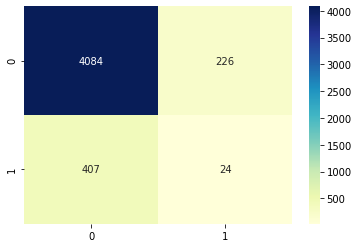

In [ ]:
labels = np.array([['4084','226'],['407','24']])
sns.heatmap(cm, annot=labels, fmt = '', cmap="YlGnBu")
plt.show()

Looking at the plot above, we can see that there's a clear unbalance between the left and right side, a possible indication that our model is biased towards labeling a movie as *unsuccessful*. However, in real life, there are a lot more unsucessful movies than successful ones, so we think this bias isn't too much of a problem as long as there is a good number of true positives. 

This plot shows the number of true positives, true negatives, false negatives, and false positives. In terms of the context of our model, their definitions are as follows:


*   *True positive*: A movie is predicted to be successful and it actually does become successful in real life
*   *True negative*: A movie is not predicted to be successful, which also turns out to be true in real life
*   *False positive*: A movie is predicted to be successful but it actually doesn't in real life
*   *False negative*: A movie is predicted to be not successful but turns out to be otherwise in real life



We will now find the area under the curve (AUC) for ROC. This will further show if our model is doing well with discriminating between the two classes we have. 

We referenced [this](https://stackoverflow.com/questions/43043271/roc-curve-for-binary-classification-in-python) StackOverFlow post to write the code for plotting the ROC curve.

In [ ]:
y_pred_prob = gs_clf.predict_proba(x_val)
metrics.roc_auc_score(y_val, y_pred_prob[:,1])

0.5626716587443004

In [ ]:
metrics.roc_auc_score(y_val, y_pred_prob[:,0])

0.4373283412556995

Let's try calculating AUC for the train dataset as well and make sure our model isn't overfitting.

In [ ]:
y_pred_train_prob = gs_clf.predict_proba(x_train)
metrics.roc_auc_score(y_train, y_pred_train_prob[:,1])

0.9999999679329848

In [ ]:
metrics.roc_auc_score(y_train, y_pred_train_prob[:,0])

3.206701517040616e-08

Wow, as we can see, compared to the validation dataset, our model perfectly predicts the train dataset, which very likely means that our model is ***overfitting***. For better visualization, we will graph the ROC curve for both training and validation datasets. 



In [ ]:
y_pred_t = gs_clf.predict(x_train)

0.5016241299303944


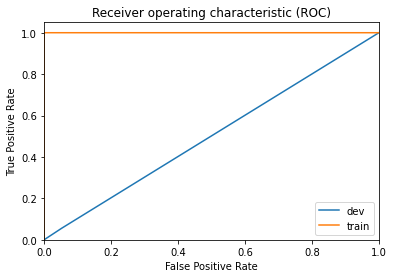

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_dt)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_t)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_dt))
plt.figure()
plt.plot(fpr[1], tpr[1],)
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

As we can see above, our model is not performing too well and is clearly overfitting to the training data. 

To reduce overfitting, let's tune the hyperparameters again. One reason for overfitting may be due to the fact that the depth of our tree was too large, as more depth means more opportunity for our model to extract more information about our training data at each depth. Because of this, we will try **reducing the depth to 10, 20, and 30**.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

In [ ]:
y_pred_dt_10 = dt_10.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt_10))

              precision    recall  f1-score   support

           0       0.91      0.80      0.86      4310
           1       0.11      0.25      0.16       431

    accuracy                           0.75      4741
   macro avg       0.51      0.53      0.51      4741
weighted avg       0.84      0.75      0.79      4741



In [ ]:
cm = metrics.confusion_matrix(y_val, y_pred_dt_10)
print(cm)

[[3460  850]
 [ 322  109]]


In [ ]:
y_pred_t_10 = dt_10.predict(x_train)

0.5278422273781903


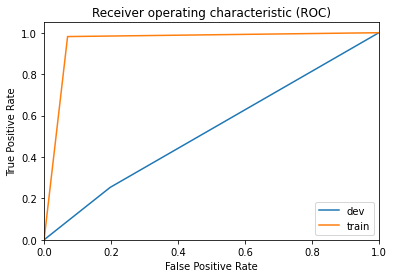

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_dt_10)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_t_10)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_dt_10))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

Here, we see there is still an overfitting happening. Instead of 20 and 30, let's further reduce the max_depth parameter to 5.



In [ ]:
dt_5 = BaggingClassifier(DecisionTreeClassifier(max_depth=5))
dt_5.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred_dt_5 = dt_5.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt_5))

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      4310
           1       0.12      0.51      0.19       431

    accuracy                           0.60      4741
   macro avg       0.52      0.56      0.46      4741
weighted avg       0.85      0.60      0.69      4741



In [ ]:
cm = metrics.confusion_matrix(y_val, y_pred_dt_5)
print(cm)

[[2627 1683]
 [ 211  220]]


In [ ]:
y_pred_t_5 = dt_5.predict(x_train)

0.5599767981438516


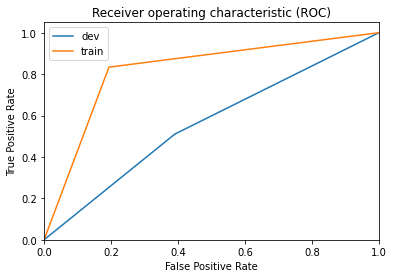

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_dt_5)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_t_5)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_dt_5))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

What's notable here is that although there is less overfitting now and we can see a small "bump" between 0.2 and 0.4 for for the devset line. However, the recall for negative class noticeably decreased. This may be due to the fact that the number of false positives has significantly increased. To balance this, let's try the number between 5 and 10, which is about 7 for the last time. 

In [ ]:
dt_7 = BaggingClassifier(DecisionTreeClassifier(max_depth=7))
dt_7.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred_dt_7 = dt_7.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt_7))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      4310
           1       0.12      0.39      0.18       431

    accuracy                           0.68      4741
   macro avg       0.52      0.55      0.49      4741
weighted avg       0.85      0.68      0.74      4741



In [ ]:
cm = metrics.confusion_matrix(y_val, y_pred_dt_7)
print(cm)

[[3042 1268]
 [ 265  166]]


In [ ]:
y_pred_t_7 = dt_7.predict(x_train)

0.545475638051044


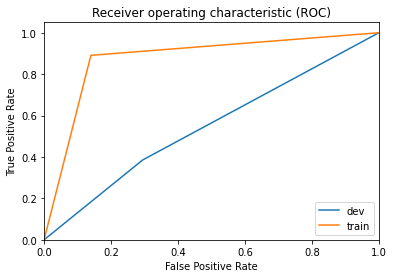

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_dt_7)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_t_7)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_dt_7))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

We can see that there is slightly more overfitting than with max_depth equal to 5, but recall for negative class increased. However, we see that F1 score slightly decreased by 0.01 compared to the first model without decreasing the max_depth. 

Overall, it seems to be that Bagged Decision Tree Classifier is currently not the best, considering its precision and recall score. It could be that resampling did not help too much and unbalance in the validation dataset also caused our model to become biased towards negative class. It also seems like there is a problem with overfitting, considering the large gap between validation and train ROC curves. 

### Random Forest Classifier

Next, we will explore Random Forest Classifier, which is known to be highly accurate and popular. This classifier is similar to bagged decision tree classifier, but is mainly different as it also randomly samples not only training dataset, but also features. It is also more robust than decision trees.



*   Seeing that too large depths didn't work too well for bagged decision tree, we will try out lower max_depth values: **7, 10, 17**



In [ ]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'max_depth' : [7, 10, 17], 
}
rf = RandomForestClassifier(n_estimators=200)
rf_gs = GridSearchCV(estimator = rf, param_grid = param_grid)
rf_gs.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
rf_gs.best_params_

{'max_depth': 17}

Interestingly, grid search outputted 17 as the best max_depth, which is obviously greater than 7 and 10. We will do another round of model evaluation to see what we could do next.

In [ ]:
y_pred_rf_17 = rf_gs.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, y_pred_rf_17))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4310
           1       0.11      0.09      0.10       431

    accuracy                           0.85      4741
   macro avg       0.51      0.51      0.51      4741
weighted avg       0.84      0.85      0.84      4741



This result is quite similar to what we got with bagged decision tree classifier. The precision and recall are quite low for positive class while those for the negative class is very high. The f1-score, however, is slightly higher.

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_rf_17)
print(cm)

[[3989  321]
 [ 391   40]]


We can see that there is still some unbalance between the predictions our model makes. 

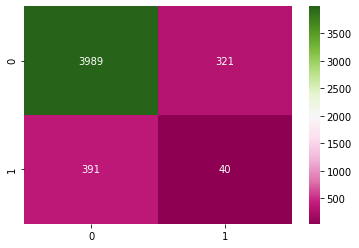

In [ ]:
labels = np.array([['3989','321'],['391','40']])
sns.heatmap(cm, annot=labels, fmt = '', cmap="PiYG")
plt.show()

In [ ]:
y_pred_rf_t_17 = rf_gs.predict(x_train)

0.5091647331786544


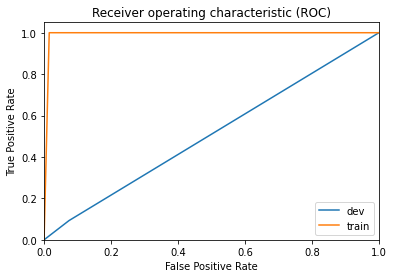

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_rf_17)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_rf_t_17)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_rf_17))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

Given that grid search returned the highest max_depth among the values we tried, let's try a slightly higher value: **20**

In [ ]:
rf_20 = RandomForestClassifier(n_estimators=200, max_depth=20)
rf_20.fit(x_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_rf_20 = rf_20.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, y_pred_rf_20))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4310
           1       0.08      0.01      0.02       431

    accuracy                           0.90      4741
   macro avg       0.49      0.50      0.48      4741
weighted avg       0.83      0.90      0.86      4741



In [ ]:
print(metrics.roc_auc_score(y_val, y_pred_rf_20))

0.49895591647331783


Looking at thee precision and recall scores for the positive class, we can see that they got even lower compared to when the depth was equal to 17. This means that it's likely that the model was even more biased towards the negative class. Let's try a lower depth of **10**. 

In [ ]:
rf_10 = RandomForestClassifier(n_estimators=200, max_depth=10)
rf_10.fit(x_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_rf_10 = rf_10.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, y_pred_rf_10))

              precision    recall  f1-score   support

           0       0.93      0.61      0.73      4310
           1       0.12      0.53      0.19       431

    accuracy                           0.60      4741
   macro avg       0.52      0.57      0.46      4741
weighted avg       0.85      0.60      0.69      4741



In [ ]:
print(metrics.roc_auc_score(y_val, y_pred_rf_10))

0.567401392111369


We see similar trend as we did with the bagged decision tree classifier. While precision and recall increased for the positive class, recall noticeably decreased for the negative class. Overall, it seems to be our random forest model performs slightly(by very small amount) better than bagged decision tree model when looking at the precision and recall scores in general.

### ** EXTRA EXPERIMENT **

Just an experiment after submitting the final project to figure out ways to improve the model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=300, max_samples=30, max_depth=30, max_features=None, oob_score=True, class_weight="balanced")
random_forest.fit(x_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features=None,
                       max_leaf_nodes=None, max_samples=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
random_forest_pred = random_forest.predict(x_val)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_val, random_forest_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4330
           1       0.00      0.00      0.00       411

    accuracy                           0.91      4741
   macro avg       0.46      0.50      0.48      4741
weighted avg       0.83      0.91      0.87      4741



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, random_forest_pred)
print(cm)

[[4330    0]
 [ 411    0]]


In [ ]:
random_forest_pred_t = random_forest.predict(x_train)

In [ ]:
print(metrics.classification_report(y_train, random_forest_pred_t))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21599
           1       0.00      0.00      0.00      2106

    accuracy                           0.91     23705
   macro avg       0.46      0.50      0.48     23705
weighted avg       0.83      0.91      0.87     23705



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_train, random_forest_pred_t)
print(cm)

[[21599     0]
 [ 2106     0]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(x_train, np.ravel(y_train))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=0)

In [ ]:
adaboost_pred = clf.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, adaboost_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4330
           1       0.67      0.36      0.47       411

    accuracy                           0.93      4741
   macro avg       0.81      0.67      0.71      4741
weighted avg       0.92      0.93      0.92      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, adaboost_pred)
print(cm)

[[4258   72]
 [ 264  147]]


In [ ]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(max_iter=400).fit(x_train, np.ravel(y_train))
y_pred_lr = lr.predict(x_val)
metrics.accuracy_score(y_val, y_pred_lr)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9270196161147437

In [ ]:
print(metrics.classification_report(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4330
           1       0.67      0.31      0.43       411

    accuracy                           0.93      4741
   macro avg       0.80      0.65      0.69      4741
weighted avg       0.91      0.93      0.91      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, adaboost_pred)
print(cm)

[[4258   72]
 [ 264  147]]




---



In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
x_train_u, y_train_u = ros.fit_resample(x_train, y_train)
x_train_u = pd.DataFrame(x_train_u, columns=features.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_train_u = pd.DataFrame(y_train_u)
print(y_train_u.value_counts())

1    2081
0    2081
dtype: int64


In [ ]:
x_train_u

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,155.0,0.0,0.0,0.0,8.0,2.0,15.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,129.0,0.0,0.0,1.0,10.0,3.0,15.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,90.0,0.0,0.0,0.0,17.0,2.0,12.0,11.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,123.0,0.0,0.0,0.0,16.0,3.0,15.0,11.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,80.0,0.0,0.0,0.0,59.0,3.0,14.0,11.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4157,124.0,0.0,0.0,1.0,14.0,1.0,15.0,12.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4158,81.0,0.0,0.0,1.0,35.0,3.0,15.0,12.0,4.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4159,127.0,1.0,1.0,0.0,8.0,3.0,15.0,9.0,3.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4160,170.0,0.0,0.0,0.0,23.0,3.0,15.0,11.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
y_train_u = pd.DataFrame(y_train_u)
print(y_train_u.value_counts())

1    2106
0    2106
dtype: int64


In [ ]:
y_train_u

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
x_train_u

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
23946,102.0,0.0,0.0,0.0,8.0,1.0,15.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31575,130.0,0.0,0.0,0.0,19.0,2.0,15.0,9.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
488,129.0,0.0,0.0,0.0,30.0,3.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15370,102.0,0.0,0.0,0.0,13.0,1.0,15.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8235,157.0,0.0,0.0,0.0,33.0,3.0,15.0,11.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4140,100.0,0.0,0.0,0.0,12.0,3.0,15.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1895,99.0,0.0,0.0,0.0,7.0,3.0,15.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16556,170.0,0.0,0.0,0.0,5.0,1.0,14.0,10.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19702,75.0,0.0,0.0,0.0,24.0,2.0,4.0,10.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=300, max_samples=30, max_depth=30, max_features=None, oob_score=True, class_weight="balanced")
random_forest.fit(x_train_u, np.ravel(y_train_u))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features=None,
                       max_leaf_nodes=None, max_samples=30,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
random_forest_pred = random_forest.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, random_forest_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      4330
           1       0.26      0.77      0.39       411

    accuracy                           0.79      4741
   macro avg       0.62      0.78      0.63      4741
weighted avg       0.91      0.79      0.83      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, random_forest_pred)
print(cm)

[[3418  912]
 [  94  317]]


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(x_train_u, np.ravel(y_train_u))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=0)

In [ ]:
lr_p = LogisticRegression(max_iter=400, penalty="l1", C=0.0001, solver='saga').fit(x_train, np.ravel(y_train)) # C is inversely related - lower the C value, greater the penalty
y_pred_lr_p = lr_p.predict(x_val)
metrics.accuracy_score(y_val, y_pred_lr_p)

In [ ]:
print(metrics.classification_report(y_val, adaboost_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      4330
           1       0.29      0.79      0.43       411

    accuracy                           0.82      4741
   macro avg       0.63      0.81      0.66      4741
weighted avg       0.92      0.82      0.85      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, adaboost_pred)
print(cm)

[[3540  790]
 [  85  326]]


In [ ]:
adaboost_pred_t = clf.predict(x_train_u)

0.8053696554901862


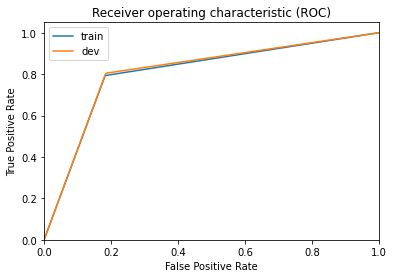

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, adaboost_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train_u, adaboost_pred_t)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, adaboost_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

In [ ]:
lr_p = LogisticRegression(max_iter=3000, penalty="l2", C=1, solver='lbfgs').fit(x_train_u, np.ravel(y_train_u)) # C is inversely related - lower the C value, greater the penalty
y_pred_lr_p = lr_p.predict(x_val)
metrics.accuracy_score(y_val, y_pred_lr_p)

0.8000421851929973

In [ ]:
lr_pred = lr_p.predict(x_val)

In [ ]:
print(metrics.classification_report(y_val, lr_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88      4330
           1       0.27      0.79      0.41       411

    accuracy                           0.80      4741
   macro avg       0.62      0.79      0.64      4741
weighted avg       0.91      0.80      0.84      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, lr_pred)
print(cm)

[[3470  860]
 [  88  323]]


oversampling didn't work because each time it was resampling, it was repeating the same data frmo the original dataset, and those repeated data may have not been representative of the entire original dataset for the positive class. 

In [ ]:
clf_pred_test = clf.predict(x_test)

In [ ]:
print(metrics.classification_report(y_test, clf_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      2896
           1       0.27      0.75      0.40       265

    accuracy                           0.81      3161
   macro avg       0.62      0.78      0.64      3161
weighted avg       0.91      0.81      0.85      3161



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, clf_pred_test)
print(cm)

[[2366  530]
 [  66  199]]


0.8053696554901862


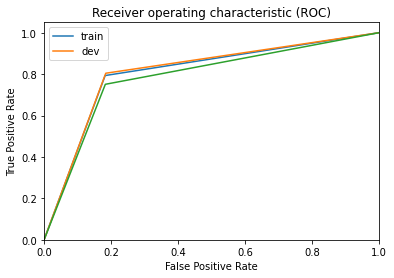

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, adaboost_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train_u, adaboost_pred_t)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

fpr_te = dict()
tpr_te = dict()
roc_auc = dict()
for i in range(2):
    fpr_te[i], tpr_te[i], _ = roc_curve(y_test, clf_pred_test)
    roc_auc[i] = auc(fpr_te[i], tpr_te[i])


print(metrics.roc_auc_score(y_val, adaboost_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.plot(fpr_te[1], tpr_te[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_val, adaboost_pred)
print(average_precision)

0.24963038751289446


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.25')

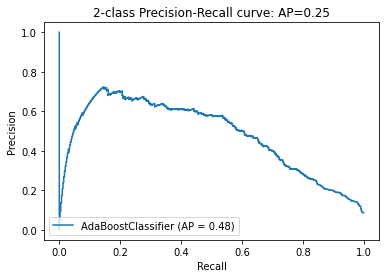

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, x_val, y_val)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))



---



In [ ]:
import sklearn as sk
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NN.fit(x_train_u, y_train_u)
nn_pred = NN.predict(x_val)
round(NN.score(x_train_u,y_train_u), 4)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_val, nn_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4321
           1       0.00      0.00      0.00       420

    accuracy                           0.91      4741
   macro avg       0.46      0.50      0.48      4741
weighted avg       0.83      0.91      0.87      4741



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_train = pd.DataFrame(y_train)
print(y_train.value_counts())

0
1    2077
0    2077
dtype: int64


In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-0.662462,-1.302330,-2.521412,2.151727,0.749436,1.265609,0.993858,0.778330,-1.991140,-1.291973,1.006563,-0.133946,0.523620,-1.534394,0.467955,0.441535,0.046777,0.094298,0.687694,0.447651,0.194289,0.128511,-0.737098,0.331520,-0.002014,0.170969,0.008150,0.428281,0.187876,-0.104589,-0.274133,0.236742,-0.238019,-0.044573,0.584285,-0.278959,-0.271349,-0.630551,0.546906,0.495275,-0.804551,-0.237606,0.266990,1.637353,-1.772505,-1.112124,-1.461480,-0.428126,-1.109788,0.775236
1,-1.908173,0.341518,2.416646,-1.278812,-0.594527,-0.318825,-1.189158,-1.382558,-0.324709,-0.919026,2.228797,2.554797,0.815147,-4.010117,0.420827,-1.108953,2.988187,-0.515034,-0.834979,4.703800,0.479226,-1.745663,-4.210807,2.147579,-0.589542,3.708986,0.528945,2.285981,-2.292287,1.349765,-2.788154,-1.813541,2.536297,0.527865,-4.541242,-1.106190,-1.472912,1.271831,-1.693505,-0.231287,0.788047,0.764569,0.208916,0.306125,0.499956,0.465418,0.149595,-0.370782,-0.325306,-0.274434
2,-2.528002,0.839418,0.153814,-1.611214,1.147645,0.250331,0.134342,-1.365795,-1.509152,-0.668453,0.901676,-0.982786,-0.991665,0.567308,0.841542,-0.186260,0.423445,-0.159997,-0.219948,0.027559,-0.018288,0.247490,0.071451,-0.044554,0.175743,0.143136,-0.059545,0.089353,0.105379,0.123549,0.292761,0.243903,-0.094118,-0.048789,0.456026,0.236727,0.793264,-0.324823,-0.018389,-0.155792,-0.150369,0.305651,0.303518,0.197693,0.266080,0.121510,0.090874,-0.060725,-0.272799,0.636049
3,2.922103,1.267182,1.593938,-0.721337,0.447252,-0.424844,-0.412090,-0.750281,-0.348588,-0.360074,0.146268,0.274539,1.758429,0.458990,-0.385228,-0.326029,-0.090459,-0.082266,-0.260964,0.498845,0.249990,0.079820,-0.174452,0.433445,-0.489291,-0.023755,0.048188,-0.206966,0.015195,-0.989921,-0.007919,0.078843,0.085245,-0.242495,0.077118,-1.737779,0.371351,0.271328,1.385301,-1.632834,0.060127,-0.090614,-0.170044,-0.399752,-0.086474,-0.525228,0.412201,-0.413508,-0.310921,0.908873
4,-2.316361,0.848231,-0.799284,0.206550,-1.432325,-1.416996,0.420047,0.561229,0.083513,-0.858793,-1.250733,0.452095,0.935052,-1.380466,-2.685054,1.713182,0.592842,-0.074474,0.697524,-3.106116,-0.531823,-0.942904,0.602547,-0.660361,-0.143140,-1.134975,0.375839,-0.562631,-0.199748,0.407657,0.408403,0.001385,-0.488563,-0.419814,-2.063175,-0.009361,0.681883,1.113056,-0.746075,-1.379086,1.323195,1.843478,0.494855,-0.921611,-0.790459,-0.086153,-1.254826,0.575074,0.872587,-0.545375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4149,1.935556,-0.390326,0.186914,0.538474,-0.587533,-1.264814,-1.041401,0.056588,-0.537663,0.767739,-0.428684,-0.321252,0.546165,0.737740,-1.037183,-0.158310,0.053565,0.425411,0.231197,0.643006,-0.357597,-0.158807,-0.228809,0.150912,-0.342375,0.137359,-0.072495,-0.041249,0.137005,-0.467429,0.020298,-0.097637,-0.122593,-0.456869,0.102818,-1.375397,-1.013348,0.341430,0.434876,-1.554572,0.817451,0.713481,-0.119974,-0.273527,-0.974270,-0.236029,0.083074,-0.967314,0.318216,1.148673
4150,-0.168517,0.010633,-0.097247,-1.684053,-0.282317,-2.785102,0.907688,1.170484,0.105561,-0.878996,-0.687500,1.209220,-0.509269,-0.485858,0.345958,-0.644686,0.168871,-0.499644,-0.515530,-0.255997,0.094019,-0.030706,0.471464,0.342015,-0.047626,0.367913,0.222507,0.181440,-0.560448,0.138179,-0.387684,0.565951,-0.358736,0.600854,0.160565,0.635547,1.042683,-0.936736,1.038915,0.338923,-0.902556,0.489086,-0.113788,-0.485351,-1.504701,1.274119,0.446443,-0.395728,-0.091170,-0.153932
4151,-0.176647,-0.528536,-0.507058,-1.521951,0.162853,0.717092,-1.673636,-0.251731,-0.359708,0.696633,0.986780,0.646725,0.278607,-0.595019,-0.155688,0.419513,0.074865,-0.057404,0.219390,-0.051357,-0.238661,0.264919,0.111911,0.436539,-0.344346,0.389748,0.014675,0.133643,0.005076,-0.394387,0.104653,0.118751,

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf_u = AdaBoostClassifier(n_estimators=200, random_state=0)
clf_u.fit(x_train_scaled, np.ravel(y_train))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=0)

In [ ]:
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,11711.0,0.548975,-1.155053,-0.179395,0.407383,-1.013813,0.588664,-1.329976,28877.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,17738.0,-0.106028,-1.259200,-0.179395,0.407383,-1.298416,0.588664,-1.329976,8600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,13361.0,-1.063341,-1.050906,1.043661,0.407383,-0.160004,-0.387023,-0.456504,19039.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,15320.0,-0.106028,-0.217731,-0.179395,0.407383,0.978407,-0.387023,1.290438,12812.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,13170.0,-0.408338,-0.217731,-1.402452,-3.614698,0.978407,-0.387023,1.290438,16507.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4103,23673.0,0.498590,-0.009437,1.043661,0.407383,0.124599,0.588664,0.416967,5861.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4104,23684.0,0.095511,0.407150,1.043661,0.407383,-1.013813,0.588664,-1.329976,21538.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4105,23686.0,1.153594,0.511297,-1.402452,0.407383,-1.583019,-0.387023,-1.329976,3569.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4106,23689.0,0.649745,0.198857,1.043661,0.407383,0.978407,0.588664,1.290438,9540.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
y_pred_u = clf_u.predict(x_val_scaled)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_val, y_pred_u))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      4311
           1       0.27      0.78      0.40       430

    accuracy                           0.79      4741
   macro avg       0.62      0.78      0.63      4741
weighted avg       0.91      0.79      0.83      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_u)
print(cm)

[[3394  917]
 [  95  335]]


In [ ]:
from sklearn.linear_model import LogisticRegression
lr_p = LogisticRegression(max_iter=3000, penalty="l2", C=1, solver='lbfgs').fit(x_train_scaled, np.ravel(y_train)) # C is inversely related - lower the C value, greater the penalty
y_pred_lr_p = lr_p.predict(x_val_scaled)
metrics.accuracy_score(y_val, y_pred_lr_p)

0.6568234549673064

Why is it that doing just imputation + sampling results in much better result? 

Doing resampling after imputation and scaling + PCA still resulted in pretty bad scores (slightly better than a default one but still bad)

Doing imputation than scaling on numerical columns and then doing pca and resampling still resulted in bad scores... so interesting. 

**Results below are only with imputation without resampling**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_p = LogisticRegression(max_iter=3000, penalty="l2", C=1, solver='lbfgs').fit(x_train, np.ravel(y_train)) # C is inversely related - lower the C value, greater the penalty
y_pred_lr_p = lr_p.predict(x_val)
metrics.accuracy_score(y_val, y_pred_lr_p)

0.9306053575195107

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_lr_p)
print(cm)

[[4257   53]
 [ 276  155]]


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_val, y_pred_lr_p))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4310
           1       0.75      0.36      0.49       431

    accuracy                           0.93      4741
   macro avg       0.84      0.67      0.72      4741
weighted avg       0.92      0.93      0.92      4741



In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf_u = AdaBoostClassifier(n_estimators=200, random_state=0)
clf_u.fit(x_train, np.ravel(y_train))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=0)

In [ ]:
clf_pred = clf_u.predict(x_val)
metrics.accuracy_score(y_val, clf_pred)

0.9297616536595655

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, clf_pred)
print(cm)

[[4246   64]
 [ 269  162]]


**The results below are just doing imputation and then sampling without scaling or PCA.**





In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
x_train_u, y_train_u = ros.fit_resample(x_train, y_train)
x_train_u = pd.DataFrame(x_train_u, columns=features.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_train_u

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,115.0,0.0,0.0,0.0,11.0,2.0,15.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,70.0,0.0,0.0,0.0,7.0,1.0,11.0,9.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,108.0,0.0,0.0,0.0,17.0,1.0,15.0,11.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,91.0,0.0,0.0,1.0,11.0,3.0,15.0,11.0,5.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,96.0,0.0,0.0,1.0,28.0,2.0,15.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4149,116.0,0.0,0.0,1.0,8.0,3.0,15.0,5.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4150,139.0,0.0,1.0,1.0,10.0,1.0,15.0,10.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4151,97.0,0.0,0.0,1.0,14.0,2.0,13.0,9.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4152,115.0,1.0,0.0,1.0,5.0,1.0,15.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pu = LogisticRegression(max_iter=3000, penalty="l2", C=1, solver='lbfgs').fit(x_train_u, np.ravel(y_train_u)) # C is inversely related - lower the C value, greater the penalty
y_pred_lr_pu = lr_pu.predict(x_val)
metrics.accuracy_score(y_val, y_pred_lr_pu)

0.8261970048512972

In [ ]:
print(metrics.classification_report(y_val, y_pred_lr_pu))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      4310
           1       0.32      0.78      0.45       431

    accuracy                           0.83      4741
   macro avg       0.65      0.81      0.67      4741
weighted avg       0.91      0.83      0.86      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_lr_pu)
print(cm)

[[3579  731]
 [  93  338]]


In [ ]:
x_train

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
16903,134.0,0.0,0.0,0.0,8.0,2.0,13.0,11.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20267,118.0,0.0,0.0,1.0,28.0,3.0,15.0,10.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6524,100.0,0.0,0.0,0.0,12.0,1.0,15.0,12.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31472,116.0,0.0,0.0,0.0,8.0,3.0,15.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
25024,79.0,0.0,0.0,0.0,16.0,2.0,15.0,11.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,130.0,0.0,0.0,1.0,12.0,2.0,15.0,10.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3511,86.0,0.0,0.0,0.0,20.0,1.0,15.0,11.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5126,104.0,0.0,0.0,1.0,25.0,3.0,15.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5421,115.0,0.0,0.0,0.0,12.0,3.0,15.0,6.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


It seems to be that with resampling, there are a lot more false positives compared to withuot sampling, where there are a lot less false positives and much more false negatives. Unbalanced set -> increased likelihood of choosing the class with moroe instances -> would've actuall y been better for us since in reality, there are more unsuccessful movies than succesful ones. This shows that resampling is based on case by case. Probably more recommended for the situation when reality isn't biased but have biased dataset. maybe? it seems like theres never a right answer for everything and it depends on case by case basis. 

### Logistic Regression

We will explore logistic regression next, which is another well known model for binary classification



In [ ]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(max_iter=400).fit(x_train, np.ravel(y_train))
y_pred_lr = lr.predict(x_val)
metrics.accuracy_score(y_val, y_pred_lr)

0.5051676861421641

Once more, we will calculate precision, recall, and f1 score.

In [ ]:
print(metrics.classification_report(y_val, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.50      0.65      4310
           1       0.10      0.56      0.17       431

    accuracy                           0.51      4741
   macro avg       0.51      0.53      0.41      4741
weighted avg       0.85      0.51      0.60      4741



We once again see that most of these values are quite low. We will also create a confusion matrix like before.

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_lr)
print(cm)

[[2152 2158]
 [ 188  243]]


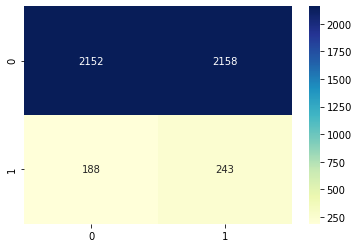

In [ ]:
labels = np.array([['2152','2158'],['188','243']])
sns.heatmap(cm, annot=labels, fmt = '', cmap="YlGnBu")
plt.show()

We see that although there are quite a few true positives, the number of false positives is quite high, which explains the low recall score for the negative class. 

Let's check and see if this model overfit the train dataset like bagged decision tree and random forest

In [ ]:
y_pred_lr_t = lr.predict(x_train)

0.5315545243619488


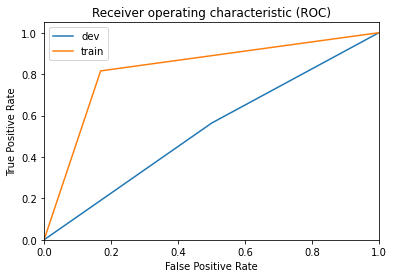

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_lr)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_lr_t)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_lr))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

AUC for ROC curve is one of the highest ones we have seen so far! It seems to be that the model is not overfitting too much. However, let's try and add L1 penalty to see if the model improves. We will add L1 penalty since we still have quite a few features and there isn't much collinearity, according to the [correlation matrix](#set-correlation) we plotted earlier. 

In [ ]:
lr_p = LogisticRegression(max_iter=400, penalty="l1", C=0.0001, solver='saga').fit(x_train, np.ravel(y_train)) # C is inversely related - lower the C value, greater the penalty
y_pred_lr_p = lr_p.predict(x_val)
metrics.accuracy_score(y_val, y_pred_lr_p)

0.6118962244252267

In [ ]:
print(metrics.classification_report(y_val, y_pred_lr_p))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74      4310
           1       0.13      0.59      0.22       431

    accuracy                           0.61      4741
   macro avg       0.54      0.60      0.48      4741
weighted avg       0.86      0.61      0.69      4741



We see that by applying L1 penalty, the overall precision and recall score for both positive and negative classes increased. F1 score also increased by 0.07 as well.

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_lr_p)
print(cm)

[[2646 1664]
 [ 176  255]]


In [ ]:
y_pred_lr_tp = lr_p.predict(x_train)

In [ ]:
print(metrics.classification_report(y_train, y_pred_lr_tp))

              precision    recall  f1-score   support

           0       0.75      0.78      0.77     21628
           1       0.77      0.74      0.76     21628

    accuracy                           0.76     43256
   macro avg       0.76      0.76      0.76     43256
weighted avg       0.76      0.76      0.76     43256



0.6027842227378191


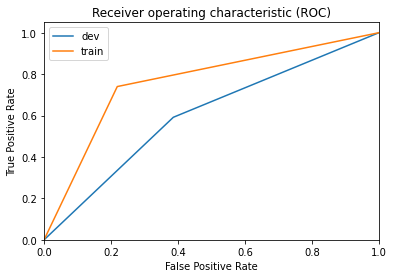

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_lr_p)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_lr_tp)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_lr_p))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

This is the highest AUC for any ROC curve plotted so far. It also shows that the model is not overfitting the train dataset too much. 

Before we move on, let's try plotting precision-recall curve. We referenced the [code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) from scikit website. This will further show us a trade off between precision and recall score and the threshold at which the trade off is ideal.

In [ ]:
# calculating average precision-recall score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_val, y_pred_lr_p)
print(average_precision)

0.11574207854293794


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.12')

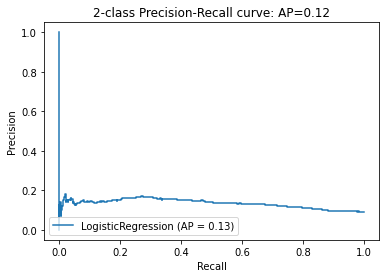

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr_p, x_val, y_val)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

As we have observed earlier from the precision and recall scores for positive and negative classes, lower recall results in **much** higher precision scores, and increasing recall results in lower and lower precision scores. Ideally, we would have logisitical curve but here, we see that the rate at which precision score decreases with an increasing recall score is *very* fast between 0.0 and 0.2 recall score. 



Compared to the two tree classifiers we explored before this one, this models seems to be less prone to overfitting and performs slightly better.

### Support Vector Machine

Lastly, we will try Support Vector Machine, which is another well-known binary classification model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

svm_clf = SVC(kernel='linear')
svm_clf.fit(x_train, np.ravel(y_train))
y_pred_svm = svm_clf.predict(x_val)
accuracy_score(y_val, y_pred_svm)

0.5146593545665471

Let's do the another round of evaluation for the model. 

In [ ]:
print(metrics.classification_report(y_val, y_pred_svm))

              precision    recall  f1-score   support

           0       0.92      0.51      0.66      4310
           1       0.10      0.55      0.17       431

    accuracy                           0.51      4741
   macro avg       0.51      0.53      0.41      4741
weighted avg       0.84      0.51      0.61      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_svm)
print(cm)

[[2203 2107]
 [ 194  237]]


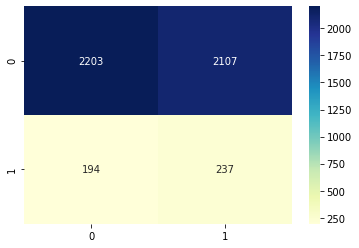

In [ ]:
labels = np.array([['2203','2107'],['194','237']])
sns.heatmap(cm, annot=labels, fmt = '', cmap="YlGnBu")
plt.show()

Looking at the confusion matrix and precision and recall scores for positive negative scores, we can see that our model is incorrectly identifying many movies in general. We can see that although the confusion matrix is balanced, there are many false positives. 

Let's try graphing the ROC curve and caculate average precision-recall score.

In [ ]:
y_pred_svm_tp = svm_clf.predict(x_train)

0.6027842227378191


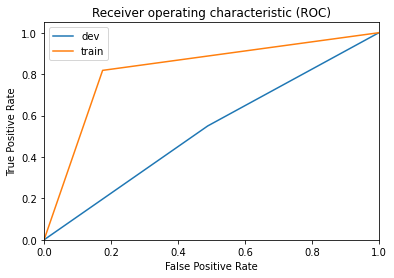

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val, y_pred_svm)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_svm_tp)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])

print(metrics.roc_auc_score(y_val, y_pred_lr_p))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'dev','train'})
plt.show()

In [ ]:
average_precision = average_precision_score(y_val, y_pred_svm)
print(average_precision)

0.09651797585941532


As with other models we have tried, this model is not performing too well with our evaluations. 

# Conclusion

### Best Model

Looking at the models we have trained and tested with the validation set, it was difficult to decide which evaluation measurement to look at, given that the validation set was heavily unbalanced and the some evaluation metrics relied on the number of instances for each class, which is why we didn't focus on the accuracy score. Given this challenge, we decided to also consider the context of the problem the model is trying to solve, while looking at the numbers we calculated.


> *What do people prefer to get from this model: a false hope that the movie will succeed or a confirmation that a movie will indeed succeed?*

Thinking about this, it was rather obvious that giving false hope (false positive) is more detrimental, even when compared to the situation when our model predicts that a movie will not succeed even though it actually will succeed (false negative). Such false hope can lead to an economic loss, as many more people may decide to invest in the movie. And psychologically, good surprises tend to be better.

Thus, considering all of these factors, we decided to go with **bagged decision tree classifier with a maximum depth of 10**. This model had a slightly higher precision recall score for the positive class, while also maintaining a pretty high recall score for negative class. One thing we noticed with higher score for positive class was that recall score for negative class decreased at the same time. Thus, this model had a good balance for precision and recall scores, as we want to make sure we are not predicting too many false positives while also avoiding terrible performance on the true positives.  

The result on the test set were as follows:






In [ ]:
y_pred_test = dt_10.predict(x_test)
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      2887
           1       0.13      0.30      0.18       274

    accuracy                           0.76      3161
   macro avg       0.52      0.55      0.52      3161
weighted avg       0.85      0.76      0.80      3161



In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred_test)
print(cm)

[[2308  579]
 [ 191   83]]


In [ ]:
y_pred_dt_7_test = dt_7.predict(x_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred_dt_7_test))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80      2887
           1       0.12      0.44      0.19       274

    accuracy                           0.67      3161
   macro avg       0.52      0.57      0.49      3161
weighted avg       0.86      0.67      0.74      3161



### Challenges



Given that this was the first time we worked on doing all of the data processing and training the model without any explicit guidelines, there were several challenges we faced at each of the steps throughout.

There were two big challenges we faced. The first challenge came with feature engineering for our dataset. Because our model was purposed to predict success of movies *before* a movie is released, we dropped many numerical columns like reviews and scores, as those are obtained only after the release. This left a lot of categorical columns to deal with. These categorical columns had many possible values, which might have not been helpful for our model as data may be spread out too much and some values may not have enough data to accurately predict later on. Because of this, we had to look for ways to interpret these columns and represent them with something more simple while still retaining their meanings. 

Another challenge we faced was with how to evaluate our model and identify *why* our model wasn't performing too well. This was probably the biggest challenge we faced. Because our validation dataset was unbalanced (many more negative than positive instances), we had to ensure that when we look at precision and recall scores, especially recall, we kept this in mind. This is because for precision for the negative class, the number of false negatives we could get was very limited, which was why we made that observation early on. In fact, we could see that precision for negative class stayed very high in all of the different models we tried. 

With identifying the problem for our model, there are several speculations we can make. First is that perhaps, resampling didn't work too well. Since resampling involved repeating some data and because there was a huge proportional difference between positive and negative instances (1/10), a more diverse dataset may have been needed. Second is that there was overfitting. We saw that our model was doing extremely well with the train data, which means that our model is learning to a certain extent. This leads to a quite contradicting third speculation, which is that our features were not too great at predicting success of movies in general. Whenever we mitigated overfitting, there would be notable increase in false positives, as if the model was not learning so much. Predicting a movie's success is known to be a very difficult problem, and it may be that our features were not sufficient or effective. Perhaps, if we focused on guessing whether a movie was successful or not for movies that were already released, we may have been able to incorporate reviews and scores, which would have helped.

### Next steps

Moving forward, there are certain improvements we can try to help our models perform better.


*   Hyperparameter tuning for different variables. For example, besides max_depth for tree classifiers, we would like to see if we could tune other parameters like n_estimators. 
*   Try deep learning (use libraries like Pytorch to build a classification model from sketch, which would allow us to tune the model in much more detail). 
*   Figure out ways to check correlation between the each of the features and success of movies. This would give more insights as to how good the features are to this task of predicting movie's success.
*   If time allows, for curiosity, build a similar model for guessing if a movie was successful (making predictions on movies that have already been released). We want to see how this adding reviews and scores would affect the performance of the model.



# Improvement (5/26/21)

Given relatively low accuracy we got from the earlier models, I tried to look for ways to improve. Earlier, we *resampled* the data to balance successful and unsuccessful movies. We used oversampling at that time. However, looking back, resampling meant randomly sampling same movies multiple times for the successful movies, which may have negatively affected the representation of successful movies. 

Thus, we will first experiment with undersampling and then not sampling at all. I think that not doing sampling at all will also be fine, given that more movies tend to be unsuccessful as well. 

Note that we are not doing PCA or rescaling here because we will experiment with this too. Everything else is controlled. 

## Experiment 1: Sampling methods

### Undersampling

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
x_train_under, y_train_under = ros.fit_resample(x_train, y_train)
x_train_under = pd.DataFrame(x_train_under, columns=features.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
y_train_under = pd.DataFrame(y_train_under);
print(y_train_under.value_counts())

1    2074
0    2074
dtype: int64


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train_under, y_train_under)
y_pred_dt = dt_10.predict(x_val)
metrics.accuracy_score(y_pred_dt, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8169162623919004

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      4318
           1       0.30      0.80      0.44       423

    accuracy                           0.82      4741
   macro avg       0.64      0.81      0.66      4741
weighted avg       0.92      0.82      0.85      4741



In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_dt)
print(cm)

[[3533  785]
 [  83  340]]


### No Sampling

In [ ]:
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train, y_train)
y_pred_dt = dt_10.predict(x_val)
metrics.accuracy_score(y_pred_dt, y_val)

0.9268086901497574

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt))

from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_dt)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4310
           1       0.70      0.34      0.46       431

    accuracy                           0.93      4741
   macro avg       0.82      0.66      0.71      4741
weighted avg       0.92      0.93      0.91      4741

[[4249   61]
 [ 286  145]]


### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
x_train_over, y_train_over = ros.fit_resample(x_train, y_train)
x_train_over = pd.DataFrame(x_train_over, columns=features.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train_over, y_train_over)
y_pred_dt = dt_10.predict(x_val)
metrics.accuracy_score(y_pred_dt, y_val)

0.8390634887154609

## Experiment 2: Scaling and PCA

Initially, we scaled the entire data, including one-hot encoded columns. Since normalizing the data is neccessary for PCA, if we decide that scaling does not help, we will not use PCA for dimensionality reduction. 

### Scaling only the numerical columns

In [ ]:
from sklearn.preprocessing import StandardScaler

# Make sure to scale val and test datasets as well
columns = ['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']
x_train_scaled = StandardScaler().fit_transform(x_train[['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']])
x_val_scaled = StandardScaler().fit_transform(x_val[['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']])
x_test_scaled = StandardScaler().fit_transform(x_test[['duration', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter']])
x_train_scaled = pd.DataFrame(x_train_scaled, columns=columns)
x_val_scaled = pd.DataFrame(x_val_scaled, columns=columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=columns)
columns_2 = [' Action', ' Adventure', ' Animation',
       ' Biography', ' Comedy', ' Crime', ' Drama', ' Family', ' Fantasy',
       ' Film-Noir', ' History', ' Horror', ' Music', ' Musical', ' Mystery',
       ' Romance', ' Sci-Fi', ' Sport', ' Thriller', ' War', ' Western',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
       'Thriller', 'War', 'Western', 'negative', 'neutral', 'positive',
       'Africa', 'Asia', 'Australia', 'Europe', 'North America',
       'South America', 'other']
x_train_scaled = pd.concat([x_train_scaled.reset_index(), x_train[columns_2].reset_index()], axis=1)
x_val_scaled = pd.concat([x_val_scaled.reset_index(), x_val[columns_2].reset_index()], axis=1)
x_test_scaled = pd.concat([x_test_scaled.reset_index(), x_test[columns_2].reset_index()], axis=1)

In [ ]:
x_train_scaled

,index,duration,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,index,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
0,0,-0.981707,-1.162241,1.041920,0.407572,0.980123,0.586852,1.292841,1420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,-0.737420,0.934744,1.041920,0.407572,0.694380,-0.386308,0.417618,26404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,1.168014,0.200799,1.041920,0.407572,-1.591570,0.586852,-1.332827,17361,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,0.044296,0.934744,1.041920,0.407572,0.694380,1.560013,0.417618,2479,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,-0.590849,-0.008899,-0.180184,0.407572,-0.734339,0.586852,-0.457604,11625,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23700,23700,0.532869,-0.113748,1.041920,0.407572,-1.305827,0.586852,-1.332827,28554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23701,23701,-0.932850,1.144442,-0.180184,0.407572,-0.734339,0.586852,-0.457604,11282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23702,23702,0.142011,-0.428296,-0.180184,0.407572,1.551611,0.586852,1.292841,8228,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23703,23703,-0.737420,-0.847693,-0.180184,0.407572,1.265867,0.586852,1.292841,21284,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train_scaled, y_train)
y_pred_dt = dt_10.predict(x_val_scaled)
metrics.accuracy_score(y_pred_dt, y_val)

0.9232229487449906

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt))

from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_dt)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4318
           1       0.64      0.31      0.42       423

    accuracy                           0.92      4741
   macro avg       0.79      0.65      0.69      4741
weighted avg       0.91      0.92      0.91      4741

[[4244   74]
 [ 290  133]]


After PCA

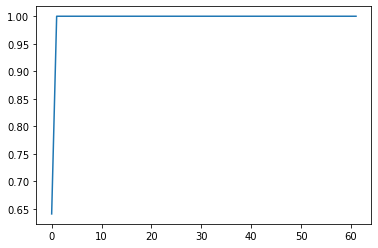

[0.64087269 0.35912723 0.00000002 0.00000001 0.00000001 0.00000001
 0.00000001 0.00000001 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=x_train_scaled.shape[1])
x_train_scaled[:] = pca.fit_transform(x_train_scaled)
np.set_printoptions(suppress=True)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()
print(pca.explained_variance_ratio_)

In [ ]:
pca = PCA(n_components=6)
x_train_scaled = pca.fit_transform(x_train_scaled)
x_val_scaled = pca.transform(x_val_scaled)
x_test_scaled = pca.transform(x_test_scaled)
x_train_scaled = pd.DataFrame(x_train_scaled)
x_val_scaled = pd.DataFrame(x_val_scaled)
x_test_scaled = pd.DataFrame(x_test_scaled)
x_train_scaled

,0,1,2,3,4,5
0,-14527.723965,11702.367843,1.617393,-0.091351,0.260542,-0.207324
1,10454.949971,11959.773718,0.754506,0.996705,-1.573704,-0.035904
2,1412.444034,11865.243360,-2.059907,1.685689,0.402782,0.034457
3,-13468.749636,11710.321084,0.778344,1.338207,-0.395847,1.332714
4,-4323.228471,11803.916864,-0.866215,-0.015609,-0.336804,0.371765
...,...,...,...,...,...,...
23700,12849.950251,-11715.721518,-1.887282,1.688879,0.335785,0.265663
23701,-4421.115560,-11895.363214,-0.874404,0.032518,-1.227802,0.838369
23702,-7474.941845,-11927.950230,1.996100,0.075034,0.370044,0.154433
23703,5580.370165,-11793.913898,1.785614,-0.154966,-0.006299,0.025395


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train_scaled, y_train)
y_pred_dt = dt_10.predict(x_val_scaled)
metrics.accuracy_score(y_pred_dt, y_val)

0.9090909090909091

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt))

from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_dt)
print(cm)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4318
           1       0.00      0.00      0.00       423

    accuracy                           0.91      4741
   macro avg       0.46      0.50      0.48      4741
weighted avg       0.83      0.91      0.87      4741

[[4310    8]
 [ 423    0]]


Yikes! Not good at all..

### Scaling all

In [ ]:
x_train_scaled = StandardScaler().fit_transform(x_train)
x_val_scaled = StandardScaler().fit_transform(x_val)
x_test_scaled = StandardScaler().fit_transform(x_test)

PCA

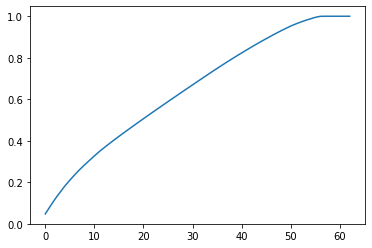

[0.04707499 0.03661389 0.03544613 0.03194292 0.03093938 0.02756185
 0.02642788 0.02468581 0.02271185 0.02177002 0.02159    0.02069526
 0.01913505 0.01848504 0.01827986 0.01752557 0.01747739 0.0170683
 0.01698403 0.01692999 0.01676867 0.01665919 0.01658089 0.01648891
 0.0163592  0.01630539 0.01620332 0.01617929 0.01615534 0.01613913
 0.01609729 0.01601066 0.01594753 0.01586037 0.01583619 0.01558345
 0.01535674 0.01521658 0.01495725 0.0146551  0.01438515 0.01422427
 0.01409633 0.01392199 0.01339085 0.01313152 0.01291383 0.01277109
 0.01214041 0.01165483 0.01150061 0.00975208 0.00910924 0.00830354
 0.0074465  0.00726299 0.00483568 0.0004534  0.         0.
 0.         0.         0.        ]


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=x_train_scaled.shape[1])
x_train_scaled[:] = pca.fit_transform(x_train_scaled)
np.set_printoptions(suppress=True)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()
print(pca.explained_variance_ratio_)

In [ ]:
pca = PCA(n_components=56)
x_train_scaled = pca.fit_transform(x_train_scaled)
x_val_scaled = pca.transform(x_val_scaled)
x_test_scaled = pca.transform(x_test_scaled)
x_train_scaled = pd.DataFrame(x_train_scaled)
x_val_scaled = pd.DataFrame(x_val_scaled)
x_test_scaled = pd.DataFrame(x_test_scaled)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train_scaled, y_train)
y_pred_dt = dt_10.predict(x_val_scaled)
metrics.accuracy_score(y_pred_dt, y_val)

0.9033959080362792

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt))

from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_dt)
print(cm)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      4318
           1       0.17      0.02      0.04       423

    accuracy                           0.90      4741
   macro avg       0.54      0.51      0.49      4741
weighted avg       0.85      0.90      0.87      4741

[[4274   44]
 [ 414    9]]


A bit better but still pretty bad :/ 

It seems to be that for scaling numerical and categorical columns separately and then applying PCA, the model was not able to learn properly in how to predict successful movies. It was also always predicting the movies to be unsuccessful. 

Scaling the entire dataframe was a bit better, BUT it was still very bad with predicting successful movies. Since this may be due to the data being unbalnced, let's try undersampling with the scaled data. 

### Undersampling added

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
x_train_under_s, y_train_under_s = ros.fit_resample(x_train_scaled, y_train)
x_train_under_s = pd.DataFrame(x_train_under_s)
x_train_under_s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
0,1.534351,1.563938,-1.704669,-0.704284,1.310428,-1.091625,1.340700,1.626735,0.913920,0.042019,-2.138051,-1.169414,4.049733,-0.976025,0.082028,-1.618476,-0.096103,3.602379,-0.546237,2.229261,-1.661144,-0.903782,-0.573674,2.303699,-0.236753,-0.598435,0.146691,0.000103,0.257243,1.438052,-1.508227,0.893239,-1.433240,1.141338,-0.824243,-2.180672,1.499534,-1.930812,-1.207090,0.767802,0.844125,1.210562,0.697238,0.893668,-0.279500,0.896666,0.742439,0.384031,-2.212083,0.285270,-0.932569,-1.302844,-1.116038,-0.395456,0.814165,0.650079
1,1.575582,4.471257,2.763558,0.445536,-1.700378,-2.293545,0.061532,1.624972,0.670360,-1.040410,-0.611247,0.227343,-0.535467,0.237301,-0.013810,-0.970780,-0.399865,0.033134,-0.338458,0.239785,0.739132,-0.190891,0.341107,0.461233,0.205312,0.462131,-0.301199,0.182736,0.021810,-0.308706,0.520843,-0.088485,-0.015654,-0.705128,0.235623,0.049203,-1.005830,-0.019885,1.559323,0.316450,-1.956690,0.046719,-0.732896,-0.106752,1.820923,0.986054,-1.839770,1.449348,-0.497911,0.099903,-1.158615,0.481457,0.543893,1.147696,-1.350817,-0.898421
2,-2.033776,1.372769,0.110064,-1.540126,-0.689789,-0.317559,-0.616539,-0.862252,0.571115,-0.760525,-1.086966,0.244052,0.097158,-0.020799,0.670028,-0.263705,0.012863,-0.515737,-0.550417,-0.536724,0.226862,-0.102557,0.197166,-0.426651,0.080321,0.105196,0.159955,0.043497,0.036327,-0.013417,0.260688,0.358043,-0.021330,0.132010,0.122285,-0.161701,0.101427,-0.699722,-0.512144,-0.285961,0.028676,0.198977,-0.140892,-0.221950,-1.783249,1.617297,-0.263900,-0.600372,0.273998,0.001994,0.507575,0.126389,-0.551804,0.325632,0.056321,1.003013
3,-1.085564,-2.131555,1.220952,-0.830231,0.251246,-0.706560,0.842748,0.373812,-0.050920,-0.741043,-0.196822,0.231391,-0.930640,-0.013424,-0.263802,0.185964,-0.764899,0.276413,0.839222,0.034095,0.123459,0.045017,-0.322932,0.046145,-0.039275,0.131193,-0.197151,-0.001006,0.036018,-0.156516,0.110666,-0.299840,-0.252882,-0.038893,-0.065561,0.144421,-0.213407,0.086573,0.185410,0.383078,-0.149225,0.554273,-0.169475,0.753982,0.919934,-0.579498,0.011615,-0.931839,0.229205,0.245456,-0.513266,0.314487,-1.603076,0.598895,0.213789,-0.426010
4,1.056128,0.200078,-0.646845,0.542969,-2.426795,1.676912,-1.368408,0.502929,1.407270,0.215203,0.831111,2.991977,1.474976,-1.638749,1.447062,-0.226078,0.883362,1.495724,-0.581256,-0.705329,-0.023280,-0.412195,0.675771,-0.602604,-0.622102,-1.011707,0.168272,0.214282,-0.733890,0.137461,0.195161,0.725930,1.173447,0.602131,0.390077,2.006169,-0.714095,2.108558,-0.453727,1.672263,1.059466,0.836213,-1.331105,-1.440295,-1.910586,-1.028275,-0.546454,0.132982,0.161097,0.134005,-2.085108,-0.849777,0.199066,0.721774,-0.217487,-0.107816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4143,3.117883,2.488348,3.123708,2.207877,-1.514694,-2.486036,0.997930,0.328266,-0.861328,-1.145260,-0.119789,0.487155,0.181592,0.348060,-1.122783,0.242636,-0.635828,-0.078219,-0.027115,-0.006923,-0.153173,-0.272685,-0.381814,0.935549,0.332559,-0.513734,-0.147298,0.195328,0.337722,-0.028563,0.191624,-0.106631,-0.559451,-0.173906,-0.076800,-0.042702,0.032471,0.788385,-0.867588,-1.122809,-0.376085,1.240692,1.562813,1.551881,0.042324,1.228599,0.274175,1.034661,0.255637,-0.362506,-0.346599,-0.997253,-0.547466,1.725921,-0.895892,-1.291961
4144,4.504043,3.674224,2.714998,-1.492467,-1.975404,1.242953,1.104996,0.665685,-0.664047,-0.999601,-2.229978,0.085533,0.432337,1.670763,0.267997,-0.484162,0.286691,-0.374631,-0.726127,-0.585757,0.008863,-0.272707,-0.083918,0.907781,0.787283,-0.291779,-0.211796,-0.096594,0.296678,-0.024490,0.212182,0.358042,-0.896650,-0.527545,-0.407538,-0.714785,-0.151766,0.467356,-0.699379,-1.047328,-1.990384,1.051300,0.964085

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train_under_s, y_train_under_s)
y_pred_dt = dt_10.predict(x_val_scaled)
metrics.accuracy_score(y_pred_dt, y_val)

0.730014764817549

In [ ]:
print(metrics.classification_report(y_val, y_pred_dt))

from sklearn import metrics
cm = metrics.confusion_matrix(y_val, y_pred_dt)
print(cm)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      4318
           1       0.14      0.38      0.20       423

    accuracy                           0.73      4741
   macro avg       0.53      0.57      0.52      4741
weighted avg       0.86      0.73      0.78      4741

[[3299 1019]
 [ 261  162]]


## Conclusion

The model is now predicting successful movies more, but the accuracy score is low, which is a similar dilemma we had with the original model. It's really hard to find that sweet spot where the model is still predicting unsuccessful movies more but it is also predicting successful movies *accurately*. 

Interestingly, the best performance we have been getting was WITHOUT sampling and dimensionality reduction. Perhaps resampling was not the best choice since in reality, there are indeed more unsuccessful movies than successful ones. Although the difference between undersampling and no sampling was very small, we could see that there were a lot less false positive cases for no sampling, and we pointed out earlier that false positive is worse than false negative in this context. 

Scaling affected the score only so slightly but dimensionality reduction noticeably decreased the performance for predicting successful movies. Perhaps, according to [this](https://www.quora.com/For-which-cases-is-it-not-preferable-to-use-principal-component-analysis-PCA), our data was not suitable for PCA after all. 

**Thus, we will go with no sampling, no dimensionality reduction.**

Following is the result for the test set. 



In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

dt_10 = BaggingClassifier(DecisionTreeClassifier(max_depth=10))
dt_10.fit(x_train, y_train)
y_pred_dt = dt_10.predict(x_test)
metrics.accuracy_score(y_pred_dt, y_test)

0.9300854160075925

In [ ]:
print(metrics.classification_report(y_test, y_pred_dt))

from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred_dt)
print(cm)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2860
           1       0.74      0.41      0.53       301

    accuracy                           0.93      3161
   macro avg       0.84      0.70      0.75      3161
weighted avg       0.92      0.93      0.92      3161

[[2816   44]
 [ 177  124]]


In [ ]:
y_pred_tr = dt_10.predict(x_train)
y_pred_v = dt_10.predict(x_val)

0.6982877587528751


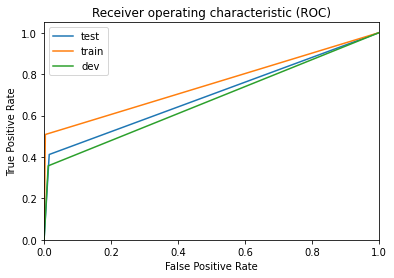

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_dt)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_t = dict()
tpr_t = dict()
roc_auc = dict()
for i in range(2):
    fpr_t[i], tpr_t[i], _ = roc_curve(y_train, y_pred_tr)
    roc_auc[i] = auc(fpr_t[i], tpr_t[i])


fpr_v = dict()
tpr_v = dict()
roc_v = dict()
for i in range(2):
    fpr_v[i], tpr_v[i], _ = roc_curve(y_val, y_pred_v)
    roc_auc[i] = auc(fpr_v[i], tpr_v[i])

print(metrics.roc_auc_score(y_test, y_pred_dt))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(fpr_t[1], tpr_t[1])
plt.plot(fpr_v[1], tpr_v[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend({'test','train', 'dev'})
plt.show()

0.36006075068212134


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.36')

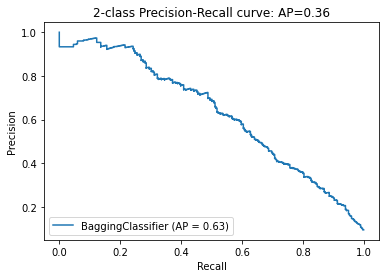

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred_dt)
print(average_precision)

disp = plot_precision_recall_curve(dt_10, x_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

## Persisting the best model

In [ ]:
from joblib import dump, load
dump(dt_10, 'boModel.joblib') 

['boModel.joblib']

In [ ]:
x_test

,duration,top_actor,top_director,top_company,title_length,genre_count,actor_count,published_month,published_weekday,published_quarter,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,negative,neutral,positive,Africa,Asia,Australia,Europe,North America,South America,other
864,193.0,0.0,0.0,1.0,29.0,3.0,15.0,9.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5963,107.0,0.0,0.0,0.0,22.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8714,113.0,0.0,0.0,1.0,14.0,3.0,15.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11207,100.0,0.0,1.0,1.0,19.0,1.0,15.0,8.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30822,120.0,0.0,0.0,0.0,18.0,2.0,15.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7126,81.0,0.0,0.0,1.0,13.0,3.0,15.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6962,109.0,1.0,0.0,1.0,17.0,3.0,15.0,8.0,4.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13915,109.0,1.0,1.0,1.0,15.0,3.0,15.0,10.0,4.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12019,77.0,0.0,0.0,1.0,22.0,2.0,15.0,7.0,4.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x_test.columns

Index(['duration', 'top_actor', 'top_director', 'top_company', 'title_length',
       'genre_count', 'actor_count', 'published_month', 'published_weekday',
       'published_quarter', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'negative',
       'neutral', 'positive', 'Africa', 'Asia', 'Australia', 'Europe',
       'North America', 'South America', 'other'],
      dtype='object')